## En este primer reporte ignoramos la clasificación en resurtible

In [2]:
# Importar librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp

In [3]:
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [4]:
# Especificar columnas
relevant_columns = ['SKU','Tienda','FORMATO','REGION','Categoria','Proveedor','CLASE','Mes','DiaSem','Sem','TipoResurtible','Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante']
num_columns = ['Existencia','fiDesplazamiento','VentaPromedio']
cat_columns = ['SKU','Tienda','FORMATO','REGION','Categoria','Proveedor','CLASE','Mes','DiaSem','Sem','TipoResurtible']
target = ['Y_Faltante']

In [5]:
dtype = {'SKU':'object','FORMATO':'object','REGION':'object','Tienda':'object','Categoria':'object','Proveedor':'object','CLASE':'object','SCLASE':'object','Mes':'object','DiaSem':'object','Sem':'object','TipoResurtible':object,'Existencia':'float','fiDesplazamiento':'float',
\
'VentaPromedio':'float','Y_Faltante':'int'}

In [6]:
# Abrir el archivo
file = 'datos_entrenamiento.csv'
data = pd.read_csv(file, header=0,low_memory=False, encoding='latin-',usecols=relevant_columns,dtype=dtype)
print('rows:', data.shape[0], ' columns:', data.shape[1])

rows: 5094322  columns: 15


In [7]:
# Abrir el archivo que contiene el conjunto de validación 
file_val = 'datos_prueba.csv'
data_val = pd.read_csv(file_val, header=0,low_memory=False, encoding='latin-1',usecols=relevant_columns,dtype=dtype)
print('rows:', data_val.shape[0], ' columns:', data_val.shape[1])

rows: 842788  columns: 15


In [8]:
data.dtypes

SKU                  object
Tienda               object
FORMATO              object
REGION               object
Categoria            object
Proveedor            object
CLASE                object
Mes                  object
DiaSem               object
Sem                  object
TipoResurtible       object
Existencia          float64
fiDesplazamiento    float64
VentaPromedio       float64
Y_Faltante            int64
dtype: object

In [9]:
data = data.dropna()
data_val = data_val.dropna()

yes %: 50.23151958917404- no %: 49.76848041082595


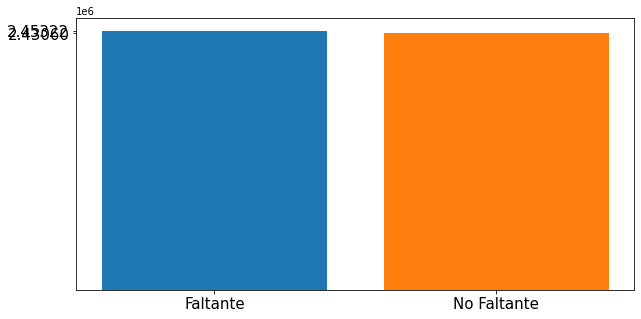

In [10]:
# Revisamos la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [11]:
#Balanceamos a 50% - 50% nuestro conjunto de datos.
data_yes = data[data["Y_Faltante"] == 1]
data_no = data[data["Y_Faltante"] == 0]
over_sampling = data_yes.sample(no, replace=True, \
random_state = 0)
balanced_data = pd.concat([data_no, over_sampling], \
axis=0)
data = balanced_data.reset_index(drop=True)

yes %: 50.0- no %: 50.0


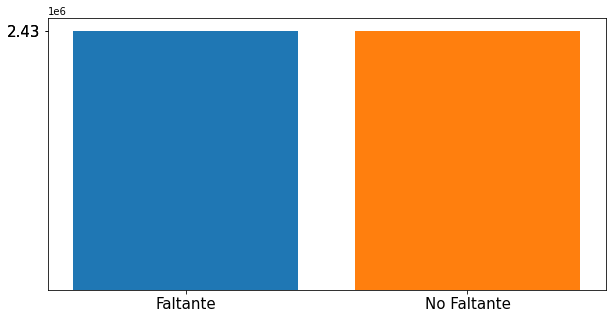

In [12]:
# Verificamos que el conjunto de datos está perfectamente balanceado
# Revisamos la proporción de datos
target = data['Y_Faltante']
yes = target[target == 1].count()
no = target[target == 0].count()
print('yes %: ' + str(yes/len(target)*100) + '- no %: ' \
        + str(no/len(target)*100))


fig, ax = plt.subplots(figsize=(10,5))
plt.bar("Faltante", yes)
plt.bar("No Faltante", no)
ax.set_yticks([yes,no])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [13]:
# Aislamos las variables numéricas y realizamos un min-max scaling sobre ellas
categorical = data.drop(columns=['Existencia','fiDesplazamiento','VentaPromedio','Y_Faltante'])
numerical = data[['Existencia','fiDesplazamiento','VentaPromedio']]
numerical_scaled = (numerical - numerical.min())/(numerical.max() - numerical.min()) 
faltante = data["Y_Faltante"]

In [14]:
scaled_data = pd.concat([categorical,numerical_scaled,faltante], axis=1)
scaled_data.to_csv("dccc_prepared.csv", index=False)
scaled_data

,SKU,Tienda,FORMATO,REGION,Categoria,Proveedor,CLASE,Mes,DiaSem,Sem,TipoResurtible,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante
0,3002319,CHEDRAUI MEXICO TENAYUCA,CHEDRAUI CD,VM CENTRO,BLANQUEADORES,ALEN DEL NORTE SA DE CV,BLANQUEADORES,5,1,22,RC,0.476383,0.007785,0.004593,0
1,3065062,CHEDRAUI MEXICO TENAYUCA,CHEDRAUI CD,VM CENTRO,DESODORANTES DAMA,COLGATE PALMOLIVE SA DE CV,DESODORANTES DAMA,5,5,22,RC,0.462939,0.001669,0.001342,0
2,3074566,CHEDRAUI MEXICO TENAYUCA,CHEDRAUI CD,VM CENTRO,ALIMENTACIÓN SECA,EFFEM MEXICO INC Y COMPAÑIA S EN NC,ALIMENTACIÓN SECA,5,4,22,RC,0.463178,0.000571,0.000949,0
3,3001968,CHEDRAUI MEXICO TENAYUCA,CHEDRAUI CD,VM CENTRO,REFRESCOS Y SODAS,PROPIMEX S DE RL DE CV,REFRESCOS Y SODAS,5,1,22,RL,0.472081,0.037562,0.006884,0
4,3466492,CHEDRAUI MEXICO TENAYUCA,CHEDRAUI CD,VM CENTRO,LECHE POLVO,MARCAS NESTLE SA DE CV,LECHE POLVO,5,3,22,RC,0.462522,0.000341,0.001128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861201,3502536,CHEDRAUI SAN MARTIN TEXMELUCAN,CHEDRAUI CD,PUEBLA,REFRESCOS Y SODAS,PROPIMEX S DE RL DE CV,REFRESCOS Y SODAS,5,3,20,RL,0.462391,0.000288,0.000898,1
4861202,3691742,CHEDRAUI VERACRUZ LAS BRISAS,CHEDRAUI CD,VERACRUZ,CRISTALERIA,REGALOS SIGLO XXI SA DE CV,CRISTALERIA,5,3,21,RC,0.462510,0.000299,0.000904,1
4861203,3268752,CHEDRAUI CANCUN CHACMOOL,CHEDRAUI AB,CANCUN,COOLERS Y BEBIDAS PREPARADAS,BROWN FORMAN TEQUILA MEXICO S DE RL,COOLERS Y BEBIDAS PREPARADAS,2,6,7,RC,0.462391,0.000395,0.000898,1
4861204,3437365,CHEDRAUI SELECTO MEXICO UNIVERSIDAD,CHEDRAUI SELECTO,VM SELECTO,COMIDA CONGELADA,DISTRIBUIDORA ALIMENTICIA DE BAJA,COMIDA CONGELADA,2,2,9,RC,0.462796,0.000800,0.002028,1


In [15]:
data_shuffled = scaled_data.sample(frac=1).reset_index(drop=True)
data = data_shuffled
data

,SKU,Tienda,FORMATO,REGION,Categoria,Proveedor,CLASE,Mes,DiaSem,Sem,TipoResurtible,Existencia,fiDesplazamiento,VentaPromedio,Y_Faltante
0,3642198,CHEDRAUI PLAYA DEL CARMEN VILLAS,CHEDRAUI CD,RIVIERA MAYA,CRISTALERIA,HUT INTERNACIONAL SA DE CV,CRISTALERIA,12,7,49,RC,0.462534,0.000331,0.000948,1
1,3010005,CHEDRAUI CAMPECHE SANTA ANA,CHEDRAUI AB,CAMPECHE,ACEITES DE OLIVA,DEOLEO COMERCIAL MEXICO SA DE CV,ACEITES DE OLIVA,1,7,2,RC,0.462391,0.000885,0.001437,1
2,3316063,CHEDRAUI MEXICO HEROES DE TECAMAC,CHEDRAUI CD,VM ORIENTE,PAPEL HIGIÉNICO,KIMBERLY CLARK DE MEXICO SA DE CV,PAPEL HIGIÉNICO,2,1,9,RC,0.463786,0.003557,0.005339,0
3,3457253,CHEDRAUI POZA RICA PALMAS,CHEDRAUI CD,XALAPA,TOALLAS FEMENINAS,SCA CONSUMIDOR MEXICO SA DE CV,TOALLAS FEMENINAS,3,5,12,RC,0.463929,0.000832,0.001539,0
4,3706885,CHEDRAUI SELECTO AGUASCALIENTES COLOSIO,CHEDRAUI CD,LEON,SHAMPOOS Y ACONDICIONADOR,PROCTER & GAMBLE MEXICO INC. (35784),SHAMPOOS Y ACONDICIONADOR,3,4,13,RC,0.462391,0.000320,0.000898,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4861201,3389354,SUPERCITO VILLA DE LAS FLORES,SUPERCITO CD,VM NORTE,BEBIDAS NO GASIFICADAS,JUGOS DEL VALLE SAPI DE CV,BEBIDAS NO GASIFICADAS,6,6,23,RC,0.462415,0.000565,0.000916,1
4861202,3491231,CHEDRAUI VILLA CRYSTAL,CHEDRAUI AB,VILLAHERMOSA,LOZA,CINSA SA DE CV,LOZA,4,3,15,RC,0.462486,0.000427,0.000979,1
4861203,3062872,CHEDRAUI PLAYA DEL CARMEN AMERICAS,CHEDRAUI AB,RIVIERA MAYA,CERVEZAS,SUBOTEXX COMERCIALIZADORA SA D (42093),CERVEZAS,3,4,12,RL,0.462784,0.000688,0.001787,0
4861204,3668437,CHEDRAUI LEON SAN JUAN BOSCO,CHEDRAUI CD,LEON,ARTÍCULOS DE COCCIÓN,CINSA SA DE CV,ARTÍCULOS DE COCCIÓN,2,4,7,RC,0.462463,0.000320,0.001000,1


In [16]:
X_train = data.drop('Y_Faltante',axis=1)
y_train = data.Y_Faltante
X_val = data_val.drop('Y_Faltante',axis=1)
y_val = data_val.Y_Faltante

In [17]:
indices_categoricos = np.where(X_train.dtypes != float)[0]
indices_categoricos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [18]:
num_ind = np.where(X_train.dtypes != object)[0]
num_ind

array([11, 12, 13])

In [19]:
model = CatBoostClassifier(
    l2_leaf_reg=int(3.0),
    custom_loss=[metrics.Accuracy()],
    random_seed=0,
    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
    task_type='GPU'
)

In [20]:
model.fit(
    X_train, y_train,
    cat_features=indices_categoricos,
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    #iterations=140,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6485233	test: 0.6484004	best: 0.6484004 (0)	total: 654ms	remaining: 10m 53s
1:	learn: 0.6084889	test: 0.6084684	best: 0.6084684 (1)	total: 1.17s	remaining: 9m 46s
2:	learn: 0.5725328	test: 0.5715059	best: 0.5715059 (2)	total: 1.69s	remaining: 9m 20s
3:	learn: 0.5398475	test: 0.5394754	best: 0.5394754 (3)	total: 2.21s	remaining: 9m 9s
4:	learn: 0.5102201	test: 0.5097081	best: 0.5097081 (4)	total: 2.72s	remaining: 9m 1s
5:	learn: 0.4838993	test: 0.4836218	best: 0.4836218 (5)	total: 3.24s	remaining: 8m 56s
6:	learn: 0.4605042	test: 0.4608598	best: 0.4608598 (6)	total: 3.75s	remaining: 8m 52s
7:	learn: 0.4398302	test: 0.4405604	best: 0.4405604 (7)	total: 4.46s	remaining: 9m 12s
8:	learn: 0.4209839	test: 0.4207984	best: 0.4207984 (8)	total: 4.97s	remaining: 9m 7s
9:	learn: 0.4041390	test: 0.4044199	best: 0.4044199 (9)	total: 5.61s	remaining: 9m 14s
10:	learn: 0.3902382	test: 0.3897243	best: 0.3897243 (10)	total: 6.35s	remaining: 9m 31s
11:	learn: 0.3760596	test: 0.3761114	best: 

In [21]:
model.save_model('catboost_model.dump')

In [22]:
model.load_model('catboost_model.dump')

In [23]:
y_pred = model.predict(X_val)
prediction_probs = model.predict_proba(X_val)

accuracy = accuracy_score(y_val,y_pred)
recall = recall_score(y_val,y_pred,average='binary',pos_label=1)
precision = precision_score(y_val,y_pred,average='binary',pos_label=0)
balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
f1 = f1_score(y_val,y_pred,pos_label=1)
print(f'Accuracy: {accuracy}')
print(f'True Positive Rate {recall}')
print(f'Precision {precision}')
print(f'Balanced accuracy {balanced_accuracy}')
print(f'f1 score {f1}')

Accuracy: 0.9202106286094383
True Positive Rate 0.8815659460100391
Precision 0.8898735282092274
Balanced accuracy 0.9202496079885963
f1 score 0.9170798646757782


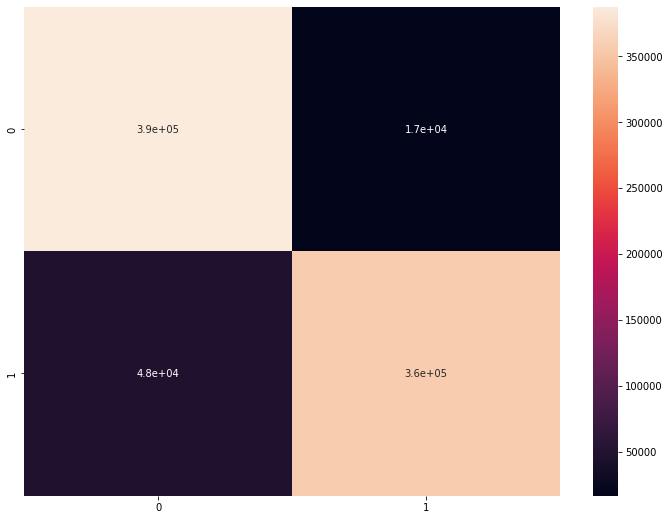

In [24]:
# Dibujamos también la matriz de confusión para nuestro modelo
mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(mat, annot=True)
plt.show()

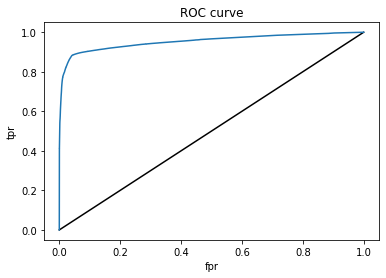

In [25]:
# Dibujamos la curva de ROC para este modelo
from sklearn.metrics import roc_curve
y_pred_proba = model.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba,pos_label=1)
plt.plot([0,1],[0,1],'k-')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

<AxesSubplot:>

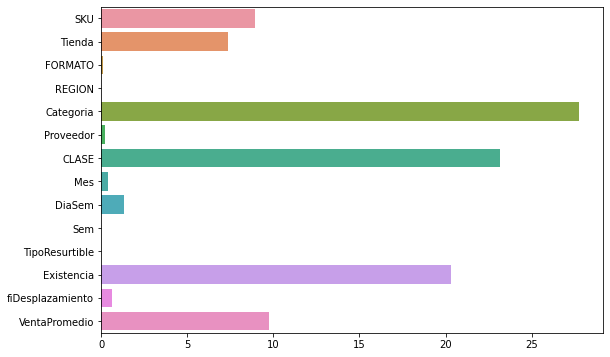

In [26]:
# Graficar la importancia de las variables
fi2 = pd.Series(model.feature_importances_, index=X_train.columns)
fig, ax = plt.subplots(figsize = (9,6))
sns.barplot(x=fi2.values, y=fi2.index, ax=ax)

## Algunas observaciones sobre formatos

In [27]:
def prueba(frame,frame_val):
    l=len(frame['FORMATO'].value_counts())
    formatos=frame['FORMATO'].value_counts()
    for i in range(l):
        cadena=formatos.iloc[i:i+1].index[0]
        print(cadena)

prueba(data,data_val)

CHEDRAUI CD
CHEDRAUI AB
SUPER CHEDRAUI CD
CHEDRAUI SELECTO
SUPER CHEDRAUI AB
SUPERCITO CD
SUPER CHE CD
SUPER CHEDRAUI SELECTO


In [28]:
data['FORMATO'].value_counts()

CHEDRAUI CD               2214181
CHEDRAUI AB               1158870
SUPER CHEDRAUI CD          659049
CHEDRAUI SELECTO           355723
SUPER CHEDRAUI AB          190487
SUPERCITO CD               174452
SUPER CHE CD                64492
SUPER CHEDRAUI SELECTO      43952
Name: FORMATO, dtype: int64

## Construimos modelos específicos por formato y evaluamos por el respectivo formato. 
### Comentarios:


* El número de observaciones de productos por formato difiere de forma significativa.
* Consideraciones de cardinalidad de conjuntos entrenamiento/validación nos sugieren que 

In [29]:
data['FORMATO'].value_counts()

CHEDRAUI CD               2214181
CHEDRAUI AB               1158870
SUPER CHEDRAUI CD          659049
CHEDRAUI SELECTO           355723
SUPER CHEDRAUI AB          190487
SUPERCITO CD               174452
SUPER CHE CD                64492
SUPER CHEDRAUI SELECTO      43952
Name: FORMATO, dtype: int64

In [30]:
data_val['FORMATO'].value_counts()

CHEDRAUI CD               365112
CHEDRAUI AB               178352
SUPER CHEDRAUI CD         127397
CHEDRAUI SELECTO           54428
SUPER CHEDRAUI AB          36656
SUPERCITO CD               31154
SUPER CHE CD               11585
SUPER CHEDRAUI SELECTO      4133
Name: FORMATO, dtype: int64

In [31]:
def reporte_formato(frame,frame_val):
    l = len(frame['FORMATO'].value_counts())
    formatos = frame['FORMATO'].value_counts()
    def segmentador_formato(frame,cadena):
        arreglo = frame[frame['FORMATO']==cadena]
        return arreglo
    lineas = []
    dict_acc = {}
    dict_balanced = {}
    dict_recall = {}
    dict_pre = {}
    dict_f1 = {}
    dict_graph = {}
    dict_frame = {}
    for i in range(l):
        cadena = formatos.iloc[i:i+1].index[0]
        formato_train = segmentador_formato(frame,cadena)
        formato_val = segmentador_formato(frame_val,cadena)
        syntetic = 2*(len(formato_train)*len(formato_val))/(len(formato_train)+len(formato_val))
        X_train = formato_train.drop('Y_Faltante',axis=1)
        y_train = formato_train.Y_Faltante
        X_val = formato_val.drop('Y_Faltante',axis=1)
        y_val = formato_val.Y_Faltante
        cat = CatBoostClassifier(
            l2_leaf_reg=int(2.0),
            custom_loss=[metrics.Accuracy()],
            random_seed=0,
            logging_level='Verbose',
            task_type='GPU',
            iterations=140
        )
        cat.fit(
            X_train,y_train,
            cat_features=indices_categoricos,
            eval_set=(X_val,y_val),
            logging_level='Verbose',
            plot=True
        );
        y_pred = cat.predict(X_val)
        y_prob = cat.predict_proba(X_val)
        pred_cb = pd.DataFrame(y_prob).assign(CB_Pred=pd.Series(y_pred))
        pred_cb = pd.DataFrame(pred_cb).assign(TrueValue=pd.Series(y_val))
        accuracy = accuracy_score(y_val,y_pred)
        recall = recall_score(y_val,y_pred)
        precision = precision_score(y_val,y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
        f1 = f1_score(y_val,y_pred)
        lineas.append(f'#####Calificaciones obtenidas para el formato {i} ########## \n')
        lineas.append(f'\n')
        lineas.append(f'Nombre de formato :  ' + cadena)
        lineas.append(f'Precisión: {accuracy} \n')
        lineas.append(f'Precisión Balanceada: {balanced_accuracy} \n')
        lineas.append(f'Recall: {recall} \n')
        lineas.append(f'Precision: {precision} \n')
        lineas.append(f'Calificación F1: {f1} \n')
        lineas.append(f'\n')
        dict_acc[cadena]=accuracy
        dict_recall[cadena]=recall 
        dict_pre[cadena]=precision
        dict_balanced[cadena]=balanced_accuracy
        dict_graph[cadena]=(syntetic,balanced_accuracy)
        dict_frame[cadena]=pred_cb
        dict_f1[cadena]=f1
    return [lineas,dict_balanced,dict_graph,dict_frame,dict_acc,dict_recall,dict_pre,dict_f1]

In [32]:
resultados_formato=reporte_formato(data,data_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6708061	test: 0.6702796	best: 0.6702796 (0)	total: 17.1ms	remaining: 2.37s
1:	learn: 0.6497815	test: 0.6487955	best: 0.6487955 (1)	total: 32.2ms	remaining: 2.22s
2:	learn: 0.6299202	test: 0.6282409	best: 0.6282409 (2)	total: 47.4ms	remaining: 2.16s
3:	learn: 0.6111669	test: 0.6088601	best: 0.6088601 (3)	total: 62.6ms	remaining: 2.13s
4:	learn: 0.5934543	test: 0.5905868	best: 0.5905868 (4)	total: 77.5ms	remaining: 2.09s
5:	learn: 0.5766713	test: 0.5734685	best: 0.5734685 (5)	total: 92.4ms	remaining: 2.06s
6:	learn: 0.5608474	test: 0.5584964	best: 0.5584964 (6)	total: 107ms	remaining: 2.04s
7:	learn: 0.5457949	test: 0.5431619	best: 0.5431619 (7)	total: 122ms	remaining: 2.01s
8:	learn: 0.5315161	test: 0.5288690	best: 0.5288690 (8)	total: 137ms	remaining: 1.99s
9:	learn: 0.5179227	test: 0.5147076	best: 0.5147076 (9)	total: 152ms	remaining: 1.97s
10:	learn: 0.5049950	test: 0.5014948	best: 0.5014948 (10)	total: 166ms	remaining: 1.94s
11:	learn: 0.4927179	test: 0.4895332	best: 0.4

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6712151	test: 0.6714354	best: 0.6714354 (0)	total: 13.6ms	remaining: 1.88s
1:	learn: 0.6505622	test: 0.6512489	best: 0.6512489 (1)	total: 24ms	remaining: 1.66s
2:	learn: 0.6311333	test: 0.6316056	best: 0.6316056 (2)	total: 34ms	remaining: 1.55s
3:	learn: 0.6127155	test: 0.6134641	best: 0.6134641 (3)	total: 43.6ms	remaining: 1.48s
4:	learn: 0.5953185	test: 0.5960548	best: 0.5960548 (4)	total: 53.2ms	remaining: 1.44s
5:	learn: 0.5788137	test: 0.5798465	best: 0.5798465 (5)	total: 63ms	remaining: 1.41s
6:	learn: 0.5632121	test: 0.5649450	best: 0.5649450 (6)	total: 72.8ms	remaining: 1.38s
7:	learn: 0.5483837	test: 0.5504275	best: 0.5504275 (7)	total: 82.4ms	remaining: 1.36s
8:	learn: 0.5343605	test: 0.5369934	best: 0.5369934 (8)	total: 92.2ms	remaining: 1.34s
9:	learn: 0.5209930	test: 0.5239559	best: 0.5239559 (9)	total: 102ms	remaining: 1.32s
10:	learn: 0.5082932	test: 0.5118306	best: 0.5118306 (10)	total: 111ms	remaining: 1.31s
11:	learn: 0.4962480	test: 0.5003641	best: 0.5003

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6715227	test: 0.6720252	best: 0.6720252 (0)	total: 10.3ms	remaining: 1.44s
1:	learn: 0.6511451	test: 0.6519032	best: 0.6519032 (1)	total: 18.8ms	remaining: 1.3s
2:	learn: 0.6318922	test: 0.6327348	best: 0.6327348 (2)	total: 27.9ms	remaining: 1.27s
3:	learn: 0.6137886	test: 0.6152849	best: 0.6152849 (3)	total: 36.3ms	remaining: 1.24s
4:	learn: 0.5966981	test: 0.5984610	best: 0.5984610 (4)	total: 44.7ms	remaining: 1.21s
5:	learn: 0.5804745	test: 0.5828511	best: 0.5828511 (5)	total: 53.2ms	remaining: 1.19s
6:	learn: 0.5651680	test: 0.5686625	best: 0.5686625 (6)	total: 61.5ms	remaining: 1.17s
7:	learn: 0.5505789	test: 0.5543890	best: 0.5543890 (7)	total: 70ms	remaining: 1.16s
8:	learn: 0.5367728	test: 0.5410919	best: 0.5410919 (8)	total: 78.4ms	remaining: 1.14s
9:	learn: 0.5235912	test: 0.5281096	best: 0.5281096 (9)	total: 86.7ms	remaining: 1.13s
10:	learn: 0.5110770	test: 0.5160381	best: 0.5160381 (10)	total: 95ms	remaining: 1.11s
11:	learn: 0.4992158	test: 0.5047695	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6716360	test: 0.6792425	best: 0.6792425 (0)	total: 8.83ms	remaining: 1.23s
1:	learn: 0.6514972	test: 0.6580005	best: 0.6580005 (1)	total: 15.6ms	remaining: 1.08s
2:	learn: 0.6324138	test: 0.6377636	best: 0.6377636 (2)	total: 23.3ms	remaining: 1.06s
3:	learn: 0.6143901	test: 0.6197565	best: 0.6197565 (3)	total: 30.4ms	remaining: 1.03s
4:	learn: 0.5973258	test: 0.6052496	best: 0.6052496 (4)	total: 37.7ms	remaining: 1.02s
5:	learn: 0.5811723	test: 0.5885236	best: 0.5885236 (5)	total: 45.2ms	remaining: 1.01s
6:	learn: 0.5658776	test: 0.5744017	best: 0.5744017 (6)	total: 52.8ms	remaining: 1s
7:	learn: 0.5513230	test: 0.5653887	best: 0.5653887 (7)	total: 60.3ms	remaining: 994ms
8:	learn: 0.5375968	test: 0.5508528	best: 0.5508528 (8)	total: 67.2ms	remaining: 978ms
9:	learn: 0.5245812	test: 0.5362663	best: 0.5362663 (9)	total: 74ms	remaining: 963ms
10:	learn: 0.5121647	test: 0.5231523	best: 0.5231523 (10)	total: 80.9ms	remaining: 948ms
11:	learn: 0.5004140	test: 0.5111900	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6722037	test: 0.6729422	best: 0.6729422 (0)	total: 8.9ms	remaining: 1.24s
1:	learn: 0.6524408	test: 0.6533814	best: 0.6533814 (1)	total: 15.9ms	remaining: 1.09s
2:	learn: 0.6338050	test: 0.6349226	best: 0.6349226 (2)	total: 22.9ms	remaining: 1.04s
3:	learn: 0.6162411	test: 0.6178538	best: 0.6178538 (3)	total: 30.6ms	remaining: 1.04s
4:	learn: 0.5995683	test: 0.6046847	best: 0.6046847 (4)	total: 38.5ms	remaining: 1.04s
5:	learn: 0.5838511	test: 0.5897931	best: 0.5897931 (5)	total: 45.9ms	remaining: 1.02s
6:	learn: 0.5688827	test: 0.5771950	best: 0.5771950 (6)	total: 53.1ms	remaining: 1.01s
7:	learn: 0.5547161	test: 0.5636834	best: 0.5636834 (7)	total: 60.5ms	remaining: 999ms
8:	learn: 0.5413244	test: 0.5505549	best: 0.5505549 (8)	total: 67.7ms	remaining: 986ms
9:	learn: 0.5285651	test: 0.5381589	best: 0.5381589 (9)	total: 74.7ms	remaining: 971ms
10:	learn: 0.5163586	test: 0.5263843	best: 0.5263843 (10)	total: 81.6ms	remaining: 957ms
11:	learn: 0.5049450	test: 0.5194697	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757526	test: 0.6739652	best: 0.6739652 (0)	total: 7.9ms	remaining: 1.1s
1:	learn: 0.6594631	test: 0.6557340	best: 0.6557340 (1)	total: 14ms	remaining: 967ms
2:	learn: 0.6440019	test: 0.6381898	best: 0.6381898 (2)	total: 20.4ms	remaining: 933ms
3:	learn: 0.6295030	test: 0.6217310	best: 0.6217310 (3)	total: 27.2ms	remaining: 925ms
4:	learn: 0.6157531	test: 0.6058378	best: 0.6058378 (4)	total: 33.8ms	remaining: 913ms
5:	learn: 0.6027776	test: 0.5921281	best: 0.5921281 (5)	total: 40.9ms	remaining: 914ms
6:	learn: 0.5904922	test: 0.5789161	best: 0.5789161 (6)	total: 48ms	remaining: 912ms
7:	learn: 0.5788228	test: 0.5658287	best: 0.5658287 (7)	total: 54.3ms	remaining: 895ms
8:	learn: 0.5678664	test: 0.5541284	best: 0.5541284 (8)	total: 60.4ms	remaining: 879ms
9:	learn: 0.5573160	test: 0.5417402	best: 0.5417402 (9)	total: 66.6ms	remaining: 866ms
10:	learn: 0.5472114	test: 0.5301300	best: 0.5301300 (10)	total: 72.8ms	remaining: 853ms
11:	learn: 0.5377276	test: 0.5199214	best: 0.51

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6737617	test: 0.6737611	best: 0.6737611 (0)	total: 8.83ms	remaining: 1.23s
1:	learn: 0.6554803	test: 0.6548772	best: 0.6548772 (1)	total: 15.4ms	remaining: 1.06s
2:	learn: 0.6381860	test: 0.6366232	best: 0.6366232 (2)	total: 21.8ms	remaining: 996ms
3:	learn: 0.6219681	test: 0.6203394	best: 0.6203394 (3)	total: 27.7ms	remaining: 943ms
4:	learn: 0.6068125	test: 0.6053919	best: 0.6053919 (4)	total: 33.8ms	remaining: 912ms
5:	learn: 0.5924868	test: 0.5912506	best: 0.5912506 (5)	total: 39.8ms	remaining: 888ms
6:	learn: 0.5788318	test: 0.5778887	best: 0.5778887 (6)	total: 45.9ms	remaining: 871ms
7:	learn: 0.5657121	test: 0.5644893	best: 0.5644893 (7)	total: 52.4ms	remaining: 864ms
8:	learn: 0.5533465	test: 0.5521075	best: 0.5521075 (8)	total: 58.9ms	remaining: 857ms
9:	learn: 0.5415666	test: 0.5402304	best: 0.5402304 (9)	total: 65.3ms	remaining: 849ms
10:	learn: 0.5303273	test: 0.5290382	best: 0.5290382 (10)	total: 71.3ms	remaining: 836ms
11:	learn: 0.5198551	test: 0.5184814	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6698094	test: 0.6755880	best: 0.6755880 (0)	total: 8.45ms	remaining: 1.17s
1:	learn: 0.6478592	test: 0.6546586	best: 0.6546586 (1)	total: 14.6ms	remaining: 1.01s
2:	learn: 0.6271580	test: 0.6380522	best: 0.6380522 (2)	total: 20.8ms	remaining: 952ms
3:	learn: 0.6076175	test: 0.6188880	best: 0.6188880 (3)	total: 27.2ms	remaining: 924ms
4:	learn: 0.5890571	test: 0.6017558	best: 0.6017558 (4)	total: 33.5ms	remaining: 903ms
5:	learn: 0.5715414	test: 0.5876377	best: 0.5876377 (5)	total: 39.8ms	remaining: 888ms
6:	learn: 0.5548910	test: 0.5759346	best: 0.5759346 (6)	total: 45.9ms	remaining: 872ms
7:	learn: 0.5391204	test: 0.5700343	best: 0.5700343 (7)	total: 52.1ms	remaining: 860ms
8:	learn: 0.5241208	test: 0.5555660	best: 0.5555660 (8)	total: 58.4ms	remaining: 850ms
9:	learn: 0.5100214	test: 0.5414324	best: 0.5414324 (9)	total: 65ms	remaining: 845ms
10:	learn: 0.4964760	test: 0.5286660	best: 0.5286660 (10)	total: 71.6ms	remaining: 839ms
11:	learn: 0.4835900	test: 0.5167960	best: 

In [33]:
resultados_formato[0]

['#####Calificaciones obtenidas para el formato 0 ########## \n',
 '\n',
 'Nombre de formato :  CHEDRAUI CD',
 'Precisión: 0.929846184184579 \n',
 'Precisión Balanceada: 0.9299207970664914 \n',
 'Recall: 0.9018362006326451 \n',
 'Precision: 0.955731563985433 \n',
 'Calificación F1: 0.9280020238362942 \n',
 '\n',
 '#####Calificaciones obtenidas para el formato 1 ########## \n',
 '\n',
 'Nombre de formato :  CHEDRAUI AB',
 'Precisión: 0.9110018390598368 \n',
 'Precisión Balanceada: 0.9109789297862215 \n',
 'Recall: 0.8655798768105373 \n',
 'Precision: 0.9519755188667605 \n',
 'Calificación F1: 0.9067243334724076 \n',
 '\n',
 '#####Calificaciones obtenidas para el formato 2 ########## \n',
 '\n',
 'Nombre de formato :  SUPER CHEDRAUI CD',
 'Precisión: 0.907572391814564 \n',
 'Precisión Balanceada: 0.9076083530818364 \n',
 'Recall: 0.8481102028648979 \n',
 'Precision: 0.962707034728406 \n',
 'Calificación F1: 0.9017825118653399 \n',
 '\n',
 '#####Calificaciones obtenidas para el formato 3 

In [34]:
formatos_entrenamiento = data['FORMATO'].value_counts()
formatos_validacion = data_val['FORMATO'].value_counts()
#formatos_entrenamiento = pd.DataFrame(formatos_entrenamiento)
#formatos_validacion = pd.DataFrame(formatos_validacion)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

In [36]:
data['FORMATO'].value_counts()

CHEDRAUI CD               2214181
CHEDRAUI AB               1158870
SUPER CHEDRAUI CD          659049
CHEDRAUI SELECTO           355723
SUPER CHEDRAUI AB          190487
SUPERCITO CD               174452
SUPER CHE CD                64492
SUPER CHEDRAUI SELECTO      43952
Name: FORMATO, dtype: int64

### Analisis para Chedraui CD 

In [37]:
chedraui_cd = resultados_formato[3]['CHEDRAUI CD'].dropna()

In [38]:
chedraui_cd

,0,1,CB_Pred,TrueValue
11802,0.011125,0.988875,1,0.0
11803,0.011714,0.988286,1,0.0
11804,0.059973,0.940027,1,1.0
11805,0.894203,0.105797,0,0.0
11806,0.011125,0.988875,1,0.0
...,...,...,...,...
355039,0.898423,0.101577,0,0.0
355040,0.015578,0.984422,1,1.0
355041,0.785478,0.214522,0,1.0
355042,0.011094,0.988906,1,0.0


In [39]:
stack_df = pred_cb.stack().reset_index()
stack_df = stack_df.rename(columns={'level_0': 'Num_de_Registro',
                                    'level_1': 'Etiquetas',
                                    0:'Probabilidades Predichas'})
display(stack_df)

NameError: name 'pred_cb' is not defined

Text(0.5, 1.0, 'Boxplot')

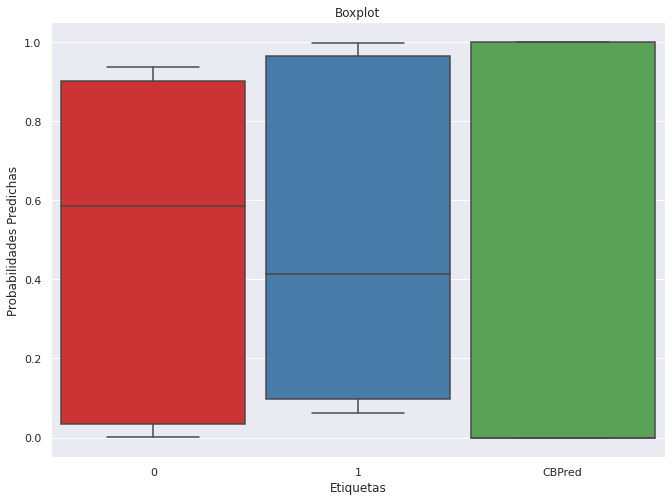

In [65]:
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.boxplot(y=stack_df["Probabilidades Predichas"], x=stack_df["Etiquetas"], linewidth=1.5,palette="Set1",color=".5",width=0.9,showfliers=False)
ax.set_title('Boxplot')

<AxesSubplot:ylabel='Frequency'>

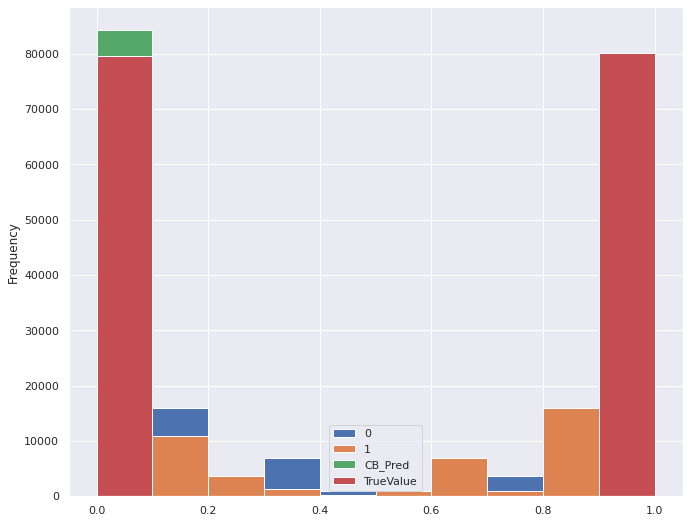

In [64]:
chedraui_cd.plot.hist(figsize=(11,9))

### Generamos resultados por SKU

In [40]:
submisstion = pd.DataFrame()
submisstion['SKU'] = X_val['SKU']
submisstion['Sem'] = X_val['Sem']
submisstion['Categoria'] = X_val['Categoria']
submisstion['TipoResurtible'] = X_val['TipoResurtible']
submisstion['Prediction'] = model.predict(X_val)
submisstion['Y_Faltante'] = y_val

In [41]:
submisstion

,SKU,Sem,Categoria,TipoResurtible,Prediction,Y_Faltante
0,3269530,25,JUGOS Y NÉCTARES,RL,0,0
2,3003153,25,PAÑALES,RC,1,1
3,3406681,25,FOCOS,RC,1,1
4,3657942,25,JABONES DE TOCADOR,RC,1,0
5,3269493,25,FOCOS,RC,1,1
...,...,...,...,...,...,...
842783,3005047,28,TOALLAS FEMENINAS,RC,0,0
842784,3004779,28,TOALLAS FEMENINAS,RC,1,1
842785,3298737,28,LIMPIEZA CALZADO,RC,1,1
842786,3724930,28,GALLETAS,RL,1,1


In [ ]:
submisstion.to_csv('Resumen_modelo_general_con_etiqueta_resurtible.csv',index=True)

## Graficamos el número de elementos en nuestros conjuntos de entrenamiento y validación. 

In [69]:
formatos_train = formatos_entrenamiento.to_dict()
formatos_val = formatos_validacion.to_dict()

<AxesSubplot:>

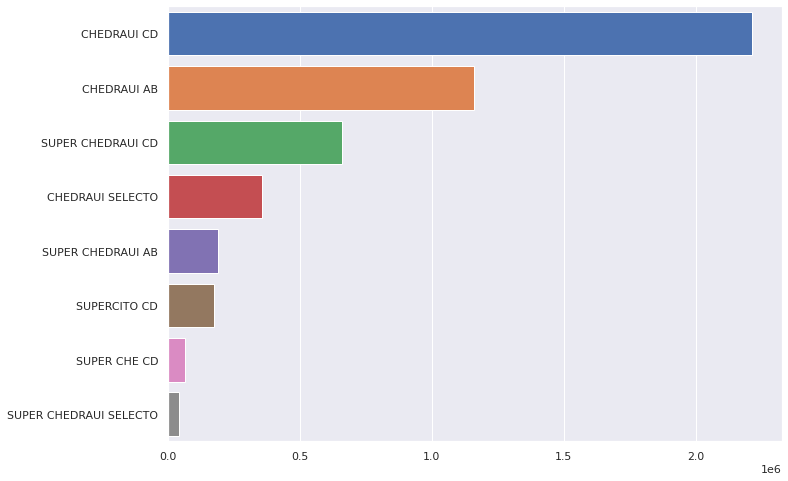

In [70]:
# Crea un histograma de frecuencias para el número de registros para entrenamiento por formato
keys = list(formatos_train.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(formatos_train[k]) for k in keys]
sns.barplot(x=vals, y=keys,ci=120,saturation=1.6)


<AxesSubplot:>

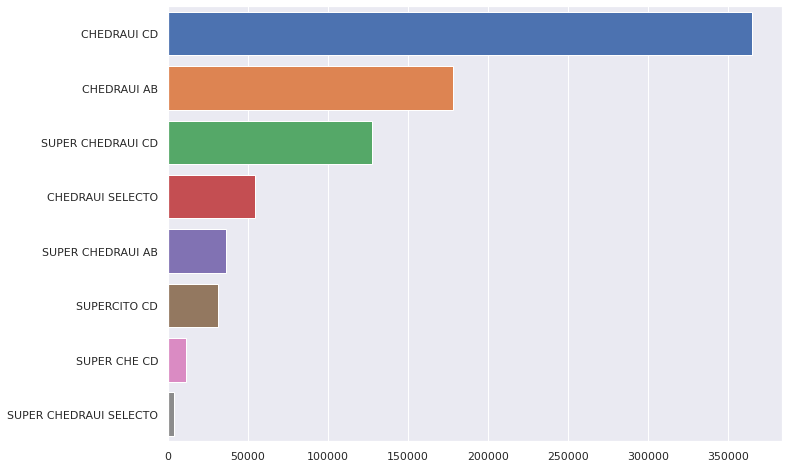

In [71]:
# Crea una histograma de frecuencias para el número de registros para validación y por formato
keys_val = list(formatos_val.keys())
# get values in the same order as keys, and parse percentage values
vals_val = [float(formatos_val[k]) for k in keys]
sns.barplot(x=vals_val, y=keys_val,ci=120,saturation=1.6)


<AxesSubplot:>

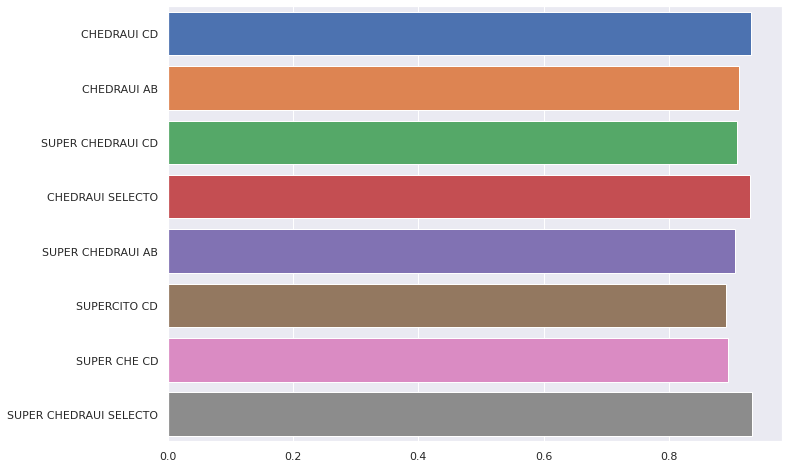

In [73]:
formatos_acc = resultados_formato[4] # Guarda un diccionario con la precisión
keys_acc = list(formatos_acc.keys())
# get values in the same order as keys, and parse percentage values
vals_acc = [float(formatos_acc[k]) for k in keys]
sns.barplot(x=vals_acc, y=keys_acc,ci=120,saturation=1.6)


In [ ]:
resultados_formato[1]

{'CHEDRAUI CD': 0.951054637031202,
 'CHEDRAUI AB': 0.941411841888462,
 'SUPER CHEDRAUI CD': 0.9549753115126315,
 'CHEDRAUI SELECTO': 0.8172821545176188,
 'SUPERCITO CD': 0.9479012828953222,
 'SUPER CHEDRAUI AB': 0.9447800764951322,
 'SUPER CHE CD': 0.9154574339152937,
 'SUPER CHEDRAUI SELECTO': 0.9145666618666557}

In [ ]:
resultados_formato[0]

['#####Calificaciones obtenidas para el formato 0 ########## \n',
 '\n',
 '\n',
 'Nombre de formato :  CHEDRAUI CD',
 'Accuracy: 0.951054637031202 \n',
 'True Positive Rate: 0.8675194620520112 \n',
 'Precision: 0.7674516534828681 \n',
 'Balanced accuracy: 0.9151886016466126 \n',
 'f1 score: 0.8144232509729388 \n',
 '\n',
 '\n',
 '#####Calificaciones obtenidas para el formato 1 ########## \n',
 '\n',
 '\n',
 'Nombre de formato :  CHEDRAUI AB',
 'Accuracy: 0.941411841888462 \n',
 'True Positive Rate: 0.8549913319849755 \n',
 'Precision: 0.7266708959194532 \n',
 'Balanced accuracy: 0.9044062696722008 \n',
 'f1 score: 0.7856257881811544 \n',
 '\n',
 '\n',
 '#####Calificaciones obtenidas para el formato 2 ########## \n',
 '\n',
 '\n',
 'Nombre de formato :  SUPER CHEDRAUI CD',
 'Accuracy: 0.9549753115126315 \n',
 'True Positive Rate: 0.8611104644395298 \n',
 'Precision: 0.7790109936396951 \n',
 'Balanced accuracy: 0.9142920580102174 \n',
 'f1 score: 0.8180059046629145 \n',
 '\n',
 '\n',
 '#

# Análisis por categorias 

In [74]:
chedraui_cd_train = data[data['FORMATO']=='CHEDRAUI CD']
chedraui_cd_val = data_val[data_val['FORMATO']=='CHEDRAUI CD']
X_train = chedraui_cd_train.drop('Y_Faltante',axis=1)
y_train = chedraui_cd_train.Y_Faltante
X_val = chedraui_cd_val.drop('Y_Faltante',axis=1)
y_val = chedraui_cd_val.Y_Faltante

In [75]:
model = CatBoostClassifier(
    l2_leaf_reg=int(1.0),
    custom_loss=[metrics.Accuracy()],
    random_seed=0,
    logging_level='Verbose', # Write 'Silent' instead of 'verbose'
    task_type='GPU',
    #iterations=190
)

In [76]:
model.fit(
    X_train, y_train,
    cat_features=indices_categoricos,
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6447367	test: 0.6430317	best: 0.6430317 (0)	total: 208ms	remaining: 3m 27s
1:	learn: 0.6023136	test: 0.6070912	best: 0.6070912 (1)	total: 463ms	remaining: 3m 51s
2:	learn: 0.5640190	test: 0.5685625	best: 0.5685625 (2)	total: 662ms	remaining: 3m 40s
3:	learn: 0.5297043	test: 0.5340854	best: 0.5340854 (3)	total: 856ms	remaining: 3m 33s
4:	learn: 0.4993232	test: 0.5033982	best: 0.5033982 (4)	total: 1.06s	remaining: 3m 31s
5:	learn: 0.4717001	test: 0.4765180	best: 0.4765180 (5)	total: 1.28s	remaining: 3m 31s
6:	learn: 0.4472283	test: 0.4516960	best: 0.4516960 (6)	total: 1.59s	remaining: 3m 45s
7:	learn: 0.4277813	test: 0.4325748	best: 0.4325748 (7)	total: 1.8s	remaining: 3m 43s
8:	learn: 0.4084645	test: 0.4129263	best: 0.4129263 (8)	total: 2.04s	remaining: 3m 44s
9:	learn: 0.3905892	test: 0.3950757	best: 0.3950757 (9)	total: 2.25s	remaining: 3m 42s
10:	learn: 0.3750780	test: 0.3792548	best: 0.3792548 (10)	total: 2.48s	remaining: 3m 42s
11:	learn: 0.3609441	test: 0.3645443	best:

In [77]:
print('Ago Model')
print('Tree count: {}'.format(model.tree_count_))
print('Accuracy: {:.5}'.format(accuracy_score(y_val, model.predict(X_val))))
print('True Positive Rate: {:.5}'.format(recall_score(y_val, model.predict(X_val))))
print('Precision: {:.5}'.format(precision_score(y_val, model.predict(X_val))))
print('Balanced Accuracy: {:.5}'.format(balanced_accuracy_score(y_val, model.predict(X_val))))
print('F1 Score: {:.5}'.format(f1_score(y_val, model.predict(X_val))))

Ago Model
Tree count: 60
Accuracy: 0.93106
True Positive Rate: 0.90394
Precision: 0.95616
Balanced Accuracy: 0.93114
F1 Score: 0.92932


In [22]:
def segmentador_formato(frame,cadena):
    arreglo = frame[frame['FORMATO']==cadena]
    return arreglo


def reporte_categorias(frame_val):
    l = len(frame_val['Categoria'].value_counts())
    categorias = frame_val['Categoria'].value_counts()
    def segmentador_categoria(frame_val,cadena):
        arreglo = frame_val[frame_val['Categoria']==cadena]
        return arreglo
    lineas = []
    dicionario_accuracy={}
    dicionario_balanced={}
    dicionario_f1 = {}
    dicionario_recall = {}
    for i in range(l):
        cadena = categorias.iloc[i:i+1].index[0]
        categoria_val = segmentador_categoria(frame_val,cadena)
        X_val = categoria_val.drop('Y_Faltante',axis=1)
        y_val = categoria_val.Y_Faltante
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val,y_pred)
        recall = recall_score(y_val,y_pred)
        precision = precision_score(y_val,y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
        f1 = f1_score(y_val,y_pred)
        lineas.append(f'#####Calificaciones obtenidas por la categoria {i} ########## \n')
        lineas.append(f'\n')
        lineas.append(f'\n')
        lineas.append(f'Categoria  :  ' + cadena)
        lineas.append(f'Accuracy: {accuracy} \n')
        lineas.append(f'True Positive Rate: {recall} \n')
        lineas.append(f'Precision: {precision} \n')
        lineas.append(f'Balanced accuracy: {balanced_accuracy} \n')
        lineas.append(f'f1 score: {f1} \n')
        lineas.append(f'\n')
        lineas.append(f'\n')
        dicionario_accuracy[cadena] = accuracy
        dicionario_balanced[cadena] = balanced_accuracy
        dicionario_f1[cadena] = f1
        dicionario_recall[cadena] = recall
    return [lineas,dicionario_accuracy,dicionario_balanced,dicionario_recall,dicionario_f1]

In [86]:
resultados_categoria = reporte_categorias(chedraui_cd_val)

/home/rlopez/anaconda3/envs/Algoritmo/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
chedraui_cd_train['Categoria'].value_counts()

FOCOS                        126677
CRISTALERIA                   79431
ARTÍCULOS DE COCCIÓN          72146
SHAMPOOS Y ACONDICIONADOR     66391
DULCES Y CHOCOLATES           63531
                              ...  
HUMEDAD                         111
BOTANA                           84
ACCESORIOS VINOS                 58
SOPAS CONDENSADAS                19
YOGURT GRANEL                    15
Name: Categoria, Length: 162, dtype: int64

In [88]:
chedraui_cd_val['Categoria'].value_counts()

FOCOS                        21362
CRISTALERIA                  12828
SHAMPOOS Y ACONDICIONADOR    11122
DULCES Y CHOCOLATES          10709
ARTÍCULOS DE COCCIÓN         10538
                             ...  
BOTANA                          29
HUMEDAD                         23
ACCESORIOS VINOS                14
YOGURT GRANEL                    4
SOPAS CONDENSADAS                3
Name: Categoria, Length: 162, dtype: int64

In [89]:
resultados_categoria[0]

['#####Calificaciones obtenidas por la categoria 0 ########## \n',
 '\n',
 '\n',
 'Categoria  :  FOCOS',
 'Accuracy: 0.9993914427488063 \n',
 'True Positive Rate: 1.0 \n',
 'Precision: 0.9993914427488063 \n',
 'Balanced accuracy: 0.5 \n',
 'f1 score: 0.9996956287607408 \n',
 '\n',
 '\n',
 '#####Calificaciones obtenidas por la categoria 1 ########## \n',
 '\n',
 '\n',
 'Categoria  :  CRISTALERIA',
 'Accuracy: 0.9999220455254132 \n',
 'True Positive Rate: 1.0 \n',
 'Precision: 0.9999220455254132 \n',
 'Balanced accuracy: 0.5 \n',
 'f1 score: 0.9999610212434223 \n',
 '\n',
 '\n',
 '#####Calificaciones obtenidas por la categoria 2 ########## \n',
 '\n',
 '\n',
 'Categoria  :  SHAMPOOS Y ACONDICIONADOR',
 'Accuracy: 0.9192591260564646 \n',
 'True Positive Rate: 0.8710182767624021 \n',
 'Precision: 0.8919786096256684 \n',
 'Balanced accuracy: 0.9078075475967797 \n',
 'f1 score: 0.8813738441215324 \n',
 '\n',
 '\n',
 '#####Calificaciones obtenidas por la categoria 3 ########## \n',
 '\n',
 '\

# Procedemos ahora a realizar un reporte de modelos por semana para un formato dado

In [23]:
def segmentador_semana(frame,semanas):
    arreglo = frame.loc[frame['Sem'].isin(semanas)]
    return arreglo 

# Vamos a tener que poner el formato manualmente y correr el loop de entrenamiento por semana.
def reporte_semana(frame,frame_val):
    l = len(frame['Sem'].value_counts())
    semanas = frame['Sem'].value_counts()
    lineas = []
    dict_acc = {}
    dict_balanced = {}
    dict_recall = {}
    dict_pre = {}
    dict_f1 = {}
    dict_graph = {}
    dict_frame = {}
    semanas_acumuladas = []
    for i in range(l):
        cadena = semanas.iloc[i:i+1].index[0]
        semanas_acumuladas.append(cadena)
        semana_train = segmentador_semana(frame,semanas_acumuladas)
        X_train = semana_train.drop('Y_Faltante',axis=1)
        y_train = semana_train.Y_Faltante
        X_val = frame_val.drop('Y_Faltante',axis=1)
        y_val = frame_val.Y_Faltante
        cat = CatBoostClassifier(
            l2_leaf_reg=int(2.0),
            custom_loss=[metrics.Accuracy()],
            random_seed=0,
            logging_level='Verbose',
            task_type='GPU',
            iterations=140
        )
        cat.fit(
            X_train,y_train,
            cat_features=indices_categoricos,
            eval_set=(X_val,y_val),
            logging_level='Verbose',
            plot=True
        );
        y_pred = cat.predict(X_val)
        accuracy = accuracy_score(y_val,y_pred)
        recall = recall_score(y_val,y_pred)
        precision = precision_score(y_val,y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
        f1 = f1_score(y_val,y_pred)
        l_train = len(X_train) 
        l_val = len(X_val)
        lineas.append(f'##### Número de semanas obtenidas en entrenamiento {i} ########## \n')
        lineas.append(f'\n')
        lineas.append(f'Numero de semana añadida:  ' + cadena)
        lineas.append(f'Numero de elementos en entrenamiento : {l_train} ')
        lineas.append(f'Numero de elementos en validación : {l_val} ')
        lineas.append(f'Precisión: {accuracy} \n')
        lineas.append(f'Precisión Balanceada: {balanced_accuracy} \n')
        lineas.append(f'Recall: {recall} \n')
        lineas.append(f'Precision: {precision} \n')
        lineas.append(f'Calificación F1: {f1} \n')
        lineas.append(f'\n')
        dict_acc[cadena]=accuracy
        dict_recall[cadena]=recall 
        dict_pre[cadena]=precision
        dict_balanced[cadena]=balanced_accuracy
        dict_f1[cadena]=f1
    return [lineas,dict_balanced,dict_acc,dict_recall,dict_pre,dict_f1]

### Vamos por Chedraui CD

In [24]:
chedraui_cd_train = segmentador_formato(data,'CHEDRAUI CD') 
chedraui_cd_val = segmentador_formato(data_val,'CHEDRAUI CD') 

In [ ]:
reporte_semana_chedrauicd = reporte_semana(chedraui_cd_train,chedraui_cd_val)

In [26]:
reporte_semana_chedrauicd[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  3',
 'Numero de elementos en entrenamiento : 119373 ',
 'Numero de elementos en validación : 365112 ',
 'Precisión: 0.9294928679418918 \n',
 'Precisión Balanceada: 0.9295686643996675 \n',
 'Recall: 0.9010385651302167 \n',
 'Precision: 0.9557882658383365 \n',
 'Calificación F1: 0.9276062508963798 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  10',
 'Numero de elementos en entrenamiento : 236768 ',
 'Numero de elementos en validación : 365112 ',
 'Precisión: 0.9297804509301255 \n',
 'Precisión Balanceada: 0.9298552525371018 \n',
 'Recall: 0.9016996192109964 \n',
 'Precision: 0.9557306897210657 \n',
 'Calificación F1: 0.9279292954848285 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  17',
 'Numero de elementos en entrenamiento : 352355 ',
 'Nu

# Chedraui AB

In [ ]:
chedraui_ab_train = segmentador_formato(data,'CHEDRAUI AB') 
chedraui_ab_val = segmentador_formato(data_val,'CHEDRAUI AB')
reporte_semana_chedrauiab = reporte_semana(chedraui_ab_train,chedraui_ab_val)

In [28]:
reporte_semana_chedrauiab[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  3',
 'Numero de elementos en entrenamiento : 84370 ',
 'Numero de elementos en validación : 178352 ',
 'Precisión: 0.9115569211447027 \n',
 'Precisión Balanceada: 0.911533465947912 \n',
 'Recall: 0.8650525630813073 \n',
 'Precision: 0.9536667120187016 \n',
 'Calificación F1: 0.9072008471584894 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  2',
 'Numero de elementos en entrenamiento : 155682 ',
 'Numero de elementos en validación : 178352 ',
 'Precisión: 0.9113999282318113 \n',
 'Precisión Balanceada: 0.9113765918277377 \n',
 'Recall: 0.8651310991686394 \n',
 'Precision: 0.9532580880444055 \n',
 'Calificación F1: 0.9070590864711625 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  17',
 'Numero de elementos en entrenamiento : 226788 ',
 'Numer

# Super Chedraui CD

In [ ]:
super_chedraui_cd_train = segmentador_formato(data,'SUPER CHEDRAUI CD') 
super_chedraui_cd_val = segmentador_formato(data_val,'SUPER CHEDRAUI CD')
reporte_semana_superchedrauicd = reporte_semana(super_chedraui_cd_train,super_chedraui_cd_val)

In [30]:
reporte_semana_superchedrauicd[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  2',
 'Numero de elementos en entrenamiento : 46471 ',
 'Numero de elementos en validación : 127397 ',
 'Precisión: 0.907179917894456 \n',
 'Precisión Balanceada: 0.9072166001525147 \n',
 'Recall: 0.8465255659977721 \n',
 'Precision: 0.9635165541626487 \n',
 'Calificación F1: 0.9012402388608175 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  12',
 'Numero de elementos en entrenamiento : 90237 ',
 'Numero de elementos en validación : 127397 ',
 'Precisión: 0.9073447569409013 \n',
 'Precisión Balanceada: 0.9073815673553773 \n',
 'Recall: 0.8464784975759763 \n',
 'Precision: 0.9639277482982259 \n',
 'Calificación F1: 0.9013933905837537 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  18',
 'Numero de elementos en entrenamiento : 130389 ',
 'Numer

# Chedraui Selecto

In [31]:
chedraui_selecto_train = segmentador_formato(data,'CHEDRAUI SELECTO') 
chedraui_selecto_val = segmentador_formato(data_val,'CHEDRAUI SELECTO')
reporte_semana_chedrauiselecto = reporte_semana(chedraui_selecto_train,chedraui_selecto_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6692014	test: 0.6782107	best: 0.6782107 (0)	total: 9.6ms	remaining: 1.33s
1:	learn: 0.6463444	test: 0.6563195	best: 0.6563195 (1)	total: 16.6ms	remaining: 1.15s
2:	learn: 0.6247496	test: 0.6353170	best: 0.6353170 (2)	total: 25.3ms	remaining: 1.16s
3:	learn: 0.6045556	test: 0.6171504	best: 0.6171504 (3)	total: 34.9ms	remaining: 1.19s
4:	learn: 0.5852702	test: 0.5992436	best: 0.5992436 (4)	total: 44.6ms	remaining: 1.21s
5:	learn: 0.5670039	test: 0.5818724	best: 0.5818724 (5)	total: 54.2ms	remaining: 1.21s
6:	learn: 0.5498084	test: 0.5667856	best: 0.5667856 (6)	total: 62.4ms	remaining: 1.19s
7:	learn: 0.5335572	test: 0.5512716	best: 0.5512716 (7)	total: 69.5ms	remaining: 1.15s
8:	learn: 0.5181216	test: 0.5364700	best: 0.5364700 (8)	total: 76.4ms	remaining: 1.11s
9:	learn: 0.5034143	test: 0.5222170	best: 0.5222170 (9)	total: 83.6ms	remaining: 1.09s
10:	learn: 0.4891972	test: 0.5089054	best: 0.5089054 (10)	total: 92.3ms	remaining: 1.08s
11:	learn: 0.4758813	test: 0.4965386	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6707560	test: 0.6840122	best: 0.6840122 (0)	total: 8.34ms	remaining: 1.16s
1:	learn: 0.6496402	test: 0.6725013	best: 0.6725013 (1)	total: 14.3ms	remaining: 986ms
2:	learn: 0.6296425	test: 0.6605484	best: 0.6605484 (2)	total: 20.3ms	remaining: 927ms
3:	learn: 0.6107922	test: 0.6530828	best: 0.6530828 (3)	total: 26.4ms	remaining: 898ms
4:	learn: 0.5929771	test: 0.6458218	best: 0.6458218 (4)	total: 32.4ms	remaining: 874ms
5:	learn: 0.5761379	test: 0.6391575	best: 0.6391575 (5)	total: 38.4ms	remaining: 857ms
6:	learn: 0.5606912	test: 0.6252851	best: 0.6252851 (6)	total: 44.3ms	remaining: 842ms
7:	learn: 0.5452513	test: 0.6196658	best: 0.6196658 (7)	total: 50.3ms	remaining: 831ms
8:	learn: 0.5306371	test: 0.6123704	best: 0.6123704 (8)	total: 56.4ms	remaining: 821ms
9:	learn: 0.5169983	test: 0.6000407	best: 0.6000407 (9)	total: 62.4ms	remaining: 811ms
10:	learn: 0.5039285	test: 0.5922812	best: 0.5922812 (10)	total: 68.4ms	remaining: 802ms
11:	learn: 0.4914845	test: 0.5873273	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6707818	test: 0.6788866	best: 0.6788866 (0)	total: 8.8ms	remaining: 1.22s
1:	learn: 0.6498246	test: 0.6629389	best: 0.6629389 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6299639	test: 0.6472916	best: 0.6472916 (2)	total: 22.7ms	remaining: 1.04s
3:	learn: 0.6111875	test: 0.6330780	best: 0.6330780 (3)	total: 29ms	remaining: 986ms
4:	learn: 0.5932907	test: 0.6188177	best: 0.6188177 (4)	total: 35.2ms	remaining: 952ms
5:	learn: 0.5765098	test: 0.6068502	best: 0.6068502 (5)	total: 41.5ms	remaining: 927ms
6:	learn: 0.5609676	test: 0.5917161	best: 0.5917161 (6)	total: 47.8ms	remaining: 908ms
7:	learn: 0.5457883	test: 0.5818340	best: 0.5818340 (7)	total: 54ms	remaining: 891ms
8:	learn: 0.5313333	test: 0.5708162	best: 0.5708162 (8)	total: 60.2ms	remaining: 877ms
9:	learn: 0.5177745	test: 0.5606311	best: 0.5606311 (9)	total: 66.3ms	remaining: 863ms
10:	learn: 0.5048276	test: 0.5517904	best: 0.5517904 (10)	total: 72.6ms	remaining: 851ms
11:	learn: 0.4925481	test: 0.5452780	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6708968	test: 0.6766037	best: 0.6766037 (0)	total: 8.38ms	remaining: 1.16s
1:	learn: 0.6500716	test: 0.6588961	best: 0.6588961 (1)	total: 16.5ms	remaining: 1.14s
2:	learn: 0.6300493	test: 0.6432170	best: 0.6432170 (2)	total: 22.8ms	remaining: 1.04s
3:	learn: 0.6112625	test: 0.6292840	best: 0.6292840 (3)	total: 28.9ms	remaining: 981ms
4:	learn: 0.5934453	test: 0.6155909	best: 0.6155909 (4)	total: 34.9ms	remaining: 942ms
5:	learn: 0.5765587	test: 0.6042436	best: 0.6042436 (5)	total: 41ms	remaining: 916ms
6:	learn: 0.5608737	test: 0.5876201	best: 0.5876201 (6)	total: 47.1ms	remaining: 896ms
7:	learn: 0.5456721	test: 0.5826359	best: 0.5826359 (7)	total: 53.7ms	remaining: 886ms
8:	learn: 0.5312883	test: 0.5719740	best: 0.5719740 (8)	total: 60.1ms	remaining: 874ms
9:	learn: 0.5176178	test: 0.5595966	best: 0.5595966 (9)	total: 66.9ms	remaining: 870ms
10:	learn: 0.5046388	test: 0.5478630	best: 0.5478630 (10)	total: 73.8ms	remaining: 866ms
11:	learn: 0.4925581	test: 0.5362183	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6714242	test: 0.6713326	best: 0.6713326 (0)	total: 8.5ms	remaining: 1.18s
1:	learn: 0.6508488	test: 0.6496909	best: 0.6496909 (1)	total: 16.3ms	remaining: 1.12s
2:	learn: 0.6315749	test: 0.6295803	best: 0.6295803 (2)	total: 24.6ms	remaining: 1.12s
3:	learn: 0.6132150	test: 0.6186344	best: 0.6186344 (3)	total: 32.2ms	remaining: 1.09s
4:	learn: 0.5958350	test: 0.6011581	best: 0.6011581 (4)	total: 38.8ms	remaining: 1.05s
5:	learn: 0.5795470	test: 0.5892187	best: 0.5892187 (5)	total: 45.5ms	remaining: 1.01s
6:	learn: 0.5639576	test: 0.5728675	best: 0.5728675 (6)	total: 52.1ms	remaining: 991ms
7:	learn: 0.5492845	test: 0.5572710	best: 0.5572710 (7)	total: 58.8ms	remaining: 970ms
8:	learn: 0.5352929	test: 0.5430620	best: 0.5430620 (8)	total: 65.5ms	remaining: 953ms
9:	learn: 0.5220351	test: 0.5290720	best: 0.5290720 (9)	total: 72.2ms	remaining: 939ms
10:	learn: 0.5093224	test: 0.5176931	best: 0.5176931 (10)	total: 78.8ms	remaining: 924ms
11:	learn: 0.4973752	test: 0.5053539	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6715857	test: 0.6761569	best: 0.6761569 (0)	total: 8.83ms	remaining: 1.23s
1:	learn: 0.6511517	test: 0.6545415	best: 0.6545415 (1)	total: 15.4ms	remaining: 1.06s
2:	learn: 0.6317446	test: 0.6344008	best: 0.6344008 (2)	total: 22ms	remaining: 1s
3:	learn: 0.6133505	test: 0.6209227	best: 0.6209227 (3)	total: 28.4ms	remaining: 965ms
4:	learn: 0.5959641	test: 0.6034322	best: 0.6034322 (4)	total: 34.8ms	remaining: 940ms
5:	learn: 0.5796270	test: 0.5926155	best: 0.5926155 (5)	total: 41.2ms	remaining: 921ms
6:	learn: 0.5641308	test: 0.5781838	best: 0.5781838 (6)	total: 47.6ms	remaining: 905ms
7:	learn: 0.5494271	test: 0.5627337	best: 0.5627337 (7)	total: 54.1ms	remaining: 892ms
8:	learn: 0.5352966	test: 0.5500328	best: 0.5500328 (8)	total: 60.8ms	remaining: 886ms
9:	learn: 0.5220446	test: 0.5358201	best: 0.5358201 (9)	total: 67.9ms	remaining: 882ms
10:	learn: 0.5095004	test: 0.5261661	best: 0.5261661 (10)	total: 74.8ms	remaining: 878ms
11:	learn: 0.4976287	test: 0.5135443	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6712745	test: 0.6710194	best: 0.6710194 (0)	total: 10.8ms	remaining: 1.49s
1:	learn: 0.6504493	test: 0.6497515	best: 0.6497515 (1)	total: 18.8ms	remaining: 1.29s
2:	learn: 0.6307300	test: 0.6295822	best: 0.6295822 (2)	total: 26.6ms	remaining: 1.21s
3:	learn: 0.6121682	test: 0.6105114	best: 0.6105114 (3)	total: 34.4ms	remaining: 1.17s
4:	learn: 0.5946180	test: 0.5931479	best: 0.5931479 (4)	total: 41.4ms	remaining: 1.12s
5:	learn: 0.5780401	test: 0.5767447	best: 0.5767447 (5)	total: 48.6ms	remaining: 1.08s
6:	learn: 0.5623043	test: 0.5617746	best: 0.5617746 (6)	total: 55.7ms	remaining: 1.06s
7:	learn: 0.5473741	test: 0.5461391	best: 0.5461391 (7)	total: 62.8ms	remaining: 1.03s
8:	learn: 0.5332253	test: 0.5321407	best: 0.5321407 (8)	total: 70ms	remaining: 1.02s
9:	learn: 0.5197658	test: 0.5183138	best: 0.5183138 (9)	total: 76.9ms	remaining: 1000ms
10:	learn: 0.5069947	test: 0.5057095	best: 0.5057095 (10)	total: 84ms	remaining: 985ms
11:	learn: 0.4948405	test: 0.4940346	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6710975	test: 0.6712009	best: 0.6712009 (0)	total: 8.97ms	remaining: 1.25s
1:	learn: 0.6502839	test: 0.6499321	best: 0.6499321 (1)	total: 16ms	remaining: 1.1s
2:	learn: 0.6305905	test: 0.6298065	best: 0.6298065 (2)	total: 22.9ms	remaining: 1.05s
3:	learn: 0.6119978	test: 0.6105716	best: 0.6105716 (3)	total: 29.9ms	remaining: 1.02s
4:	learn: 0.5944539	test: 0.5938835	best: 0.5938835 (4)	total: 36.8ms	remaining: 994ms
5:	learn: 0.5778190	test: 0.5773048	best: 0.5773048 (5)	total: 43.8ms	remaining: 978ms
6:	learn: 0.5620720	test: 0.5616097	best: 0.5616097 (6)	total: 50.4ms	remaining: 958ms
7:	learn: 0.5471505	test: 0.5461907	best: 0.5461907 (7)	total: 56.9ms	remaining: 939ms
8:	learn: 0.5330116	test: 0.5321698	best: 0.5321698 (8)	total: 63.5ms	remaining: 924ms
9:	learn: 0.5195491	test: 0.5181153	best: 0.5181153 (9)	total: 70.1ms	remaining: 911ms
10:	learn: 0.5067807	test: 0.5054573	best: 0.5054573 (10)	total: 76.6ms	remaining: 899ms
11:	learn: 0.4947127	test: 0.4931551	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6708738	test: 0.6711678	best: 0.6711678 (0)	total: 9.35ms	remaining: 1.3s
1:	learn: 0.6498633	test: 0.6498577	best: 0.6498577 (1)	total: 16.7ms	remaining: 1.15s
2:	learn: 0.6299879	test: 0.6296809	best: 0.6296809 (2)	total: 24.1ms	remaining: 1.1s
3:	learn: 0.6112175	test: 0.6106907	best: 0.6106907 (3)	total: 31.6ms	remaining: 1.07s
4:	learn: 0.5935170	test: 0.5939499	best: 0.5939499 (4)	total: 39.1ms	remaining: 1.05s
5:	learn: 0.5767187	test: 0.5772931	best: 0.5772931 (5)	total: 46.5ms	remaining: 1.04s
6:	learn: 0.5608601	test: 0.5607478	best: 0.5607478 (6)	total: 54ms	remaining: 1.02s
7:	learn: 0.5458046	test: 0.5449772	best: 0.5449772 (7)	total: 61ms	remaining: 1.01s
8:	learn: 0.5315086	test: 0.5309001	best: 0.5309001 (8)	total: 68ms	remaining: 990ms
9:	learn: 0.5179281	test: 0.5168440	best: 0.5168440 (9)	total: 74.9ms	remaining: 973ms
10:	learn: 0.5050326	test: 0.5041254	best: 0.5041254 (10)	total: 84.3ms	remaining: 988ms
11:	learn: 0.4927964	test: 0.4927100	best: 0.4927

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6712530	test: 0.6712021	best: 0.6712021 (0)	total: 8.68ms	remaining: 1.21s
1:	learn: 0.6503930	test: 0.6499370	best: 0.6499370 (1)	total: 15.4ms	remaining: 1.06s
2:	learn: 0.6306397	test: 0.6295746	best: 0.6295746 (2)	total: 22.3ms	remaining: 1.02s
3:	learn: 0.6119835	test: 0.6106335	best: 0.6106335 (3)	total: 30ms	remaining: 1.02s
4:	learn: 0.5943916	test: 0.5949491	best: 0.5949491 (4)	total: 37.1ms	remaining: 1s
5:	learn: 0.5776878	test: 0.5783497	best: 0.5783497 (5)	total: 44ms	remaining: 983ms
6:	learn: 0.5619240	test: 0.5625442	best: 0.5625442 (6)	total: 50.8ms	remaining: 965ms
7:	learn: 0.5469426	test: 0.5465491	best: 0.5465491 (7)	total: 57.9ms	remaining: 956ms
8:	learn: 0.5327437	test: 0.5324643	best: 0.5324643 (8)	total: 65.4ms	remaining: 951ms
9:	learn: 0.5192582	test: 0.5185955	best: 0.5185955 (9)	total: 72.5ms	remaining: 943ms
10:	learn: 0.5064627	test: 0.5058681	best: 0.5058681 (10)	total: 79.7ms	remaining: 934ms
11:	learn: 0.4943704	test: 0.4935362	best: 0.493

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6710744	test: 0.6713250	best: 0.6713250 (0)	total: 11ms	remaining: 1.53s
1:	learn: 0.6503791	test: 0.6506032	best: 0.6506032 (1)	total: 18.6ms	remaining: 1.28s
2:	learn: 0.6308265	test: 0.6304682	best: 0.6304682 (2)	total: 25.6ms	remaining: 1.17s
3:	learn: 0.6123889	test: 0.6112783	best: 0.6112783 (3)	total: 32.4ms	remaining: 1.1s
4:	learn: 0.5949072	test: 0.5938172	best: 0.5938172 (4)	total: 39.3ms	remaining: 1.06s
5:	learn: 0.5783216	test: 0.5772277	best: 0.5772277 (5)	total: 46.1ms	remaining: 1.03s
6:	learn: 0.5627342	test: 0.5614599	best: 0.5614599 (6)	total: 53.1ms	remaining: 1.01s
7:	learn: 0.5479379	test: 0.5465145	best: 0.5465145 (7)	total: 59.9ms	remaining: 989ms
8:	learn: 0.5338220	test: 0.5324178	best: 0.5324178 (8)	total: 66.8ms	remaining: 972ms
9:	learn: 0.5204861	test: 0.5183003	best: 0.5183003 (9)	total: 74.6ms	remaining: 970ms
10:	learn: 0.5077984	test: 0.5055973	best: 0.5055973 (10)	total: 81.8ms	remaining: 960ms
11:	learn: 0.4957545	test: 0.4938213	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6712896	test: 0.6718075	best: 0.6718075 (0)	total: 12.5ms	remaining: 1.74s
1:	learn: 0.6508343	test: 0.6506537	best: 0.6506537 (1)	total: 19.8ms	remaining: 1.36s
2:	learn: 0.6314495	test: 0.6305889	best: 0.6305889 (2)	total: 26.4ms	remaining: 1.21s
3:	learn: 0.6131871	test: 0.6121560	best: 0.6121560 (3)	total: 33.2ms	remaining: 1.13s
4:	learn: 0.5959028	test: 0.5949469	best: 0.5949469 (4)	total: 39.9ms	remaining: 1.08s
5:	learn: 0.5794663	test: 0.5783929	best: 0.5783929 (5)	total: 46.7ms	remaining: 1.04s
6:	learn: 0.5640396	test: 0.5625463	best: 0.5625463 (6)	total: 53.3ms	remaining: 1.01s
7:	learn: 0.5493653	test: 0.5475582	best: 0.5475582 (7)	total: 60.1ms	remaining: 992ms
8:	learn: 0.5353391	test: 0.5334506	best: 0.5334506 (8)	total: 67.1ms	remaining: 976ms
9:	learn: 0.5221283	test: 0.5193965	best: 0.5193965 (9)	total: 74.2ms	remaining: 964ms
10:	learn: 0.5094989	test: 0.5067403	best: 0.5067403 (10)	total: 81.8ms	remaining: 959ms
11:	learn: 0.4975496	test: 0.4951836	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717260	test: 0.6740476	best: 0.6740476 (0)	total: 9.72ms	remaining: 1.35s
1:	learn: 0.6513742	test: 0.6564798	best: 0.6564798 (1)	total: 16.5ms	remaining: 1.14s
2:	learn: 0.6323322	test: 0.6360491	best: 0.6360491 (2)	total: 24.3ms	remaining: 1.11s
3:	learn: 0.6141955	test: 0.6204986	best: 0.6204986 (3)	total: 31.4ms	remaining: 1.07s
4:	learn: 0.5970589	test: 0.6060968	best: 0.6060968 (4)	total: 38.4ms	remaining: 1.03s
5:	learn: 0.5809184	test: 0.5893954	best: 0.5893954 (5)	total: 45.4ms	remaining: 1.01s
6:	learn: 0.5656320	test: 0.5755566	best: 0.5755566 (6)	total: 52.2ms	remaining: 993ms
7:	learn: 0.5511116	test: 0.5629049	best: 0.5629049 (7)	total: 58.9ms	remaining: 972ms
8:	learn: 0.5374219	test: 0.5485013	best: 0.5485013 (8)	total: 65.7ms	remaining: 956ms
9:	learn: 0.5244121	test: 0.5339836	best: 0.5339836 (9)	total: 72.5ms	remaining: 942ms
10:	learn: 0.5119056	test: 0.5230502	best: 0.5230502 (10)	total: 79.1ms	remaining: 927ms
11:	learn: 0.5001975	test: 0.5117814	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717116	test: 0.6760692	best: 0.6760692 (0)	total: 8.97ms	remaining: 1.25s
1:	learn: 0.6514100	test: 0.6589975	best: 0.6589975 (1)	total: 16ms	remaining: 1.11s
2:	learn: 0.6321696	test: 0.6428030	best: 0.6428030 (2)	total: 23.3ms	remaining: 1.06s
3:	learn: 0.6140868	test: 0.6273674	best: 0.6273674 (3)	total: 30.4ms	remaining: 1.03s
4:	learn: 0.5968673	test: 0.6102207	best: 0.6102207 (4)	total: 37.4ms	remaining: 1.01s
5:	learn: 0.5806269	test: 0.5933223	best: 0.5933223 (5)	total: 44.4ms	remaining: 991ms
6:	learn: 0.5652414	test: 0.5791973	best: 0.5791973 (6)	total: 51.3ms	remaining: 974ms
7:	learn: 0.5506583	test: 0.5636664	best: 0.5636664 (7)	total: 58.2ms	remaining: 961ms
8:	learn: 0.5368402	test: 0.5499217	best: 0.5499217 (8)	total: 65.2ms	remaining: 949ms
9:	learn: 0.5236907	test: 0.5358708	best: 0.5358708 (9)	total: 72.1ms	remaining: 938ms
10:	learn: 0.5110413	test: 0.5250822	best: 0.5250822 (10)	total: 79.1ms	remaining: 928ms
11:	learn: 0.4991182	test: 0.5136538	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6714902	test: 0.6746737	best: 0.6746737 (0)	total: 8.94ms	remaining: 1.24s
1:	learn: 0.6512486	test: 0.6579148	best: 0.6579148 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6321289	test: 0.6377298	best: 0.6377298 (2)	total: 22.6ms	remaining: 1.03s
3:	learn: 0.6140133	test: 0.6229602	best: 0.6229602 (3)	total: 29.6ms	remaining: 1s
4:	learn: 0.5968342	test: 0.6086500	best: 0.6086500 (4)	total: 36.5ms	remaining: 986ms
5:	learn: 0.5806575	test: 0.5918384	best: 0.5918384 (5)	total: 43.5ms	remaining: 971ms
6:	learn: 0.5653471	test: 0.5775630	best: 0.5775630 (6)	total: 50.5ms	remaining: 959ms
7:	learn: 0.5507708	test: 0.5689124	best: 0.5689124 (7)	total: 57.5ms	remaining: 949ms
8:	learn: 0.5369044	test: 0.5550346	best: 0.5550346 (8)	total: 64.6ms	remaining: 940ms
9:	learn: 0.5237544	test: 0.5408790	best: 0.5408790 (9)	total: 71.3ms	remaining: 927ms
10:	learn: 0.5111834	test: 0.5296982	best: 0.5296982 (10)	total: 78.2ms	remaining: 917ms
11:	learn: 0.4993339	test: 0.5178796	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6714033	test: 0.6745648	best: 0.6745648 (0)	total: 9.71ms	remaining: 1.35s
1:	learn: 0.6510756	test: 0.6575806	best: 0.6575806 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6318946	test: 0.6374045	best: 0.6374045 (2)	total: 24.1ms	remaining: 1.1s
3:	learn: 0.6136493	test: 0.6217986	best: 0.6217986 (3)	total: 31.5ms	remaining: 1.07s
4:	learn: 0.5964194	test: 0.6073683	best: 0.6073683 (4)	total: 38.8ms	remaining: 1.05s
5:	learn: 0.5801525	test: 0.5935483	best: 0.5935483 (5)	total: 46ms	remaining: 1.03s
6:	learn: 0.5647594	test: 0.5794483	best: 0.5794483 (6)	total: 52.8ms	remaining: 1s
7:	learn: 0.5501539	test: 0.5642001	best: 0.5642001 (7)	total: 59ms	remaining: 973ms
8:	learn: 0.5362421	test: 0.5521818	best: 0.5521818 (8)	total: 65.8ms	remaining: 958ms
9:	learn: 0.5230220	test: 0.5384239	best: 0.5384239 (9)	total: 72ms	remaining: 936ms
10:	learn: 0.5104112	test: 0.5278584	best: 0.5278584 (10)	total: 78ms	remaining: 915ms
11:	learn: 0.4985764	test: 0.5158096	best: 0.5158096 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6715565	test: 0.6747098	best: 0.6747098 (0)	total: 9.36ms	remaining: 1.3s
1:	learn: 0.6513798	test: 0.6579828	best: 0.6579828 (1)	total: 16.7ms	remaining: 1.15s
2:	learn: 0.6322053	test: 0.6415558	best: 0.6415558 (2)	total: 24.2ms	remaining: 1.1s
3:	learn: 0.6140974	test: 0.6260615	best: 0.6260615 (3)	total: 32.1ms	remaining: 1.09s
4:	learn: 0.5970149	test: 0.6117448	best: 0.6117448 (4)	total: 39.8ms	remaining: 1.07s
5:	learn: 0.5808864	test: 0.5948744	best: 0.5948744 (5)	total: 47.3ms	remaining: 1.05s
6:	learn: 0.5656072	test: 0.5810581	best: 0.5810581 (6)	total: 54.7ms	remaining: 1.04s
7:	learn: 0.5510810	test: 0.5658199	best: 0.5658199 (7)	total: 62.2ms	remaining: 1.02s
8:	learn: 0.5373259	test: 0.5518020	best: 0.5518020 (8)	total: 69.7ms	remaining: 1.01s
9:	learn: 0.5242285	test: 0.5376597	best: 0.5376597 (9)	total: 77.2ms	remaining: 1s
10:	learn: 0.5117002	test: 0.5269334	best: 0.5269334 (10)	total: 85.1ms	remaining: 998ms
11:	learn: 0.4999180	test: 0.5154447	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717156	test: 0.6733979	best: 0.6733979 (0)	total: 9.47ms	remaining: 1.31s
1:	learn: 0.6514104	test: 0.6558175	best: 0.6558175 (1)	total: 17.1ms	remaining: 1.18s
2:	learn: 0.6322597	test: 0.6392718	best: 0.6392718 (2)	total: 25ms	remaining: 1.14s
3:	learn: 0.6141756	test: 0.6236529	best: 0.6236529 (3)	total: 32.5ms	remaining: 1.1s
4:	learn: 0.5970983	test: 0.6092177	best: 0.6092177 (4)	total: 39.7ms	remaining: 1.07s
5:	learn: 0.5809681	test: 0.5924218	best: 0.5924218 (5)	total: 47.6ms	remaining: 1.06s
6:	learn: 0.5657087	test: 0.5780551	best: 0.5780551 (6)	total: 55ms	remaining: 1.04s
7:	learn: 0.5512156	test: 0.5629233	best: 0.5629233 (7)	total: 62.3ms	remaining: 1.03s
8:	learn: 0.5375149	test: 0.5484747	best: 0.5484747 (8)	total: 69.6ms	remaining: 1.01s
9:	learn: 0.5244482	test: 0.5343718	best: 0.5343718 (9)	total: 76.8ms	remaining: 998ms
10:	learn: 0.5119480	test: 0.5236299	best: 0.5236299 (10)	total: 84ms	remaining: 985ms
11:	learn: 0.5001812	test: 0.5118722	best: 0.511

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6716980	test: 0.6733006	best: 0.6733006 (0)	total: 9.06ms	remaining: 1.26s
1:	learn: 0.6513658	test: 0.6558152	best: 0.6558152 (1)	total: 16.5ms	remaining: 1.14s
2:	learn: 0.6323086	test: 0.6356991	best: 0.6356991 (2)	total: 23.8ms	remaining: 1.09s
3:	learn: 0.6141887	test: 0.6200879	best: 0.6200879 (3)	total: 31.2ms	remaining: 1.06s
4:	learn: 0.5970854	test: 0.6058172	best: 0.6058172 (4)	total: 38.6ms	remaining: 1.04s
5:	learn: 0.5809422	test: 0.5890963	best: 0.5890963 (5)	total: 45.9ms	remaining: 1.02s
6:	learn: 0.5656754	test: 0.5749874	best: 0.5749874 (6)	total: 53.2ms	remaining: 1.01s
7:	learn: 0.5511722	test: 0.5599593	best: 0.5599593 (7)	total: 60.5ms	remaining: 998ms
8:	learn: 0.5374488	test: 0.5455711	best: 0.5455711 (8)	total: 67.7ms	remaining: 986ms
9:	learn: 0.5244461	test: 0.5311791	best: 0.5311791 (9)	total: 75.1ms	remaining: 976ms
10:	learn: 0.5119313	test: 0.5202271	best: 0.5202271 (10)	total: 82.4ms	remaining: 966ms
11:	learn: 0.5001530	test: 0.5084561	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6716414	test: 0.6733526	best: 0.6733526 (0)	total: 9.06ms	remaining: 1.26s
1:	learn: 0.6512739	test: 0.6558581	best: 0.6558581 (1)	total: 16.4ms	remaining: 1.13s
2:	learn: 0.6320601	test: 0.6393707	best: 0.6393707 (2)	total: 23.5ms	remaining: 1.07s
3:	learn: 0.6139180	test: 0.6238345	best: 0.6238345 (3)	total: 30.8ms	remaining: 1.05s
4:	learn: 0.5967919	test: 0.6095114	best: 0.6095114 (4)	total: 37.8ms	remaining: 1.02s
5:	learn: 0.5806094	test: 0.5926796	best: 0.5926796 (5)	total: 45ms	remaining: 1s
6:	learn: 0.5653207	test: 0.5783709	best: 0.5783709 (6)	total: 52.3ms	remaining: 994ms
7:	learn: 0.5507899	test: 0.5656812	best: 0.5656812 (7)	total: 59.5ms	remaining: 981ms
8:	learn: 0.5370384	test: 0.5511579	best: 0.5511579 (8)	total: 66.6ms	remaining: 970ms
9:	learn: 0.5240075	test: 0.5366070	best: 0.5366070 (9)	total: 74.2ms	remaining: 964ms
10:	learn: 0.5114908	test: 0.5255967	best: 0.5255967 (10)	total: 81.9ms	remaining: 961ms
11:	learn: 0.4997000	test: 0.5136357	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6716487	test: 0.6733670	best: 0.6733670 (0)	total: 8.87ms	remaining: 1.23s
1:	learn: 0.6514924	test: 0.6522894	best: 0.6522894 (1)	total: 16.2ms	remaining: 1.11s
2:	learn: 0.6322686	test: 0.6358491	best: 0.6358491 (2)	total: 23.6ms	remaining: 1.08s
3:	learn: 0.6141184	test: 0.6203979	best: 0.6203979 (3)	total: 31ms	remaining: 1.05s
4:	learn: 0.5969910	test: 0.6061290	best: 0.6061290 (4)	total: 37.9ms	remaining: 1.02s
5:	learn: 0.5808295	test: 0.5894090	best: 0.5894090 (5)	total: 44.7ms	remaining: 998ms
6:	learn: 0.5655305	test: 0.5751557	best: 0.5751557 (6)	total: 51.6ms	remaining: 981ms
7:	learn: 0.5510309	test: 0.5596695	best: 0.5596695 (7)	total: 58.5ms	remaining: 965ms
8:	learn: 0.5372088	test: 0.5477524	best: 0.5477524 (8)	total: 65.3ms	remaining: 951ms
9:	learn: 0.5241631	test: 0.5334924	best: 0.5334924 (9)	total: 72.2ms	remaining: 938ms
10:	learn: 0.5116153	test: 0.5230438	best: 0.5230438 (10)	total: 79ms	remaining: 927ms
11:	learn: 0.4998057	test: 0.5111776	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717082	test: 0.6733904	best: 0.6733904 (0)	total: 9.71ms	remaining: 1.35s
1:	learn: 0.6513978	test: 0.6558051	best: 0.6558051 (1)	total: 17ms	remaining: 1.18s
2:	learn: 0.6323336	test: 0.6357007	best: 0.6357007 (2)	total: 24.1ms	remaining: 1.1s
3:	learn: 0.6142369	test: 0.6201483	best: 0.6201483 (3)	total: 31.3ms	remaining: 1.06s
4:	learn: 0.5971602	test: 0.6059876	best: 0.6059876 (4)	total: 38.4ms	remaining: 1.04s
5:	learn: 0.5810218	test: 0.5892668	best: 0.5892668 (5)	total: 45.6ms	remaining: 1.02s
6:	learn: 0.5657733	test: 0.5753243	best: 0.5753243 (6)	total: 52.9ms	remaining: 1s
7:	learn: 0.5512076	test: 0.5629643	best: 0.5629643 (7)	total: 60.2ms	remaining: 993ms
8:	learn: 0.5373869	test: 0.5512742	best: 0.5512742 (8)	total: 67.5ms	remaining: 982ms
9:	learn: 0.5243914	test: 0.5368658	best: 0.5368658 (9)	total: 74.5ms	remaining: 969ms
10:	learn: 0.5119020	test: 0.5258785	best: 0.5258785 (10)	total: 81.4ms	remaining: 955ms
11:	learn: 0.5001346	test: 0.5142275	best: 0.51

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717628	test: 0.6712696	best: 0.6712696 (0)	total: 9.55ms	remaining: 1.33s
1:	learn: 0.6516666	test: 0.6502680	best: 0.6502680 (1)	total: 17.2ms	remaining: 1.19s
2:	learn: 0.6326122	test: 0.6303626	best: 0.6303626 (2)	total: 24.8ms	remaining: 1.13s
3:	learn: 0.6145889	test: 0.6124932	best: 0.6124932 (3)	total: 32.4ms	remaining: 1.1s
4:	learn: 0.5975811	test: 0.5974324	best: 0.5974324 (4)	total: 40ms	remaining: 1.08s
5:	learn: 0.5814488	test: 0.5809460	best: 0.5809460 (5)	total: 47.6ms	remaining: 1.06s
6:	learn: 0.5662032	test: 0.5666401	best: 0.5666401 (6)	total: 55.3ms	remaining: 1.05s
7:	learn: 0.5517314	test: 0.5517407	best: 0.5517407 (7)	total: 62.9ms	remaining: 1.04s
8:	learn: 0.5380196	test: 0.5375930	best: 0.5375930 (8)	total: 70.6ms	remaining: 1.03s
9:	learn: 0.5250383	test: 0.5234853	best: 0.5234853 (9)	total: 78.3ms	remaining: 1.02s
10:	learn: 0.5126432	test: 0.5109009	best: 0.5109009 (10)	total: 85.8ms	remaining: 1.01s
11:	learn: 0.5009054	test: 0.4995782	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717343	test: 0.6712607	best: 0.6712607 (0)	total: 9.25ms	remaining: 1.29s
1:	learn: 0.6516031	test: 0.6502515	best: 0.6502515 (1)	total: 17ms	remaining: 1.18s
2:	learn: 0.6325459	test: 0.6303376	best: 0.6303376 (2)	total: 24.1ms	remaining: 1.1s
3:	learn: 0.6144943	test: 0.6124619	best: 0.6124619 (3)	total: 31ms	remaining: 1.05s
4:	learn: 0.5974716	test: 0.5974100	best: 0.5974100 (4)	total: 38.9ms	remaining: 1.05s
5:	learn: 0.5813379	test: 0.5809247	best: 0.5809247 (5)	total: 46.1ms	remaining: 1.03s
6:	learn: 0.5660761	test: 0.5664843	best: 0.5664843 (6)	total: 53.1ms	remaining: 1.01s
7:	learn: 0.5515525	test: 0.5520456	best: 0.5520456 (7)	total: 60.2ms	remaining: 994ms
8:	learn: 0.5378286	test: 0.5379046	best: 0.5379046 (8)	total: 67.3ms	remaining: 980ms
9:	learn: 0.5248262	test: 0.5239734	best: 0.5239734 (9)	total: 74.5ms	remaining: 968ms
10:	learn: 0.5124497	test: 0.5113208	best: 0.5113208 (10)	total: 81.6ms	remaining: 958ms
11:	learn: 0.5007163	test: 0.4997541	best: 0.4

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6717382	test: 0.6712546	best: 0.6712546 (0)	total: 9.47ms	remaining: 1.32s
1:	learn: 0.6516114	test: 0.6502460	best: 0.6502460 (1)	total: 16.6ms	remaining: 1.15s
2:	learn: 0.6325550	test: 0.6302684	best: 0.6302684 (2)	total: 23.6ms	remaining: 1.08s
3:	learn: 0.6145131	test: 0.6124285	best: 0.6124285 (3)	total: 30.5ms	remaining: 1.04s
4:	learn: 0.5974932	test: 0.5973714	best: 0.5973714 (4)	total: 37.5ms	remaining: 1.01s
5:	learn: 0.5813450	test: 0.5808802	best: 0.5808802 (5)	total: 44.5ms	remaining: 993ms
6:	learn: 0.5660860	test: 0.5667450	best: 0.5667450 (6)	total: 51.5ms	remaining: 978ms
7:	learn: 0.5515978	test: 0.5518871	best: 0.5518871 (7)	total: 58.4ms	remaining: 964ms
8:	learn: 0.5378816	test: 0.5377334	best: 0.5377334 (8)	total: 65.4ms	remaining: 952ms
9:	learn: 0.5248111	test: 0.5236308	best: 0.5236308 (9)	total: 72.3ms	remaining: 940ms
10:	learn: 0.5124061	test: 0.5109382	best: 0.5109382 (10)	total: 79.2ms	remaining: 929ms
11:	learn: 0.5006526	test: 0.4995700	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6716783	test: 0.6791421	best: 0.6791421 (0)	total: 9.62ms	remaining: 1.34s
1:	learn: 0.6515860	test: 0.6579480	best: 0.6579480 (1)	total: 17.3ms	remaining: 1.2s
2:	learn: 0.6325347	test: 0.6378111	best: 0.6378111 (2)	total: 24.7ms	remaining: 1.13s
3:	learn: 0.6145296	test: 0.6197152	best: 0.6197152 (3)	total: 31.8ms	remaining: 1.08s
4:	learn: 0.5975235	test: 0.6053113	best: 0.6053113 (4)	total: 38.7ms	remaining: 1.04s
5:	learn: 0.5813917	test: 0.5885945	best: 0.5885945 (5)	total: 45.8ms	remaining: 1.02s
6:	learn: 0.5661390	test: 0.5746639	best: 0.5746639 (6)	total: 52.8ms	remaining: 1s
7:	learn: 0.5516303	test: 0.5655775	best: 0.5655775 (7)	total: 59.8ms	remaining: 987ms
8:	learn: 0.5379366	test: 0.5510896	best: 0.5510896 (8)	total: 67.3ms	remaining: 980ms
9:	learn: 0.5249584	test: 0.5365373	best: 0.5365373 (9)	total: 74.9ms	remaining: 974ms
10:	learn: 0.5125486	test: 0.5235805	best: 0.5235805 (10)	total: 81.8ms	remaining: 960ms
11:	learn: 0.5007913	test: 0.5116098	best: 0.

In [32]:
reporte_semana_chedrauiselecto[0] 

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  9',
 'Numero de elementos en entrenamiento : 30067 ',
 'Numero de elementos en validación : 54428 ',
 'Precisión: 0.9295766884691703 \n',
 'Precisión Balanceada: 0.9295743037411818 \n',
 'Recall: 0.9079416412480247 \n',
 'Precision: 0.9489897825919951 \n',
 'Calificación F1: 0.9280120199079726 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  12',
 'Numero de elementos en entrenamiento : 59097 ',
 'Numero de elementos en validación : 54428 ',
 'Precisión: 0.8645182626589255 \n',
 'Precisión Balanceada: 0.8645251270504968 \n',
 'Recall: 0.9267943111241778 \n',
 'Precision: 0.8241233946603053 \n',
 'Calificación F1: 0.8724486265827164 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  5',
 'Numero de elementos en entrenamiento : 86697 ',
 'Numero d

# Super chedraui ab

In [33]:
super_chedraui_ab_train = segmentador_formato(data,'SUPER CHEDRAUI AB') 
super_chedraui_ab_val = segmentador_formato(data_val,'SUPER CHEDRAUI AB')
reporte_semana_superchedrauiab = reporte_semana(super_chedraui_ab_train,super_chedraui_ab_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6716741	test: 0.6728208	best: 0.6728208 (0)	total: 8.29ms	remaining: 1.15s
1:	learn: 0.6512447	test: 0.6529158	best: 0.6529158 (1)	total: 14.3ms	remaining: 986ms
2:	learn: 0.6321922	test: 0.6343047	best: 0.6343047 (2)	total: 20.5ms	remaining: 935ms
3:	learn: 0.6141088	test: 0.6173093	best: 0.6173093 (3)	total: 26.5ms	remaining: 902ms
4:	learn: 0.5967899	test: 0.6011984	best: 0.6011984 (4)	total: 32.5ms	remaining: 877ms
5:	learn: 0.5804409	test: 0.5860683	best: 0.5860683 (5)	total: 38.5ms	remaining: 859ms
6:	learn: 0.5650851	test: 0.5717607	best: 0.5717607 (6)	total: 45.3ms	remaining: 861ms
7:	learn: 0.5506535	test: 0.5583520	best: 0.5583520 (7)	total: 52.9ms	remaining: 873ms
8:	learn: 0.5374121	test: 0.5453157	best: 0.5453157 (8)	total: 60ms	remaining: 874ms
9:	learn: 0.5243582	test: 0.5334779	best: 0.5334779 (9)	total: 67.2ms	remaining: 873ms
10:	learn: 0.5117652	test: 0.5219943	best: 0.5219943 (10)	total: 73.9ms	remaining: 867ms
11:	learn: 0.4998354	test: 0.5104943	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6726289	test: 0.6732166	best: 0.6732166 (0)	total: 6.8ms	remaining: 945ms
1:	learn: 0.6529184	test: 0.6567308	best: 0.6567308 (1)	total: 13.4ms	remaining: 923ms
2:	learn: 0.6344393	test: 0.6383922	best: 0.6383922 (2)	total: 20.6ms	remaining: 942ms
3:	learn: 0.6167394	test: 0.6209625	best: 0.6209625 (3)	total: 27.1ms	remaining: 921ms
4:	learn: 0.5995529	test: 0.6045661	best: 0.6045661 (4)	total: 34.6ms	remaining: 935ms
5:	learn: 0.5835768	test: 0.5890495	best: 0.5890495 (5)	total: 41.5ms	remaining: 928ms
6:	learn: 0.5680036	test: 0.5743728	best: 0.5743728 (6)	total: 48ms	remaining: 912ms
7:	learn: 0.5534852	test: 0.5608705	best: 0.5608705 (7)	total: 55ms	remaining: 907ms
8:	learn: 0.5399733	test: 0.5479338	best: 0.5479338 (8)	total: 62.1ms	remaining: 903ms
9:	learn: 0.5265302	test: 0.5354812	best: 0.5354812 (9)	total: 68.9ms	remaining: 896ms
10:	learn: 0.5141800	test: 0.5234382	best: 0.5234382 (10)	total: 75.7ms	remaining: 888ms
11:	learn: 0.5027780	test: 0.5123246	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6723572	test: 0.6731473	best: 0.6731473 (0)	total: 7.1ms	remaining: 987ms
1:	learn: 0.6524896	test: 0.6554388	best: 0.6554388 (1)	total: 13.6ms	remaining: 937ms
2:	learn: 0.6337231	test: 0.6366225	best: 0.6366225 (2)	total: 20.1ms	remaining: 920ms
3:	learn: 0.6152345	test: 0.6194659	best: 0.6194659 (3)	total: 26.7ms	remaining: 908ms
4:	learn: 0.5986352	test: 0.6031854	best: 0.6031854 (4)	total: 33.7ms	remaining: 909ms
5:	learn: 0.5822049	test: 0.5878552	best: 0.5878552 (5)	total: 40.3ms	remaining: 899ms
6:	learn: 0.5672997	test: 0.5736478	best: 0.5736478 (6)	total: 47ms	remaining: 894ms
7:	learn: 0.5527031	test: 0.5600321	best: 0.5600321 (7)	total: 54.4ms	remaining: 897ms
8:	learn: 0.5391014	test: 0.5459620	best: 0.5459620 (8)	total: 60.9ms	remaining: 886ms
9:	learn: 0.5264117	test: 0.5339197	best: 0.5339197 (9)	total: 66.5ms	remaining: 864ms
10:	learn: 0.5142109	test: 0.5216276	best: 0.5216276 (10)	total: 72.9ms	remaining: 855ms
11:	learn: 0.5025630	test: 0.5106171	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6724017	test: 0.6731140	best: 0.6731140 (0)	total: 7.26ms	remaining: 1.01s
1:	learn: 0.6525714	test: 0.6534998	best: 0.6534998 (1)	total: 14ms	remaining: 967ms
2:	learn: 0.6338552	test: 0.6350561	best: 0.6350561 (2)	total: 20.4ms	remaining: 929ms
3:	learn: 0.6155357	test: 0.6179561	best: 0.6179561 (3)	total: 26.8ms	remaining: 910ms
4:	learn: 0.5989016	test: 0.6014023	best: 0.6014023 (4)	total: 33.1ms	remaining: 894ms
5:	learn: 0.5825264	test: 0.5861440	best: 0.5861440 (5)	total: 39.5ms	remaining: 881ms
6:	learn: 0.5675077	test: 0.5869824	best: 0.5861440 (5)	total: 45.8ms	remaining: 871ms
7:	learn: 0.5529061	test: 0.5728631	best: 0.5728631 (7)	total: 52.2ms	remaining: 862ms
8:	learn: 0.5393053	test: 0.5591028	best: 0.5591028 (8)	total: 58.5ms	remaining: 852ms
9:	learn: 0.5266703	test: 0.5466461	best: 0.5466461 (9)	total: 63.9ms	remaining: 830ms
10:	learn: 0.5145042	test: 0.5341831	best: 0.5341831 (10)	total: 70.3ms	remaining: 825ms
11:	learn: 0.5028581	test: 0.5227024	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720793	test: 0.6727612	best: 0.6727612 (0)	total: 9.47ms	remaining: 1.32s
1:	learn: 0.6521281	test: 0.6532386	best: 0.6532386 (1)	total: 16.4ms	remaining: 1.13s
2:	learn: 0.6333063	test: 0.6346943	best: 0.6346943 (2)	total: 23.2ms	remaining: 1.06s
3:	learn: 0.6155599	test: 0.6176014	best: 0.6176014 (3)	total: 29.6ms	remaining: 1.01s
4:	learn: 0.5988082	test: 0.6016654	best: 0.6016654 (4)	total: 36ms	remaining: 971ms
5:	learn: 0.5831137	test: 0.5869917	best: 0.5869917 (5)	total: 42.3ms	remaining: 945ms
6:	learn: 0.5679900	test: 0.5727304	best: 0.5727304 (6)	total: 48.6ms	remaining: 924ms
7:	learn: 0.5536713	test: 0.5590330	best: 0.5590330 (7)	total: 55ms	remaining: 908ms
8:	learn: 0.5401745	test: 0.5463352	best: 0.5463352 (8)	total: 61.4ms	remaining: 893ms
9:	learn: 0.5273445	test: 0.5341500	best: 0.5341500 (9)	total: 67.8ms	remaining: 881ms
10:	learn: 0.5149985	test: 0.5225968	best: 0.5225968 (10)	total: 74.2ms	remaining: 870ms
11:	learn: 0.5033746	test: 0.5113167	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6719624	test: 0.6731941	best: 0.6731941 (0)	total: 9.47ms	remaining: 1.32s
1:	learn: 0.6519480	test: 0.6538183	best: 0.6538183 (1)	total: 17.4ms	remaining: 1.2s
2:	learn: 0.6331355	test: 0.6354174	best: 0.6354174 (2)	total: 25.3ms	remaining: 1.16s
3:	learn: 0.6153920	test: 0.6190920	best: 0.6190920 (3)	total: 32.5ms	remaining: 1.1s
4:	learn: 0.5985771	test: 0.6030488	best: 0.6030488 (4)	total: 39.1ms	remaining: 1.05s
5:	learn: 0.5828481	test: 0.5880969	best: 0.5880969 (5)	total: 45.9ms	remaining: 1.02s
6:	learn: 0.5677334	test: 0.5736097	best: 0.5736097 (6)	total: 52.5ms	remaining: 997ms
7:	learn: 0.5531419	test: 0.5599310	best: 0.5599310 (7)	total: 59.1ms	remaining: 975ms
8:	learn: 0.5395693	test: 0.5469808	best: 0.5469808 (8)	total: 65.8ms	remaining: 958ms
9:	learn: 0.5266929	test: 0.5348136	best: 0.5348136 (9)	total: 74.3ms	remaining: 966ms
10:	learn: 0.5143185	test: 0.5232565	best: 0.5232565 (10)	total: 81.2ms	remaining: 953ms
11:	learn: 0.5026929	test: 0.5122102	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6722157	test: 0.6729945	best: 0.6729945 (0)	total: 9.31ms	remaining: 1.29s
1:	learn: 0.6524777	test: 0.6527242	best: 0.6527242 (1)	total: 16ms	remaining: 1.1s
2:	learn: 0.6338715	test: 0.6346799	best: 0.6346799 (2)	total: 22.7ms	remaining: 1.03s
3:	learn: 0.6164588	test: 0.6180639	best: 0.6180639 (3)	total: 29.3ms	remaining: 996ms
4:	learn: 0.5996790	test: 0.6023971	best: 0.6023971 (4)	total: 36.6ms	remaining: 989ms
5:	learn: 0.5835893	test: 0.5873346	best: 0.5873346 (5)	total: 43.6ms	remaining: 973ms
6:	learn: 0.5686927	test: 0.5731076	best: 0.5731076 (6)	total: 50.3ms	remaining: 956ms
7:	learn: 0.5542185	test: 0.5596256	best: 0.5596256 (7)	total: 57.2ms	remaining: 944ms
8:	learn: 0.5408128	test: 0.5464134	best: 0.5464134 (8)	total: 64.7ms	remaining: 942ms
9:	learn: 0.5280644	test: 0.5343097	best: 0.5343097 (9)	total: 72ms	remaining: 936ms
10:	learn: 0.5158467	test: 0.5229052	best: 0.5229052 (10)	total: 79.3ms	remaining: 930ms
11:	learn: 0.5044285	test: 0.5147536	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6724963	test: 0.6734150	best: 0.6734150 (0)	total: 8.52ms	remaining: 1.18s
1:	learn: 0.6530232	test: 0.6537629	best: 0.6537629 (1)	total: 14.8ms	remaining: 1.02s
2:	learn: 0.6346802	test: 0.6353728	best: 0.6353728 (2)	total: 21ms	remaining: 960ms
3:	learn: 0.6174527	test: 0.6186555	best: 0.6186555 (3)	total: 27.8ms	remaining: 944ms
4:	learn: 0.6009286	test: 0.6030576	best: 0.6030576 (4)	total: 34.5ms	remaining: 931ms
5:	learn: 0.5853030	test: 0.5887706	best: 0.5887706 (5)	total: 40.7ms	remaining: 909ms
6:	learn: 0.5706831	test: 0.5751087	best: 0.5751087 (6)	total: 46.9ms	remaining: 891ms
7:	learn: 0.5567354	test: 0.5614803	best: 0.5614803 (7)	total: 53.2ms	remaining: 878ms
8:	learn: 0.5435073	test: 0.5482352	best: 0.5482352 (8)	total: 59.4ms	remaining: 864ms
9:	learn: 0.5309048	test: 0.5359253	best: 0.5359253 (9)	total: 65.6ms	remaining: 853ms
10:	learn: 0.5189262	test: 0.5245046	best: 0.5245046 (10)	total: 71.8ms	remaining: 842ms
11:	learn: 0.5076674	test: 0.5145111	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6724510	test: 0.6729239	best: 0.6729239 (0)	total: 8.58ms	remaining: 1.19s
1:	learn: 0.6528962	test: 0.6534521	best: 0.6534521 (1)	total: 15.1ms	remaining: 1.04s
2:	learn: 0.6345017	test: 0.6351439	best: 0.6351439 (2)	total: 21.4ms	remaining: 978ms
3:	learn: 0.6172890	test: 0.6183577	best: 0.6183577 (3)	total: 29ms	remaining: 987ms
4:	learn: 0.6005348	test: 0.6024085	best: 0.6024085 (4)	total: 36.1ms	remaining: 973ms
5:	learn: 0.5847983	test: 0.5873623	best: 0.5873623 (5)	total: 42.6ms	remaining: 951ms
6:	learn: 0.5700296	test: 0.5729657	best: 0.5729657 (6)	total: 49ms	remaining: 931ms
7:	learn: 0.5557762	test: 0.5594955	best: 0.5594955 (7)	total: 55.7ms	remaining: 919ms
8:	learn: 0.5425205	test: 0.5466294	best: 0.5466294 (8)	total: 62.5ms	remaining: 910ms
9:	learn: 0.5298859	test: 0.5341280	best: 0.5341280 (9)	total: 69ms	remaining: 896ms
10:	learn: 0.5179016	test: 0.5227460	best: 0.5227460 (10)	total: 75.4ms	remaining: 884ms
11:	learn: 0.5066149	test: 0.5126038	best: 0.51

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6724580	test: 0.6729517	best: 0.6729517 (0)	total: 8.71ms	remaining: 1.21s
1:	learn: 0.6529451	test: 0.6533919	best: 0.6533919 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6345646	test: 0.6354409	best: 0.6354409 (2)	total: 24.3ms	remaining: 1.11s
3:	learn: 0.6172116	test: 0.6181226	best: 0.6181226 (3)	total: 30.9ms	remaining: 1.05s
4:	learn: 0.6008651	test: 0.6024148	best: 0.6024148 (4)	total: 37.7ms	remaining: 1.02s
5:	learn: 0.5853145	test: 0.5873922	best: 0.5873922 (5)	total: 44.4ms	remaining: 992ms
6:	learn: 0.5706055	test: 0.5730781	best: 0.5730781 (6)	total: 51ms	remaining: 969ms
7:	learn: 0.5566678	test: 0.5591815	best: 0.5591815 (7)	total: 57.6ms	remaining: 950ms
8:	learn: 0.5433990	test: 0.5464330	best: 0.5464330 (8)	total: 64.1ms	remaining: 933ms
9:	learn: 0.5307839	test: 0.5340713	best: 0.5340713 (9)	total: 70.9ms	remaining: 921ms
10:	learn: 0.5188042	test: 0.5225130	best: 0.5225130 (10)	total: 77.5ms	remaining: 909ms
11:	learn: 0.5075707	test: 0.5116930	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6722872	test: 0.6730139	best: 0.6730139 (0)	total: 8.35ms	remaining: 1.16s
1:	learn: 0.6525897	test: 0.6533413	best: 0.6533413 (1)	total: 14.8ms	remaining: 1.02s
2:	learn: 0.6339899	test: 0.6353280	best: 0.6353280 (2)	total: 21.6ms	remaining: 986ms
3:	learn: 0.6165510	test: 0.6183895	best: 0.6183895 (3)	total: 28.4ms	remaining: 967ms
4:	learn: 0.6000074	test: 0.6021977	best: 0.6021977 (4)	total: 35ms	remaining: 946ms
5:	learn: 0.5843073	test: 0.5871020	best: 0.5871020 (5)	total: 42.3ms	remaining: 944ms
6:	learn: 0.5694675	test: 0.5729043	best: 0.5729043 (6)	total: 48.8ms	remaining: 927ms
7:	learn: 0.5553640	test: 0.5587368	best: 0.5587368 (7)	total: 55.5ms	remaining: 916ms
8:	learn: 0.5420548	test: 0.5459161	best: 0.5459161 (8)	total: 62.1ms	remaining: 904ms
9:	learn: 0.5294943	test: 0.5336156	best: 0.5336156 (9)	total: 68.5ms	remaining: 890ms
10:	learn: 0.5173347	test: 0.5221452	best: 0.5221452 (10)	total: 74.8ms	remaining: 878ms
11:	learn: 0.5059975	test: 0.5109693	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6721338	test: 0.6728386	best: 0.6728386 (0)	total: 9.81ms	remaining: 1.36s
1:	learn: 0.6523061	test: 0.6529662	best: 0.6529662 (1)	total: 16.9ms	remaining: 1.16s
2:	learn: 0.6335843	test: 0.6346217	best: 0.6346217 (2)	total: 24ms	remaining: 1.1s
3:	learn: 0.6159484	test: 0.6175750	best: 0.6175750 (3)	total: 31.1ms	remaining: 1.06s
4:	learn: 0.5993351	test: 0.6017288	best: 0.6017288 (4)	total: 38.3ms	remaining: 1.03s
5:	learn: 0.5835399	test: 0.5865996	best: 0.5865996 (5)	total: 45.8ms	remaining: 1.02s
6:	learn: 0.5686098	test: 0.5720387	best: 0.5720387 (6)	total: 53.3ms	remaining: 1.01s
7:	learn: 0.5544205	test: 0.5581827	best: 0.5581827 (7)	total: 60.8ms	remaining: 1s
8:	learn: 0.5409747	test: 0.5452528	best: 0.5452528 (8)	total: 68.5ms	remaining: 997ms
9:	learn: 0.5281619	test: 0.5329442	best: 0.5329442 (9)	total: 76ms	remaining: 989ms
10:	learn: 0.5159991	test: 0.5213408	best: 0.5213408 (10)	total: 83.4ms	remaining: 979ms
11:	learn: 0.5046131	test: 0.5097910	best: 0.5097

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6721994	test: 0.6728825	best: 0.6728825 (0)	total: 8.56ms	remaining: 1.19s
1:	learn: 0.6523919	test: 0.6535028	best: 0.6535028 (1)	total: 15.2ms	remaining: 1.05s
2:	learn: 0.6337186	test: 0.6351310	best: 0.6351310 (2)	total: 22.1ms	remaining: 1.01s
3:	learn: 0.6161392	test: 0.6180439	best: 0.6180439 (3)	total: 29.7ms	remaining: 1.01s
4:	learn: 0.5995770	test: 0.6021770	best: 0.6021770 (4)	total: 37.3ms	remaining: 1.01s
5:	learn: 0.5838371	test: 0.5870490	best: 0.5870490 (5)	total: 45ms	remaining: 1s
6:	learn: 0.5689598	test: 0.5725027	best: 0.5725027 (6)	total: 52.4ms	remaining: 996ms
7:	learn: 0.5548184	test: 0.5584021	best: 0.5584021 (7)	total: 59.2ms	remaining: 977ms
8:	learn: 0.5414172	test: 0.5455301	best: 0.5455301 (8)	total: 65.9ms	remaining: 959ms
9:	learn: 0.5286982	test: 0.5335154	best: 0.5335154 (9)	total: 72.4ms	remaining: 941ms
10:	learn: 0.5165875	test: 0.5219220	best: 0.5219220 (10)	total: 79ms	remaining: 926ms
11:	learn: 0.5052154	test: 0.5109704	best: 0.510

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720891	test: 0.6729230	best: 0.6729230 (0)	total: 8.61ms	remaining: 1.2s
1:	learn: 0.6522196	test: 0.6529550	best: 0.6529550 (1)	total: 15.2ms	remaining: 1.05s
2:	learn: 0.6334686	test: 0.6345498	best: 0.6345498 (2)	total: 21.8ms	remaining: 994ms
3:	learn: 0.6157955	test: 0.6174824	best: 0.6174824 (3)	total: 28.6ms	remaining: 971ms
4:	learn: 0.5991453	test: 0.6016198	best: 0.6016198 (4)	total: 35.6ms	remaining: 960ms
5:	learn: 0.5833511	test: 0.5865823	best: 0.5865823 (5)	total: 42.6ms	remaining: 952ms
6:	learn: 0.5683773	test: 0.5719088	best: 0.5719088 (6)	total: 50.9ms	remaining: 966ms
7:	learn: 0.5541540	test: 0.5578986	best: 0.5578986 (7)	total: 59.1ms	remaining: 975ms
8:	learn: 0.5406821	test: 0.5449492	best: 0.5449492 (8)	total: 66.7ms	remaining: 970ms
9:	learn: 0.5278404	test: 0.5327212	best: 0.5327212 (9)	total: 73.4ms	remaining: 954ms
10:	learn: 0.5156300	test: 0.5211048	best: 0.5211048 (10)	total: 80.4ms	remaining: 943ms
11:	learn: 0.5042100	test: 0.5098939	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720418	test: 0.6729464	best: 0.6729464 (0)	total: 8.56ms	remaining: 1.19s
1:	learn: 0.6520801	test: 0.6535240	best: 0.6535240 (1)	total: 15.2ms	remaining: 1.05s
2:	learn: 0.6332665	test: 0.6350959	best: 0.6350959 (2)	total: 22.8ms	remaining: 1.04s
3:	learn: 0.6155407	test: 0.6180166	best: 0.6180166 (3)	total: 32.8ms	remaining: 1.11s
4:	learn: 0.5988500	test: 0.6021524	best: 0.6021524 (4)	total: 41.6ms	remaining: 1.12s
5:	learn: 0.5829831	test: 0.5870246	best: 0.5870246 (5)	total: 50.3ms	remaining: 1.12s
6:	learn: 0.5679726	test: 0.5725085	best: 0.5725085 (6)	total: 60.1ms	remaining: 1.14s
7:	learn: 0.5536976	test: 0.5586231	best: 0.5586231 (7)	total: 70.1ms	remaining: 1.16s
8:	learn: 0.5401858	test: 0.5457111	best: 0.5457111 (8)	total: 79.1ms	remaining: 1.15s
9:	learn: 0.5273070	test: 0.5332444	best: 0.5332444 (9)	total: 88.2ms	remaining: 1.15s
10:	learn: 0.5150857	test: 0.5217221	best: 0.5217221 (10)	total: 98.4ms	remaining: 1.15s
11:	learn: 0.5036197	test: 0.5103263	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720140	test: 0.6729250	best: 0.6729250 (0)	total: 10.1ms	remaining: 1.4s
1:	learn: 0.6520506	test: 0.6533235	best: 0.6533235 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6332092	test: 0.6352532	best: 0.6352532 (2)	total: 23.7ms	remaining: 1.08s
3:	learn: 0.6154640	test: 0.6181579	best: 0.6181579 (3)	total: 30.7ms	remaining: 1.04s
4:	learn: 0.5987547	test: 0.6022628	best: 0.6022628 (4)	total: 37.4ms	remaining: 1.01s
5:	learn: 0.5828723	test: 0.5871321	best: 0.5871321 (5)	total: 43.8ms	remaining: 979ms
6:	learn: 0.5678440	test: 0.5726100	best: 0.5726100 (6)	total: 50.3ms	remaining: 956ms
7:	learn: 0.5535715	test: 0.5584489	best: 0.5584489 (7)	total: 56.7ms	remaining: 936ms
8:	learn: 0.5400439	test: 0.5455280	best: 0.5455280 (8)	total: 63.3ms	remaining: 921ms
9:	learn: 0.5271504	test: 0.5331661	best: 0.5331661 (9)	total: 69.7ms	remaining: 906ms
10:	learn: 0.5149059	test: 0.5215559	best: 0.5215559 (10)	total: 76.2ms	remaining: 893ms
11:	learn: 0.5034250	test: 0.5099155	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720231	test: 0.6728556	best: 0.6728556 (0)	total: 8.97ms	remaining: 1.25s
1:	learn: 0.6520833	test: 0.6529490	best: 0.6529490 (1)	total: 15.5ms	remaining: 1.07s
2:	learn: 0.6332549	test: 0.6348913	best: 0.6348913 (2)	total: 22ms	remaining: 1s
3:	learn: 0.6155270	test: 0.6175053	best: 0.6175053 (3)	total: 28.4ms	remaining: 967ms
4:	learn: 0.5988215	test: 0.6014426	best: 0.6014426 (4)	total: 35ms	remaining: 946ms
5:	learn: 0.5829485	test: 0.5863626	best: 0.5863626 (5)	total: 41.6ms	remaining: 929ms
6:	learn: 0.5679135	test: 0.5718995	best: 0.5718995 (6)	total: 48.1ms	remaining: 914ms
7:	learn: 0.5536351	test: 0.5579534	best: 0.5579534 (7)	total: 54.6ms	remaining: 901ms
8:	learn: 0.5401152	test: 0.5447814	best: 0.5447814 (8)	total: 61.2ms	remaining: 891ms
9:	learn: 0.5272912	test: 0.5327981	best: 0.5327981 (9)	total: 67.8ms	remaining: 881ms
10:	learn: 0.5151196	test: 0.5214607	best: 0.5214607 (10)	total: 75ms	remaining: 880ms
11:	learn: 0.5036468	test: 0.5101436	best: 0.51014

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720005	test: 0.6729348	best: 0.6729348 (0)	total: 8.86ms	remaining: 1.23s
1:	learn: 0.6520042	test: 0.6535057	best: 0.6535057 (1)	total: 16.5ms	remaining: 1.14s
2:	learn: 0.6331541	test: 0.6354331	best: 0.6354331 (2)	total: 24.1ms	remaining: 1.1s
3:	learn: 0.6153956	test: 0.6183363	best: 0.6183363 (3)	total: 31.6ms	remaining: 1.07s
4:	learn: 0.5986613	test: 0.6022562	best: 0.6022562 (4)	total: 39.7ms	remaining: 1.07s
5:	learn: 0.5827714	test: 0.5871262	best: 0.5871262 (5)	total: 47.2ms	remaining: 1.05s
6:	learn: 0.5677294	test: 0.5726169	best: 0.5726169 (6)	total: 53.8ms	remaining: 1.02s
7:	learn: 0.5534386	test: 0.5587866	best: 0.5587866 (7)	total: 60.3ms	remaining: 995ms
8:	learn: 0.5399050	test: 0.5455798	best: 0.5455798 (8)	total: 67.2ms	remaining: 978ms
9:	learn: 0.5270020	test: 0.5332090	best: 0.5332090 (9)	total: 73.6ms	remaining: 956ms
10:	learn: 0.5147413	test: 0.5215995	best: 0.5215995 (10)	total: 80ms	remaining: 939ms
11:	learn: 0.5032578	test: 0.5100672	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720094	test: 0.6728591	best: 0.6728591 (0)	total: 9.84ms	remaining: 1.37s
1:	learn: 0.6520199	test: 0.6534396	best: 0.6534396 (1)	total: 16.6ms	remaining: 1.14s
2:	learn: 0.6331797	test: 0.6350516	best: 0.6350516 (2)	total: 23.1ms	remaining: 1.05s
3:	learn: 0.6154257	test: 0.6179798	best: 0.6179798 (3)	total: 29.6ms	remaining: 1s
4:	learn: 0.5986621	test: 0.6019579	best: 0.6019579 (4)	total: 36.1ms	remaining: 974ms
5:	learn: 0.5828214	test: 0.5868545	best: 0.5868545 (5)	total: 43ms	remaining: 960ms
6:	learn: 0.5677856	test: 0.5723572	best: 0.5723572 (6)	total: 50.5ms	remaining: 959ms
7:	learn: 0.5534996	test: 0.5583006	best: 0.5583006 (7)	total: 57.9ms	remaining: 955ms
8:	learn: 0.5399748	test: 0.5451215	best: 0.5451215 (8)	total: 64.9ms	remaining: 944ms
9:	learn: 0.5271126	test: 0.5327238	best: 0.5327238 (9)	total: 71.8ms	remaining: 933ms
10:	learn: 0.5148617	test: 0.5211410	best: 0.5211410 (10)	total: 78.6ms	remaining: 922ms
11:	learn: 0.5033972	test: 0.5099213	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6719392	test: 0.6727941	best: 0.6727941 (0)	total: 8.55ms	remaining: 1.19s
1:	learn: 0.6518832	test: 0.6533030	best: 0.6533030 (1)	total: 15.3ms	remaining: 1.05s
2:	learn: 0.6329985	test: 0.6345524	best: 0.6345524 (2)	total: 22ms	remaining: 1s
3:	learn: 0.6152018	test: 0.6174251	best: 0.6174251 (3)	total: 29.2ms	remaining: 993ms
4:	learn: 0.5983905	test: 0.6014341	best: 0.6014341 (4)	total: 36.9ms	remaining: 996ms
5:	learn: 0.5824598	test: 0.5862779	best: 0.5862779 (5)	total: 44.7ms	remaining: 998ms
6:	learn: 0.5673810	test: 0.5716739	best: 0.5716739 (6)	total: 52.4ms	remaining: 996ms
7:	learn: 0.5530451	test: 0.5570122	best: 0.5570122 (7)	total: 59.3ms	remaining: 978ms
8:	learn: 0.5394672	test: 0.5437857	best: 0.5437857 (8)	total: 66ms	remaining: 961ms
9:	learn: 0.5265239	test: 0.5313927	best: 0.5313927 (9)	total: 72.7ms	remaining: 945ms
10:	learn: 0.5142359	test: 0.5198090	best: 0.5198090 (10)	total: 79.6ms	remaining: 933ms
11:	learn: 0.5027419	test: 0.5083180	best: 0.508

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6719037	test: 0.6728689	best: 0.6728689 (0)	total: 9.86ms	remaining: 1.37s
1:	learn: 0.6518214	test: 0.6533870	best: 0.6533870 (1)	total: 16.5ms	remaining: 1.14s
2:	learn: 0.6328959	test: 0.6349215	best: 0.6349215 (2)	total: 23.3ms	remaining: 1.06s
3:	learn: 0.6150574	test: 0.6177724	best: 0.6177724 (3)	total: 29.9ms	remaining: 1.02s
4:	learn: 0.5982093	test: 0.6017461	best: 0.6017461 (4)	total: 36.5ms	remaining: 985ms
5:	learn: 0.5822938	test: 0.5865842	best: 0.5865842 (5)	total: 43.1ms	remaining: 962ms
6:	learn: 0.5671877	test: 0.5722537	best: 0.5722537 (6)	total: 49.6ms	remaining: 943ms
7:	learn: 0.5528434	test: 0.5584437	best: 0.5584437 (7)	total: 56.2ms	remaining: 928ms
8:	learn: 0.5392474	test: 0.5454946	best: 0.5454946 (8)	total: 62.9ms	remaining: 915ms
9:	learn: 0.5262865	test: 0.5330647	best: 0.5330647 (9)	total: 69.4ms	remaining: 902ms
10:	learn: 0.5139813	test: 0.5214119	best: 0.5214119 (10)	total: 76ms	remaining: 891ms
11:	learn: 0.5024725	test: 0.5101193	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6719308	test: 0.6727752	best: 0.6727752 (0)	total: 8.81ms	remaining: 1.23s
1:	learn: 0.6518673	test: 0.6532648	best: 0.6532648 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6329587	test: 0.6351275	best: 0.6351275 (2)	total: 22.5ms	remaining: 1.03s
3:	learn: 0.6151505	test: 0.6180173	best: 0.6180173 (3)	total: 29.5ms	remaining: 1s
4:	learn: 0.5983721	test: 0.6020305	best: 0.6020305 (4)	total: 36.3ms	remaining: 981ms
5:	learn: 0.5824702	test: 0.5868656	best: 0.5868656 (5)	total: 43.2ms	remaining: 965ms
6:	learn: 0.5673760	test: 0.5721369	best: 0.5721369 (6)	total: 50ms	remaining: 950ms
7:	learn: 0.5530467	test: 0.5578574	best: 0.5578574 (7)	total: 56.9ms	remaining: 939ms
8:	learn: 0.5394659	test: 0.5449014	best: 0.5449014 (8)	total: 63.7ms	remaining: 928ms
9:	learn: 0.5265220	test: 0.5323812	best: 0.5323812 (9)	total: 70.5ms	remaining: 916ms
10:	learn: 0.5142281	test: 0.5207566	best: 0.5207566 (10)	total: 77.3ms	remaining: 906ms
11:	learn: 0.5027290	test: 0.5092509	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6718172	test: 0.6727175	best: 0.6727175 (0)	total: 8.2ms	remaining: 1.14s
1:	learn: 0.6516612	test: 0.6531987	best: 0.6531987 (1)	total: 15ms	remaining: 1.03s
2:	learn: 0.6326711	test: 0.6347034	best: 0.6347034 (2)	total: 21.8ms	remaining: 997ms
3:	learn: 0.6147800	test: 0.6174642	best: 0.6174642 (3)	total: 28.3ms	remaining: 964ms
4:	learn: 0.5978950	test: 0.6014281	best: 0.6014281 (4)	total: 34.8ms	remaining: 941ms
5:	learn: 0.5819219	test: 0.5862104	best: 0.5862104 (5)	total: 41.6ms	remaining: 929ms
6:	learn: 0.5667663	test: 0.5716031	best: 0.5716031 (6)	total: 48.7ms	remaining: 924ms
7:	learn: 0.5523715	test: 0.5574214	best: 0.5574214 (7)	total: 56ms	remaining: 925ms
8:	learn: 0.5387212	test: 0.5444201	best: 0.5444201 (8)	total: 63.2ms	remaining: 921ms
9:	learn: 0.5257094	test: 0.5319949	best: 0.5319949 (9)	total: 71ms	remaining: 923ms
10:	learn: 0.5133616	test: 0.5203523	best: 0.5203523 (10)	total: 77.8ms	remaining: 913ms
11:	learn: 0.5018039	test: 0.5088063	best: 0.508

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6720846	test: 0.6728155	best: 0.6728155 (0)	total: 8.79ms	remaining: 1.22s
1:	learn: 0.6522399	test: 0.6533412	best: 0.6533412 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6335374	test: 0.6348673	best: 0.6348673 (2)	total: 22.7ms	remaining: 1.04s
3:	learn: 0.6159068	test: 0.6177974	best: 0.6177974 (3)	total: 29.6ms	remaining: 1.01s
4:	learn: 0.5992246	test: 0.6032019	best: 0.6032019 (4)	total: 36.7ms	remaining: 991ms
5:	learn: 0.5834999	test: 0.5881329	best: 0.5881329 (5)	total: 44ms	remaining: 984ms
6:	learn: 0.5685423	test: 0.5747845	best: 0.5747845 (6)	total: 51.1ms	remaining: 971ms
7:	learn: 0.5543263	test: 0.5605171	best: 0.5605171 (7)	total: 58.9ms	remaining: 972ms
8:	learn: 0.5408868	test: 0.5475084	best: 0.5475084 (8)	total: 66ms	remaining: 960ms
9:	learn: 0.5280813	test: 0.5349316	best: 0.5349316 (9)	total: 72.9ms	remaining: 948ms
10:	learn: 0.5159297	test: 0.5232716	best: 0.5232716 (10)	total: 79.9ms	remaining: 937ms
11:	learn: 0.5044349	test: 0.5129003	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6722012	test: 0.6729731	best: 0.6729731 (0)	total: 8.71ms	remaining: 1.21s
1:	learn: 0.6523961	test: 0.6535613	best: 0.6535613 (1)	total: 16.2ms	remaining: 1.12s
2:	learn: 0.6337419	test: 0.6351025	best: 0.6351025 (2)	total: 23.6ms	remaining: 1.08s
3:	learn: 0.6161668	test: 0.6180334	best: 0.6180334 (3)	total: 30.5ms	remaining: 1.03s
4:	learn: 0.5995239	test: 0.6034613	best: 0.6034613 (4)	total: 37.3ms	remaining: 1.01s
5:	learn: 0.5837944	test: 0.5886109	best: 0.5886109 (5)	total: 44.3ms	remaining: 990ms
6:	learn: 0.5688724	test: 0.5755452	best: 0.5755452 (6)	total: 51ms	remaining: 969ms
7:	learn: 0.5547105	test: 0.5612128	best: 0.5612128 (7)	total: 57.8ms	remaining: 954ms
8:	learn: 0.5413074	test: 0.5481736	best: 0.5481736 (8)	total: 65ms	remaining: 946ms
9:	learn: 0.5285450	test: 0.5354427	best: 0.5354427 (9)	total: 72ms	remaining: 936ms
10:	learn: 0.5163497	test: 0.5237856	best: 0.5237856 (10)	total: 78.8ms	remaining: 924ms
11:	learn: 0.5048815	test: 0.5134514	best: 0.51

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6722289	test: 0.6729582	best: 0.6729582 (0)	total: 8.81ms	remaining: 1.22s
1:	learn: 0.6524813	test: 0.6534083	best: 0.6534083 (1)	total: 14.9ms	remaining: 1.03s
2:	learn: 0.6338588	test: 0.6350041	best: 0.6350041 (2)	total: 21ms	remaining: 961ms
3:	learn: 0.6163104	test: 0.6179225	best: 0.6179225 (3)	total: 27.7ms	remaining: 941ms
4:	learn: 0.5997037	test: 0.6033745	best: 0.6033745 (4)	total: 34.9ms	remaining: 942ms
5:	learn: 0.5840467	test: 0.5882900	best: 0.5882900 (5)	total: 41.7ms	remaining: 931ms
6:	learn: 0.5691068	test: 0.5757601	best: 0.5757601 (6)	total: 48ms	remaining: 912ms
7:	learn: 0.5549507	test: 0.5622962	best: 0.5622962 (7)	total: 54.2ms	remaining: 894ms
8:	learn: 0.5415729	test: 0.5489431	best: 0.5489431 (8)	total: 60.6ms	remaining: 882ms
9:	learn: 0.5288157	test: 0.5364228	best: 0.5364228 (9)	total: 66.7ms	remaining: 867ms
10:	learn: 0.5167253	test: 0.5247275	best: 0.5247275 (10)	total: 72.8ms	remaining: 853ms
11:	learn: 0.5053137	test: 0.5167966	best: 0.

In [34]:
reporte_semana_superchedrauiab[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  9',
 'Numero de elementos en entrenamiento : 24491 ',
 'Numero de elementos en validación : 36656 ',
 'Precisión: 0.9030172413793104 \n',
 'Precisión Balanceada: 0.9027638373525818 \n',
 'Recall: 0.8563199473337723 \n',
 'Precision: 0.943427017225748 \n',
 'Calificación F1: 0.8977655077215081 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  17',
 'Numero de elementos en entrenamiento : 38414 ',
 'Numero de elementos en validación : 36656 ',
 'Precisión: 0.9045176778699258 \n',
 'Precisión Balanceada: 0.9042665512818626 \n',
 'Recall: 0.8582400702216371 \n',
 'Precision: 0.9446859903381642 \n',
 'Calificación F1: 0.8993905944578591 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  13',
 'Numero de elementos en entrenamiento : 51925 ',
 'Numero d

# SUPERCITO CD

In [35]:
supercito_cd_train = segmentador_formato(data,'SUPERCITO CD') 
supercito_cd_val = segmentador_formato(data_val,'SUPERCITO CD')
reporte_semana_supercitocd = reporte_semana(supercito_cd_train,supercito_cd_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6762068	test: 0.6750707	best: 0.6750707 (0)	total: 8.61ms	remaining: 1.2s
1:	learn: 0.6600366	test: 0.6571195	best: 0.6571195 (1)	total: 14.7ms	remaining: 1.02s
2:	learn: 0.6448395	test: 0.6406010	best: 0.6406010 (2)	total: 20.9ms	remaining: 957ms
3:	learn: 0.6309061	test: 0.6246502	best: 0.6246502 (3)	total: 27.2ms	remaining: 925ms
4:	learn: 0.6174209	test: 0.6100078	best: 0.6100078 (4)	total: 33.5ms	remaining: 905ms
5:	learn: 0.6046335	test: 0.5964981	best: 0.5964981 (5)	total: 39.7ms	remaining: 887ms
6:	learn: 0.5928259	test: 0.5852242	best: 0.5852242 (6)	total: 45.8ms	remaining: 870ms
7:	learn: 0.5810894	test: 0.5717821	best: 0.5717821 (7)	total: 52ms	remaining: 858ms
8:	learn: 0.5699468	test: 0.5593647	best: 0.5593647 (8)	total: 58.2ms	remaining: 847ms
9:	learn: 0.5593776	test: 0.5479569	best: 0.5479569 (9)	total: 64.3ms	remaining: 836ms
10:	learn: 0.5494246	test: 0.5374269	best: 0.5374269 (10)	total: 70.5ms	remaining: 826ms
11:	learn: 0.5399861	test: 0.5276719	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6766175	test: 0.6756821	best: 0.6756821 (0)	total: 8.56ms	remaining: 1.19s
1:	learn: 0.6607531	test: 0.6569170	best: 0.6569170 (1)	total: 14.7ms	remaining: 1.01s
2:	learn: 0.6457080	test: 0.6389159	best: 0.6389159 (2)	total: 20.8ms	remaining: 951ms
3:	learn: 0.6316981	test: 0.6230187	best: 0.6230187 (3)	total: 27ms	remaining: 919ms
4:	learn: 0.6184825	test: 0.6087043	best: 0.6087043 (4)	total: 33.3ms	remaining: 899ms
5:	learn: 0.6058891	test: 0.5952112	best: 0.5952112 (5)	total: 39.8ms	remaining: 889ms
6:	learn: 0.5941592	test: 0.5823531	best: 0.5823531 (6)	total: 45.9ms	remaining: 871ms
7:	learn: 0.5827679	test: 0.5687246	best: 0.5687246 (7)	total: 52.6ms	remaining: 869ms
8:	learn: 0.5720275	test: 0.5563635	best: 0.5563635 (8)	total: 59.6ms	remaining: 868ms
9:	learn: 0.5616738	test: 0.5442266	best: 0.5442266 (9)	total: 69.5ms	remaining: 904ms
10:	learn: 0.5517636	test: 0.5331912	best: 0.5331912 (10)	total: 78.9ms	remaining: 925ms
11:	learn: 0.5428594	test: 0.5235209	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6773377	test: 0.6759471	best: 0.6759471 (0)	total: 9.3ms	remaining: 1.29s
1:	learn: 0.6620746	test: 0.6570305	best: 0.6570305 (1)	total: 15.9ms	remaining: 1.09s
2:	learn: 0.6475622	test: 0.6391321	best: 0.6391321 (2)	total: 22.5ms	remaining: 1.03s
3:	learn: 0.6341266	test: 0.6236371	best: 0.6236371 (3)	total: 29.7ms	remaining: 1.01s
4:	learn: 0.6213035	test: 0.6091037	best: 0.6091037 (4)	total: 36.4ms	remaining: 982ms
5:	learn: 0.6091189	test: 0.5951732	best: 0.5951732 (5)	total: 43ms	remaining: 961ms
6:	learn: 0.5978774	test: 0.5817099	best: 0.5817099 (6)	total: 49.8ms	remaining: 945ms
7:	learn: 0.5869223	test: 0.5684854	best: 0.5684854 (7)	total: 56.4ms	remaining: 930ms
8:	learn: 0.5767486	test: 0.5571355	best: 0.5571355 (8)	total: 63ms	remaining: 916ms
9:	learn: 0.5668205	test: 0.5453356	best: 0.5453356 (9)	total: 69.5ms	remaining: 903ms
10:	learn: 0.5573543	test: 0.5338204	best: 0.5338204 (10)	total: 76.1ms	remaining: 893ms
11:	learn: 0.5486256	test: 0.5242329	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6771230	test: 0.6744709	best: 0.6744709 (0)	total: 10.2ms	remaining: 1.42s
1:	learn: 0.6620018	test: 0.6569288	best: 0.6569288 (1)	total: 18ms	remaining: 1.24s
2:	learn: 0.6476452	test: 0.6396624	best: 0.6396624 (2)	total: 25.3ms	remaining: 1.16s
3:	learn: 0.6343468	test: 0.6245854	best: 0.6245854 (3)	total: 32.3ms	remaining: 1.1s
4:	learn: 0.6215936	test: 0.6089013	best: 0.6089013 (4)	total: 39ms	remaining: 1.05s
5:	learn: 0.6096445	test: 0.5951142	best: 0.5951142 (5)	total: 45.5ms	remaining: 1.01s
6:	learn: 0.5982553	test: 0.5821027	best: 0.5821027 (6)	total: 52.5ms	remaining: 997ms
7:	learn: 0.5874557	test: 0.5720951	best: 0.5720951 (7)	total: 59.9ms	remaining: 988ms
8:	learn: 0.5773070	test: 0.5607675	best: 0.5607675 (8)	total: 66.9ms	remaining: 974ms
9:	learn: 0.5675152	test: 0.5490074	best: 0.5490074 (9)	total: 73.5ms	remaining: 956ms
10:	learn: 0.5582301	test: 0.5381728	best: 0.5381728 (10)	total: 80ms	remaining: 939ms
11:	learn: 0.5494415	test: 0.5283618	best: 0.528

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6769971	test: 0.6737051	best: 0.6737051 (0)	total: 9.14ms	remaining: 1.27s
1:	learn: 0.6615233	test: 0.6551557	best: 0.6551557 (1)	total: 15.8ms	remaining: 1.09s
2:	learn: 0.6468770	test: 0.6375015	best: 0.6375015 (2)	total: 22.4ms	remaining: 1.02s
3:	learn: 0.6331055	test: 0.6217012	best: 0.6217012 (3)	total: 29.6ms	remaining: 1.01s
4:	learn: 0.6201404	test: 0.6063888	best: 0.6063888 (4)	total: 36.5ms	remaining: 986ms
5:	learn: 0.6077876	test: 0.5923403	best: 0.5923403 (5)	total: 43.4ms	remaining: 970ms
6:	learn: 0.5961068	test: 0.5792581	best: 0.5792581 (6)	total: 50.4ms	remaining: 958ms
7:	learn: 0.5850349	test: 0.5670835	best: 0.5670835 (7)	total: 57.9ms	remaining: 955ms
8:	learn: 0.5745790	test: 0.5553233	best: 0.5553233 (8)	total: 65.5ms	remaining: 953ms
9:	learn: 0.5645335	test: 0.5427768	best: 0.5427768 (9)	total: 73.1ms	remaining: 950ms
10:	learn: 0.5550291	test: 0.5323777	best: 0.5323777 (10)	total: 79.9ms	remaining: 937ms
11:	learn: 0.5460818	test: 0.5217562	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6767829	test: 0.6752566	best: 0.6752566 (0)	total: 9.46ms	remaining: 1.31s
1:	learn: 0.6609776	test: 0.6573126	best: 0.6573126 (1)	total: 16ms	remaining: 1.1s
2:	learn: 0.6459830	test: 0.6398244	best: 0.6398244 (2)	total: 23.1ms	remaining: 1.05s
3:	learn: 0.6320153	test: 0.6240117	best: 0.6240117 (3)	total: 30.6ms	remaining: 1.04s
4:	learn: 0.6187628	test: 0.6086227	best: 0.6086227 (4)	total: 37.8ms	remaining: 1.02s
5:	learn: 0.6061755	test: 0.5940070	best: 0.5940070 (5)	total: 44.7ms	remaining: 997ms
6:	learn: 0.5942876	test: 0.5807355	best: 0.5807355 (6)	total: 52.1ms	remaining: 989ms
7:	learn: 0.5829923	test: 0.5672934	best: 0.5672934 (7)	total: 59ms	remaining: 973ms
8:	learn: 0.5723474	test: 0.5553094	best: 0.5553094 (8)	total: 65.8ms	remaining: 957ms
9:	learn: 0.5620505	test: 0.5431776	best: 0.5431776 (9)	total: 72.4ms	remaining: 941ms
10:	learn: 0.5523562	test: 0.5324301	best: 0.5324301 (10)	total: 79.1ms	remaining: 928ms
11:	learn: 0.5433882	test: 0.5222064	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6766441	test: 0.6749182	best: 0.6749182 (0)	total: 8.92ms	remaining: 1.24s
1:	learn: 0.6608058	test: 0.6567139	best: 0.6567139 (1)	total: 15.4ms	remaining: 1.06s
2:	learn: 0.6457733	test: 0.6392466	best: 0.6392466 (2)	total: 21.8ms	remaining: 997ms
3:	learn: 0.6317713	test: 0.6234593	best: 0.6234593 (3)	total: 28.3ms	remaining: 961ms
4:	learn: 0.6184909	test: 0.6082936	best: 0.6082936 (4)	total: 34.7ms	remaining: 936ms
5:	learn: 0.6058496	test: 0.5942251	best: 0.5942251 (5)	total: 41ms	remaining: 916ms
6:	learn: 0.5938779	test: 0.5810193	best: 0.5810193 (6)	total: 47.3ms	remaining: 900ms
7:	learn: 0.5825290	test: 0.5752499	best: 0.5752499 (7)	total: 53.7ms	remaining: 886ms
8:	learn: 0.5718785	test: 0.5633758	best: 0.5633758 (8)	total: 60.1ms	remaining: 874ms
9:	learn: 0.5615809	test: 0.5511797	best: 0.5511797 (9)	total: 67.4ms	remaining: 876ms
10:	learn: 0.5517560	test: 0.5394829	best: 0.5394829 (10)	total: 74.4ms	remaining: 873ms
11:	learn: 0.5428141	test: 0.5291812	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6763635	test: 0.6745639	best: 0.6745639 (0)	total: 9.86ms	remaining: 1.37s
1:	learn: 0.6605103	test: 0.6567083	best: 0.6567083 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6455122	test: 0.6388908	best: 0.6388908 (2)	total: 23.7ms	remaining: 1.08s
3:	learn: 0.6314384	test: 0.6226001	best: 0.6226001 (3)	total: 30.4ms	remaining: 1.03s
4:	learn: 0.6181251	test: 0.6071897	best: 0.6071897 (4)	total: 37ms	remaining: 1s
5:	learn: 0.6055379	test: 0.5930737	best: 0.5930737 (5)	total: 43.8ms	remaining: 977ms
6:	learn: 0.5937147	test: 0.5799177	best: 0.5799177 (6)	total: 50.6ms	remaining: 961ms
7:	learn: 0.5823601	test: 0.5664316	best: 0.5664316 (7)	total: 57.3ms	remaining: 945ms
8:	learn: 0.5716807	test: 0.5545098	best: 0.5545098 (8)	total: 64ms	remaining: 931ms
9:	learn: 0.5613489	test: 0.5429263	best: 0.5429263 (9)	total: 73ms	remaining: 948ms
10:	learn: 0.5516404	test: 0.5323346	best: 0.5323346 (10)	total: 81.7ms	remaining: 958ms
11:	learn: 0.5424651	test: 0.5219582	best: 0.52195

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6764066	test: 0.6743129	best: 0.6743129 (0)	total: 8.85ms	remaining: 1.23s
1:	learn: 0.6604917	test: 0.6563668	best: 0.6563668 (1)	total: 15.4ms	remaining: 1.06s
2:	learn: 0.6453914	test: 0.6389079	best: 0.6389079 (2)	total: 22.6ms	remaining: 1.03s
3:	learn: 0.6312621	test: 0.6222082	best: 0.6222082 (3)	total: 29.6ms	remaining: 1.01s
4:	learn: 0.6179088	test: 0.6067321	best: 0.6067321 (4)	total: 36.3ms	remaining: 980ms
5:	learn: 0.6052099	test: 0.5927051	best: 0.5927051 (5)	total: 42.9ms	remaining: 958ms
6:	learn: 0.5932512	test: 0.5796450	best: 0.5796450 (6)	total: 49.4ms	remaining: 938ms
7:	learn: 0.5818559	test: 0.5668516	best: 0.5668516 (7)	total: 55.8ms	remaining: 921ms
8:	learn: 0.5711613	test: 0.5552441	best: 0.5552441 (8)	total: 62.5ms	remaining: 909ms
9:	learn: 0.5607849	test: 0.5430941	best: 0.5430941 (9)	total: 69ms	remaining: 897ms
10:	learn: 0.5509558	test: 0.5315650	best: 0.5315650 (10)	total: 75.7ms	remaining: 888ms
11:	learn: 0.5417600	test: 0.5212532	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6761601	test: 0.6745635	best: 0.6745635 (0)	total: 9.38ms	remaining: 1.3s
1:	learn: 0.6601370	test: 0.6565729	best: 0.6565729 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6449210	test: 0.6386823	best: 0.6386823 (2)	total: 22.3ms	remaining: 1.02s
3:	learn: 0.6306472	test: 0.6227830	best: 0.6227830 (3)	total: 28.9ms	remaining: 982ms
4:	learn: 0.6171707	test: 0.6072371	best: 0.6072371 (4)	total: 35.5ms	remaining: 960ms
5:	learn: 0.6043901	test: 0.5935535	best: 0.5935535 (5)	total: 42.1ms	remaining: 940ms
6:	learn: 0.5922938	test: 0.5801570	best: 0.5801570 (6)	total: 48.6ms	remaining: 924ms
7:	learn: 0.5808351	test: 0.5666192	best: 0.5666192 (7)	total: 55.1ms	remaining: 909ms
8:	learn: 0.5700228	test: 0.5549911	best: 0.5549911 (8)	total: 61.7ms	remaining: 899ms
9:	learn: 0.5595627	test: 0.5433588	best: 0.5433588 (9)	total: 68.3ms	remaining: 888ms
10:	learn: 0.5496500	test: 0.5323788	best: 0.5323788 (10)	total: 74.8ms	remaining: 877ms
11:	learn: 0.5403663	test: 0.5220241	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6762499	test: 0.6745150	best: 0.6745150 (0)	total: 9.2ms	remaining: 1.28s
1:	learn: 0.6602771	test: 0.6562714	best: 0.6562714 (1)	total: 15.9ms	remaining: 1.1s
2:	learn: 0.6450935	test: 0.6385298	best: 0.6385298 (2)	total: 22.5ms	remaining: 1.03s
3:	learn: 0.6308837	test: 0.6221116	best: 0.6221116 (3)	total: 29.2ms	remaining: 993ms
4:	learn: 0.6174804	test: 0.6071962	best: 0.6071962 (4)	total: 36.1ms	remaining: 976ms
5:	learn: 0.6047898	test: 0.5931962	best: 0.5931962 (5)	total: 44ms	remaining: 983ms
6:	learn: 0.5927576	test: 0.5799966	best: 0.5799966 (6)	total: 51.8ms	remaining: 984ms
7:	learn: 0.5812851	test: 0.5671450	best: 0.5671450 (7)	total: 59.5ms	remaining: 982ms
8:	learn: 0.5705256	test: 0.5551657	best: 0.5551657 (8)	total: 67.2ms	remaining: 979ms
9:	learn: 0.5600962	test: 0.5430002	best: 0.5430002 (9)	total: 74.6ms	remaining: 969ms
10:	learn: 0.5502429	test: 0.5321214	best: 0.5321214 (10)	total: 81.8ms	remaining: 959ms
11:	learn: 0.5409946	test: 0.5219102	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6760826	test: 0.6744782	best: 0.6744782 (0)	total: 9.75ms	remaining: 1.35s
1:	learn: 0.6599663	test: 0.6564515	best: 0.6564515 (1)	total: 17.1ms	remaining: 1.18s
2:	learn: 0.6447207	test: 0.6390213	best: 0.6390213 (2)	total: 24.4ms	remaining: 1.11s
3:	learn: 0.6303761	test: 0.6231323	best: 0.6231323 (3)	total: 31.6ms	remaining: 1.07s
4:	learn: 0.6168306	test: 0.6080113	best: 0.6080113 (4)	total: 39ms	remaining: 1.05s
5:	learn: 0.6040131	test: 0.5943263	best: 0.5943263 (5)	total: 58.7ms	remaining: 1.31s
6:	learn: 0.5918614	test: 0.5810940	best: 0.5810940 (6)	total: 65.6ms	remaining: 1.25s
7:	learn: 0.5803129	test: 0.5674614	best: 0.5674614 (7)	total: 72.7ms	remaining: 1.2s
8:	learn: 0.5694908	test: 0.5557836	best: 0.5557836 (8)	total: 79.9ms	remaining: 1.16s
9:	learn: 0.5589818	test: 0.5435630	best: 0.5435630 (9)	total: 87.1ms	remaining: 1.13s
10:	learn: 0.5490398	test: 0.5320026	best: 0.5320026 (10)	total: 94ms	remaining: 1.1s
11:	learn: 0.5397237	test: 0.5216787	best: 0.52

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6761620	test: 0.6744805	best: 0.6744805 (0)	total: 9.29ms	remaining: 1.29s
1:	learn: 0.6601158	test: 0.6564269	best: 0.6564269 (1)	total: 15.9ms	remaining: 1.09s
2:	learn: 0.6449267	test: 0.6389669	best: 0.6389669 (2)	total: 22.4ms	remaining: 1.02s
3:	learn: 0.6306558	test: 0.6229886	best: 0.6229886 (3)	total: 29.1ms	remaining: 990ms
4:	learn: 0.6171849	test: 0.6079755	best: 0.6079755 (4)	total: 35.5ms	remaining: 959ms
5:	learn: 0.6044167	test: 0.5937746	best: 0.5937746 (5)	total: 42ms	remaining: 939ms
6:	learn: 0.5923231	test: 0.5803512	best: 0.5803512 (6)	total: 48.7ms	remaining: 925ms
7:	learn: 0.5808364	test: 0.5698402	best: 0.5698402 (7)	total: 55.3ms	remaining: 913ms
8:	learn: 0.5700597	test: 0.5581005	best: 0.5581005 (8)	total: 61.9ms	remaining: 901ms
9:	learn: 0.5596642	test: 0.5465165	best: 0.5465165 (9)	total: 68.6ms	remaining: 892ms
10:	learn: 0.5497669	test: 0.5354158	best: 0.5354158 (10)	total: 75.8ms	remaining: 889ms
11:	learn: 0.5405317	test: 0.5252350	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6759227	test: 0.6739046	best: 0.6739046 (0)	total: 8.59ms	remaining: 1.19s
1:	learn: 0.6597786	test: 0.6558313	best: 0.6558313 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6444769	test: 0.6384077	best: 0.6384077 (2)	total: 22.5ms	remaining: 1.03s
3:	learn: 0.6301209	test: 0.6223960	best: 0.6223960 (3)	total: 29.3ms	remaining: 996ms
4:	learn: 0.6165699	test: 0.6069686	best: 0.6069686 (4)	total: 36.1ms	remaining: 976ms
5:	learn: 0.6037169	test: 0.5932972	best: 0.5932972 (5)	total: 43ms	remaining: 961ms
6:	learn: 0.5915457	test: 0.5799695	best: 0.5799695 (6)	total: 50.3ms	remaining: 955ms
7:	learn: 0.5799698	test: 0.5665397	best: 0.5665397 (7)	total: 57.2ms	remaining: 944ms
8:	learn: 0.5690842	test: 0.5546524	best: 0.5546524 (8)	total: 64.5ms	remaining: 939ms
9:	learn: 0.5586127	test: 0.5424859	best: 0.5424859 (9)	total: 71.9ms	remaining: 935ms
10:	learn: 0.5486488	test: 0.5314062	best: 0.5314062 (10)	total: 78.5ms	remaining: 921ms
11:	learn: 0.5392969	test: 0.5211105	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6759064	test: 0.6735342	best: 0.6735342 (0)	total: 8.68ms	remaining: 1.21s
1:	learn: 0.6597328	test: 0.6552926	best: 0.6552926 (1)	total: 16.9ms	remaining: 1.16s
2:	learn: 0.6444129	test: 0.6377810	best: 0.6377810 (2)	total: 24.2ms	remaining: 1.1s
3:	learn: 0.6300298	test: 0.6217989	best: 0.6217989 (3)	total: 31.2ms	remaining: 1.06s
4:	learn: 0.6164375	test: 0.6063885	best: 0.6063885 (4)	total: 37.9ms	remaining: 1.02s
5:	learn: 0.6035413	test: 0.5923736	best: 0.5923736 (5)	total: 44.8ms	remaining: 1s
6:	learn: 0.5913359	test: 0.5792454	best: 0.5792454 (6)	total: 51.7ms	remaining: 982ms
7:	learn: 0.5797760	test: 0.5664500	best: 0.5664500 (7)	total: 58.5ms	remaining: 966ms
8:	learn: 0.5688709	test: 0.5545216	best: 0.5545216 (8)	total: 65.4ms	remaining: 952ms
9:	learn: 0.5583409	test: 0.5423601	best: 0.5423601 (9)	total: 72.3ms	remaining: 940ms
10:	learn: 0.5483573	test: 0.5313607	best: 0.5313607 (10)	total: 79.1ms	remaining: 927ms
11:	learn: 0.5389705	test: 0.5211342	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6758756	test: 0.6740927	best: 0.6740927 (0)	total: 8.79ms	remaining: 1.22s
1:	learn: 0.6597001	test: 0.6561440	best: 0.6561440 (1)	total: 16.6ms	remaining: 1.15s
2:	learn: 0.6443407	test: 0.6384998	best: 0.6384998 (2)	total: 24.5ms	remaining: 1.12s
3:	learn: 0.6300111	test: 0.6225553	best: 0.6225553 (3)	total: 31.8ms	remaining: 1.08s
4:	learn: 0.6164252	test: 0.6071115	best: 0.6071115 (4)	total: 38.9ms	remaining: 1.05s
5:	learn: 0.6035405	test: 0.5930711	best: 0.5930711 (5)	total: 45.9ms	remaining: 1.02s
6:	learn: 0.5913241	test: 0.5797901	best: 0.5797901 (6)	total: 52.8ms	remaining: 1s
7:	learn: 0.5797568	test: 0.5673996	best: 0.5673996 (7)	total: 59.4ms	remaining: 980ms
8:	learn: 0.5688684	test: 0.5557243	best: 0.5557243 (8)	total: 65.6ms	remaining: 955ms
9:	learn: 0.5583829	test: 0.5435044	best: 0.5435044 (9)	total: 71.9ms	remaining: 934ms
10:	learn: 0.5484072	test: 0.5324311	best: 0.5324311 (10)	total: 78.2ms	remaining: 917ms
11:	learn: 0.5391546	test: 0.5222159	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6758064	test: 0.6739010	best: 0.6739010 (0)	total: 8.68ms	remaining: 1.21s
1:	learn: 0.6595489	test: 0.6557999	best: 0.6557999 (1)	total: 15.5ms	remaining: 1.07s
2:	learn: 0.6441360	test: 0.6383105	best: 0.6383105 (2)	total: 22.2ms	remaining: 1.01s
3:	learn: 0.6296528	test: 0.6224884	best: 0.6224884 (3)	total: 28.9ms	remaining: 982ms
4:	learn: 0.6159964	test: 0.6070977	best: 0.6070977 (4)	total: 35.7ms	remaining: 963ms
5:	learn: 0.6030641	test: 0.5934300	best: 0.5934300 (5)	total: 42.3ms	remaining: 945ms
6:	learn: 0.5908166	test: 0.5801888	best: 0.5801888 (6)	total: 49.3ms	remaining: 937ms
7:	learn: 0.5791819	test: 0.5667131	best: 0.5667131 (7)	total: 56.2ms	remaining: 927ms
8:	learn: 0.5682494	test: 0.5546835	best: 0.5546835 (8)	total: 62.8ms	remaining: 915ms
9:	learn: 0.5577168	test: 0.5421681	best: 0.5421681 (9)	total: 70.4ms	remaining: 915ms
10:	learn: 0.5476381	test: 0.5307539	best: 0.5307539 (10)	total: 78.1ms	remaining: 916ms
11:	learn: 0.5382046	test: 0.5204039	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757866	test: 0.6738956	best: 0.6738956 (0)	total: 8.15ms	remaining: 1.13s
1:	learn: 0.6594874	test: 0.6559132	best: 0.6559132 (1)	total: 14.5ms	remaining: 999ms
2:	learn: 0.6440295	test: 0.6384343	best: 0.6384343 (2)	total: 21ms	remaining: 958ms
3:	learn: 0.6295657	test: 0.6224956	best: 0.6224956 (3)	total: 27.2ms	remaining: 925ms
4:	learn: 0.6158863	test: 0.6073418	best: 0.6073418 (4)	total: 34.4ms	remaining: 930ms
5:	learn: 0.6029397	test: 0.5935763	best: 0.5935763 (5)	total: 41.8ms	remaining: 933ms
6:	learn: 0.5906807	test: 0.5803119	best: 0.5803119 (6)	total: 48.7ms	remaining: 925ms
7:	learn: 0.5789933	test: 0.5667798	best: 0.5667798 (7)	total: 55.4ms	remaining: 913ms
8:	learn: 0.5680401	test: 0.5547606	best: 0.5547606 (8)	total: 61.8ms	remaining: 899ms
9:	learn: 0.5574549	test: 0.5426257	best: 0.5426257 (9)	total: 69ms	remaining: 897ms
10:	learn: 0.5474279	test: 0.5311730	best: 0.5311730 (10)	total: 79.1ms	remaining: 927ms
11:	learn: 0.5380218	test: 0.5211845	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6758111	test: 0.6739250	best: 0.6739250 (0)	total: 8.13ms	remaining: 1.13s
1:	learn: 0.6595679	test: 0.6554131	best: 0.6554131 (1)	total: 15.2ms	remaining: 1.05s
2:	learn: 0.6441639	test: 0.6378993	best: 0.6378993 (2)	total: 23.8ms	remaining: 1.09s
3:	learn: 0.6297204	test: 0.6220193	best: 0.6220193 (3)	total: 31.5ms	remaining: 1.07s
4:	learn: 0.6160736	test: 0.6069657	best: 0.6069657 (4)	total: 38.3ms	remaining: 1.03s
5:	learn: 0.6031424	test: 0.5928965	best: 0.5928965 (5)	total: 44.5ms	remaining: 994ms
6:	learn: 0.5908948	test: 0.5795549	best: 0.5795549 (6)	total: 50.9ms	remaining: 966ms
7:	learn: 0.5792550	test: 0.5659536	best: 0.5659536 (7)	total: 57.5ms	remaining: 948ms
8:	learn: 0.5683167	test: 0.5544318	best: 0.5544318 (8)	total: 64.2ms	remaining: 935ms
9:	learn: 0.5577451	test: 0.5422881	best: 0.5422881 (9)	total: 70.3ms	remaining: 914ms
10:	learn: 0.5477334	test: 0.5313985	best: 0.5313985 (10)	total: 76.5ms	remaining: 898ms
11:	learn: 0.5383527	test: 0.5213180	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757555	test: 0.6738982	best: 0.6738982 (0)	total: 8ms	remaining: 1.11s
1:	learn: 0.6594540	test: 0.6558663	best: 0.6558663 (1)	total: 14.9ms	remaining: 1.02s
2:	learn: 0.6439957	test: 0.6383315	best: 0.6383315 (2)	total: 21.8ms	remaining: 995ms
3:	learn: 0.6295343	test: 0.6218583	best: 0.6218583 (3)	total: 28.1ms	remaining: 957ms
4:	learn: 0.6158394	test: 0.6067829	best: 0.6067829 (4)	total: 34.4ms	remaining: 930ms
5:	learn: 0.6028393	test: 0.5927664	best: 0.5927664 (5)	total: 40.9ms	remaining: 913ms
6:	learn: 0.5905399	test: 0.5795345	best: 0.5795345 (6)	total: 47.2ms	remaining: 897ms
7:	learn: 0.5789009	test: 0.5710943	best: 0.5710943 (7)	total: 53.8ms	remaining: 887ms
8:	learn: 0.5679316	test: 0.5593582	best: 0.5593582 (8)	total: 60.9ms	remaining: 887ms
9:	learn: 0.5573662	test: 0.5469899	best: 0.5469899 (9)	total: 67.8ms	remaining: 881ms
10:	learn: 0.5473207	test: 0.5358578	best: 0.5358578 (10)	total: 74ms	remaining: 868ms
11:	learn: 0.5377932	test: 0.5253560	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757533	test: 0.6738580	best: 0.6738580 (0)	total: 9.13ms	remaining: 1.27s
1:	learn: 0.6594600	test: 0.6558965	best: 0.6558965 (1)	total: 16.7ms	remaining: 1.15s
2:	learn: 0.6440295	test: 0.6385612	best: 0.6385612 (2)	total: 23.9ms	remaining: 1.09s
3:	learn: 0.6295134	test: 0.6225728	best: 0.6225728 (3)	total: 31.4ms	remaining: 1.07s
4:	learn: 0.6158291	test: 0.6074798	best: 0.6074798 (4)	total: 40.4ms	remaining: 1.09s
5:	learn: 0.6028611	test: 0.5936693	best: 0.5936693 (5)	total: 47.2ms	remaining: 1.05s
6:	learn: 0.5905556	test: 0.5800850	best: 0.5800850 (6)	total: 54ms	remaining: 1.03s
7:	learn: 0.5788867	test: 0.5672318	best: 0.5672318 (7)	total: 60.4ms	remaining: 996ms
8:	learn: 0.5679163	test: 0.5555506	best: 0.5555506 (8)	total: 66.7ms	remaining: 971ms
9:	learn: 0.5573178	test: 0.5433704	best: 0.5433704 (9)	total: 72.8ms	remaining: 946ms
10:	learn: 0.5472501	test: 0.5316616	best: 0.5316616 (10)	total: 78.9ms	remaining: 925ms
11:	learn: 0.5377258	test: 0.5212664	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6758951	test: 0.6744340	best: 0.6744340 (0)	total: 8.28ms	remaining: 1.15s
1:	learn: 0.6595853	test: 0.6562906	best: 0.6562906 (1)	total: 14.9ms	remaining: 1.03s
2:	learn: 0.6441285	test: 0.6386894	best: 0.6386894 (2)	total: 21.5ms	remaining: 982ms
3:	learn: 0.6296671	test: 0.6222338	best: 0.6222338 (3)	total: 28.1ms	remaining: 954ms
4:	learn: 0.6159174	test: 0.6062704	best: 0.6062704 (4)	total: 34.6ms	remaining: 935ms
5:	learn: 0.6029383	test: 0.5925848	best: 0.5925848 (5)	total: 41.3ms	remaining: 923ms
6:	learn: 0.5906488	test: 0.5793572	best: 0.5793572 (6)	total: 47.8ms	remaining: 908ms
7:	learn: 0.5789900	test: 0.5658494	best: 0.5658494 (7)	total: 54.4ms	remaining: 898ms
8:	learn: 0.5679964	test: 0.5538125	best: 0.5538125 (8)	total: 61.1ms	remaining: 889ms
9:	learn: 0.5574548	test: 0.5414564	best: 0.5414564 (9)	total: 67.6ms	remaining: 879ms
10:	learn: 0.5473867	test: 0.5298289	best: 0.5298289 (10)	total: 74.1ms	remaining: 870ms
11:	learn: 0.5379643	test: 0.5198662	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757616	test: 0.6738286	best: 0.6738286 (0)	total: 9.52ms	remaining: 1.32s
1:	learn: 0.6594533	test: 0.6553568	best: 0.6553568 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6440052	test: 0.6378332	best: 0.6378332 (2)	total: 23.9ms	remaining: 1.09s
3:	learn: 0.6295017	test: 0.6218186	best: 0.6218186 (3)	total: 31.4ms	remaining: 1.07s
4:	learn: 0.6157527	test: 0.6059081	best: 0.6059081 (4)	total: 39.4ms	remaining: 1.06s
5:	learn: 0.6027756	test: 0.5921155	best: 0.5921155 (5)	total: 47.3ms	remaining: 1.05s
6:	learn: 0.5904721	test: 0.5788974	best: 0.5788974 (6)	total: 54.6ms	remaining: 1.04s
7:	learn: 0.5787730	test: 0.5652166	best: 0.5652166 (7)	total: 61.7ms	remaining: 1.02s
8:	learn: 0.5677919	test: 0.5532955	best: 0.5532955 (8)	total: 68.8ms	remaining: 1s
9:	learn: 0.5571946	test: 0.5411696	best: 0.5411696 (9)	total: 76.1ms	remaining: 989ms
10:	learn: 0.5471448	test: 0.5298448	best: 0.5298448 (10)	total: 83.1ms	remaining: 975ms
11:	learn: 0.5377234	test: 0.5198062	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757380	test: 0.6739128	best: 0.6739128 (0)	total: 8.67ms	remaining: 1.2s
1:	learn: 0.6594207	test: 0.6558071	best: 0.6558071 (1)	total: 15.6ms	remaining: 1.08s
2:	learn: 0.6439275	test: 0.6381020	best: 0.6381020 (2)	total: 22.5ms	remaining: 1.03s
3:	learn: 0.6294147	test: 0.6215996	best: 0.6215996 (3)	total: 29.4ms	remaining: 1s
4:	learn: 0.6156446	test: 0.6062999	best: 0.6062999 (4)	total: 37.1ms	remaining: 1s
5:	learn: 0.6026471	test: 0.5922896	best: 0.5922896 (5)	total: 44.4ms	remaining: 992ms
6:	learn: 0.5903417	test: 0.5791177	best: 0.5791177 (6)	total: 51.9ms	remaining: 986ms
7:	learn: 0.5786828	test: 0.5663550	best: 0.5663550 (7)	total: 59.5ms	remaining: 981ms
8:	learn: 0.5676802	test: 0.5544478	best: 0.5544478 (8)	total: 66.5ms	remaining: 968ms
9:	learn: 0.5570860	test: 0.5424816	best: 0.5424816 (9)	total: 73.4ms	remaining: 954ms
10:	learn: 0.5470093	test: 0.5315390	best: 0.5315390 (10)	total: 80.2ms	remaining: 940ms
11:	learn: 0.5375049	test: 0.5211599	best: 0.521

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757384	test: 0.6740025	best: 0.6740025 (0)	total: 8.99ms	remaining: 1.25s
1:	learn: 0.6594277	test: 0.6558525	best: 0.6558525 (1)	total: 16.3ms	remaining: 1.12s
2:	learn: 0.6439789	test: 0.6386570	best: 0.6386570 (2)	total: 24ms	remaining: 1.1s
3:	learn: 0.6294625	test: 0.6222107	best: 0.6222107 (3)	total: 31.8ms	remaining: 1.08s
4:	learn: 0.6157696	test: 0.6071090	best: 0.6071090 (4)	total: 39.1ms	remaining: 1.05s
5:	learn: 0.6027949	test: 0.5933165	best: 0.5933165 (5)	total: 46.1ms	remaining: 1.03s
6:	learn: 0.5904809	test: 0.5797366	best: 0.5797366 (6)	total: 53ms	remaining: 1.01s
7:	learn: 0.5788190	test: 0.5669066	best: 0.5669066 (7)	total: 60.3ms	remaining: 994ms
8:	learn: 0.5678307	test: 0.5547990	best: 0.5547990 (8)	total: 68.3ms	remaining: 994ms
9:	learn: 0.5572477	test: 0.5424721	best: 0.5424721 (9)	total: 75.7ms	remaining: 984ms
10:	learn: 0.5471823	test: 0.5310407	best: 0.5310407 (10)	total: 82.8ms	remaining: 972ms
11:	learn: 0.5377623	test: 0.5206818	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6757450	test: 0.6739460	best: 0.6739460 (0)	total: 9.25ms	remaining: 1.29s
1:	learn: 0.6593474	test: 0.6551781	best: 0.6551781 (1)	total: 17.1ms	remaining: 1.18s
2:	learn: 0.6438883	test: 0.6374944	best: 0.6374944 (2)	total: 24.3ms	remaining: 1.11s
3:	learn: 0.6294036	test: 0.6210247	best: 0.6210247 (3)	total: 31.1ms	remaining: 1.06s
4:	learn: 0.6157406	test: 0.6056092	best: 0.6056092 (4)	total: 38.1ms	remaining: 1.03s
5:	learn: 0.6027824	test: 0.5918120	best: 0.5918120 (5)	total: 45.1ms	remaining: 1.01s
6:	learn: 0.5904865	test: 0.5785247	best: 0.5785247 (6)	total: 52ms	remaining: 988ms
7:	learn: 0.5788246	test: 0.5656089	best: 0.5656089 (7)	total: 58.9ms	remaining: 972ms
8:	learn: 0.5678264	test: 0.5536644	best: 0.5536644 (8)	total: 65.6ms	remaining: 955ms
9:	learn: 0.5572307	test: 0.5413778	best: 0.5413778 (9)	total: 72.8ms	remaining: 947ms
10:	learn: 0.5471495	test: 0.5299234	best: 0.5299234 (10)	total: 80.3ms	remaining: 941ms
11:	learn: 0.5377468	test: 0.5199369	best: 

In [36]:
reporte_semana_supercitocd[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  21',
 'Numero de elementos en entrenamiento : 17600 ',
 'Numero de elementos en validación : 31154 ',
 'Precisión: 0.8799833087244013 \n',
 'Precisión Balanceada: 0.8800419792372334 \n',
 'Recall: 0.7969591993841416 \n',
 'Precision: 0.9558359621451105 \n',
 'Calificación F1: 0.8691971313626028 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  3',
 'Numero de elementos en entrenamiento : 30353 ',
 'Numero de elementos en validación : 31154 ',
 'Precisión: 0.8881042562752777 \n',
 'Precisión Balanceada: 0.8881590547699234 \n',
 'Recall: 0.8105594046702592 \n',
 'Precision: 0.9595230862697448 \n',
 'Calificación F1: 0.8787731256085687 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  2',
 'Numero de elementos en entrenamiento : 42082 ',
 'Numero d

# SUPER CHE CD

In [37]:
super_che_cd_train = segmentador_formato(data,'SUPER CHE CD') 
super_che_cd_val = segmentador_formato(data_val,'SUPER CHE CD')
reporte_semana_superchecd = reporte_semana(super_che_cd_train,super_che_cd_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6763615	test: 0.6755160	best: 0.6755160 (0)	total: 6.98ms	remaining: 970ms
1:	learn: 0.6603645	test: 0.6598341	best: 0.6598341 (1)	total: 13.5ms	remaining: 933ms
2:	learn: 0.6449348	test: 0.6437924	best: 0.6437924 (2)	total: 20.1ms	remaining: 918ms
3:	learn: 0.6300292	test: 0.6285163	best: 0.6285163 (3)	total: 26.7ms	remaining: 907ms
4:	learn: 0.6166285	test: 0.6153472	best: 0.6153472 (4)	total: 33.1ms	remaining: 894ms
5:	learn: 0.6034431	test: 0.6014685	best: 0.6014685 (5)	total: 39.6ms	remaining: 885ms
6:	learn: 0.5916386	test: 0.5901315	best: 0.5901315 (6)	total: 46.1ms	remaining: 876ms
7:	learn: 0.5800642	test: 0.5792497	best: 0.5792497 (7)	total: 52.7ms	remaining: 869ms
8:	learn: 0.5689275	test: 0.5671741	best: 0.5671741 (8)	total: 59.2ms	remaining: 861ms
9:	learn: 0.5585058	test: 0.5563862	best: 0.5563862 (9)	total: 66ms	remaining: 858ms
10:	learn: 0.5477804	test: 0.5450284	best: 0.5450284 (10)	total: 72.5ms	remaining: 851ms
11:	learn: 0.5382718	test: 0.5372351	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6755347	test: 0.6761878	best: 0.6761878 (0)	total: 8.88ms	remaining: 1.23s
1:	learn: 0.6583662	test: 0.6590869	best: 0.6590869 (1)	total: 15.3ms	remaining: 1.05s
2:	learn: 0.6422297	test: 0.6428589	best: 0.6428589 (2)	total: 21.7ms	remaining: 990ms
3:	learn: 0.6268675	test: 0.6295498	best: 0.6295498 (3)	total: 28.2ms	remaining: 959ms
4:	learn: 0.6122421	test: 0.6159527	best: 0.6159527 (4)	total: 34.4ms	remaining: 929ms
5:	learn: 0.5986698	test: 0.6023244	best: 0.6023244 (5)	total: 40.4ms	remaining: 902ms
6:	learn: 0.5857612	test: 0.5894035	best: 0.5894035 (6)	total: 46.3ms	remaining: 880ms
7:	learn: 0.5731653	test: 0.5775900	best: 0.5775900 (7)	total: 52.2ms	remaining: 862ms
8:	learn: 0.5613738	test: 0.5652098	best: 0.5652098 (8)	total: 58.1ms	remaining: 846ms
9:	learn: 0.5504390	test: 0.5539909	best: 0.5539909 (9)	total: 64ms	remaining: 831ms
10:	learn: 0.5398828	test: 0.5427726	best: 0.5427726 (10)	total: 69.9ms	remaining: 820ms
11:	learn: 0.5297547	test: 0.5346142	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6749080	test: 0.6746360	best: 0.6746360 (0)	total: 7.51ms	remaining: 1.04s
1:	learn: 0.6569925	test: 0.6584345	best: 0.6584345 (1)	total: 14ms	remaining: 965ms
2:	learn: 0.6401639	test: 0.6416800	best: 0.6416800 (2)	total: 19.7ms	remaining: 900ms
3:	learn: 0.6240203	test: 0.6273368	best: 0.6273368 (3)	total: 26.1ms	remaining: 887ms
4:	learn: 0.6086892	test: 0.6133051	best: 0.6133051 (4)	total: 32.8ms	remaining: 885ms
5:	learn: 0.5946440	test: 0.6131508	best: 0.6131508 (5)	total: 39.4ms	remaining: 879ms
6:	learn: 0.5810502	test: 0.6119040	best: 0.6119040 (6)	total: 46ms	remaining: 873ms
7:	learn: 0.5680726	test: 0.5989353	best: 0.5989353 (7)	total: 52.1ms	remaining: 859ms
8:	learn: 0.5558196	test: 0.5852805	best: 0.5852805 (8)	total: 57.8ms	remaining: 841ms
9:	learn: 0.5441980	test: 0.5729364	best: 0.5729364 (9)	total: 63.4ms	remaining: 825ms
10:	learn: 0.5329786	test: 0.5621416	best: 0.5621416 (10)	total: 69.1ms	remaining: 811ms
11:	learn: 0.5225251	test: 0.5508403	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6740112	test: 0.6756352	best: 0.6756352 (0)	total: 8.41ms	remaining: 1.17s
1:	learn: 0.6560552	test: 0.6573857	best: 0.6573857 (1)	total: 14.3ms	remaining: 984ms
2:	learn: 0.6390447	test: 0.6404910	best: 0.6404910 (2)	total: 20.1ms	remaining: 917ms
3:	learn: 0.6230577	test: 0.6250690	best: 0.6250690 (3)	total: 25.9ms	remaining: 879ms
4:	learn: 0.6080115	test: 0.6099618	best: 0.6099618 (4)	total: 31.6ms	remaining: 854ms
5:	learn: 0.5935039	test: 0.5963426	best: 0.5963426 (5)	total: 37.3ms	remaining: 833ms
6:	learn: 0.5800543	test: 0.5826303	best: 0.5826303 (6)	total: 43.1ms	remaining: 819ms
7:	learn: 0.5670387	test: 0.5694756	best: 0.5694756 (7)	total: 48.7ms	remaining: 804ms
8:	learn: 0.5547249	test: 0.5568951	best: 0.5568951 (8)	total: 54.5ms	remaining: 794ms
9:	learn: 0.5430935	test: 0.5447384	best: 0.5447384 (9)	total: 60.4ms	remaining: 785ms
10:	learn: 0.5320181	test: 0.5335615	best: 0.5335615 (10)	total: 66.1ms	remaining: 776ms
11:	learn: 0.5216168	test: 0.5230000	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6737191	test: 0.6745853	best: 0.6745853 (0)	total: 9.02ms	remaining: 1.25s
1:	learn: 0.6552715	test: 0.6561560	best: 0.6561560 (1)	total: 15.5ms	remaining: 1.07s
2:	learn: 0.6379310	test: 0.6392072	best: 0.6392072 (2)	total: 21.9ms	remaining: 998ms
3:	learn: 0.6216591	test: 0.6236330	best: 0.6236330 (3)	total: 28.3ms	remaining: 961ms
4:	learn: 0.6061444	test: 0.6084231	best: 0.6084231 (4)	total: 34.7ms	remaining: 936ms
5:	learn: 0.5914557	test: 0.5944069	best: 0.5944069 (5)	total: 41ms	remaining: 916ms
6:	learn: 0.5777262	test: 0.5813995	best: 0.5813995 (6)	total: 47.3ms	remaining: 899ms
7:	learn: 0.5644548	test: 0.5684307	best: 0.5684307 (7)	total: 53.8ms	remaining: 887ms
8:	learn: 0.5518828	test: 0.5560505	best: 0.5560505 (8)	total: 60.1ms	remaining: 875ms
9:	learn: 0.5400361	test: 0.5444856	best: 0.5444856 (9)	total: 66.9ms	remaining: 870ms
10:	learn: 0.5287231	test: 0.5335610	best: 0.5335610 (10)	total: 74.1ms	remaining: 869ms
11:	learn: 0.5180215	test: 0.5227645	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6734422	test: 0.6744723	best: 0.6744723 (0)	total: 9.02ms	remaining: 1.25s
1:	learn: 0.6547820	test: 0.6559227	best: 0.6559227 (1)	total: 15.3ms	remaining: 1.06s
2:	learn: 0.6371348	test: 0.6387252	best: 0.6387252 (2)	total: 21.5ms	remaining: 982ms
3:	learn: 0.6208805	test: 0.6227022	best: 0.6227022 (3)	total: 27.7ms	remaining: 942ms
4:	learn: 0.6052221	test: 0.6073030	best: 0.6073030 (4)	total: 33.9ms	remaining: 914ms
5:	learn: 0.5903508	test: 0.5932068	best: 0.5932068 (5)	total: 40.3ms	remaining: 900ms
6:	learn: 0.5763346	test: 0.5797128	best: 0.5797128 (6)	total: 47ms	remaining: 893ms
7:	learn: 0.5629668	test: 0.5666376	best: 0.5666376 (7)	total: 53.7ms	remaining: 887ms
8:	learn: 0.5501848	test: 0.5542861	best: 0.5542861 (8)	total: 60.1ms	remaining: 874ms
9:	learn: 0.5381923	test: 0.5427458	best: 0.5427458 (9)	total: 66.3ms	remaining: 862ms
10:	learn: 0.5267829	test: 0.5316684	best: 0.5316684 (10)	total: 72.8ms	remaining: 854ms
11:	learn: 0.5157438	test: 0.5211067	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6743759	test: 0.6745926	best: 0.6745926 (0)	total: 9.54ms	remaining: 1.33s
1:	learn: 0.6564268	test: 0.6562365	best: 0.6562365 (1)	total: 16.4ms	remaining: 1.13s
2:	learn: 0.6394889	test: 0.6388132	best: 0.6388132 (2)	total: 23.3ms	remaining: 1.06s
3:	learn: 0.6235805	test: 0.6229051	best: 0.6229051 (3)	total: 30ms	remaining: 1.02s
4:	learn: 0.6086762	test: 0.6081335	best: 0.6081335 (4)	total: 36.7ms	remaining: 991ms
5:	learn: 0.5944785	test: 0.5941930	best: 0.5941930 (5)	total: 43.4ms	remaining: 968ms
6:	learn: 0.5811619	test: 0.5812604	best: 0.5812604 (6)	total: 50.6ms	remaining: 961ms
7:	learn: 0.5682646	test: 0.5681773	best: 0.5681773 (7)	total: 57.6ms	remaining: 950ms
8:	learn: 0.5559561	test: 0.5577327	best: 0.5577327 (8)	total: 64ms	remaining: 932ms
9:	learn: 0.5442612	test: 0.5458616	best: 0.5458616 (9)	total: 70.3ms	remaining: 914ms
10:	learn: 0.5332952	test: 0.5347421	best: 0.5347421 (10)	total: 76.8ms	remaining: 901ms
11:	learn: 0.5229080	test: 0.5252160	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6740934	test: 0.6741648	best: 0.6741648 (0)	total: 9.64ms	remaining: 1.34s
1:	learn: 0.6559677	test: 0.6556112	best: 0.6556112 (1)	total: 16.2ms	remaining: 1.12s
2:	learn: 0.6389416	test: 0.6387864	best: 0.6387864 (2)	total: 22.9ms	remaining: 1.04s
3:	learn: 0.6227979	test: 0.6223393	best: 0.6223393 (3)	total: 29.5ms	remaining: 1s
4:	learn: 0.6077032	test: 0.6075281	best: 0.6075281 (4)	total: 36ms	remaining: 971ms
5:	learn: 0.5933941	test: 0.5936226	best: 0.5936226 (5)	total: 42.6ms	remaining: 950ms
6:	learn: 0.5799692	test: 0.5806505	best: 0.5806505 (6)	total: 49.2ms	remaining: 934ms
7:	learn: 0.5669953	test: 0.5675661	best: 0.5675661 (7)	total: 55.7ms	remaining: 919ms
8:	learn: 0.5546392	test: 0.5554162	best: 0.5554162 (8)	total: 62.2ms	remaining: 905ms
9:	learn: 0.5430593	test: 0.5437237	best: 0.5437237 (9)	total: 68.7ms	remaining: 893ms
10:	learn: 0.5320029	test: 0.5328804	best: 0.5328804 (10)	total: 75.2ms	remaining: 882ms
11:	learn: 0.5216104	test: 0.5230988	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6738692	test: 0.6741743	best: 0.6741743 (0)	total: 9.88ms	remaining: 1.37s
1:	learn: 0.6555674	test: 0.6555151	best: 0.6555151 (1)	total: 16.2ms	remaining: 1.12s
2:	learn: 0.6382992	test: 0.6376440	best: 0.6376440 (2)	total: 22.4ms	remaining: 1.02s
3:	learn: 0.6219962	test: 0.6208678	best: 0.6208678 (3)	total: 29.4ms	remaining: 1s
4:	learn: 0.6066834	test: 0.6052730	best: 0.6052730 (4)	total: 36ms	remaining: 972ms
5:	learn: 0.5922252	test: 0.5911523	best: 0.5911523 (5)	total: 43ms	remaining: 961ms
6:	learn: 0.5785969	test: 0.5778614	best: 0.5778614 (6)	total: 50.4ms	remaining: 958ms
7:	learn: 0.5654814	test: 0.5649099	best: 0.5649099 (7)	total: 57.2ms	remaining: 944ms
8:	learn: 0.5530570	test: 0.5526758	best: 0.5526758 (8)	total: 63.8ms	remaining: 929ms
9:	learn: 0.5413599	test: 0.5409352	best: 0.5409352 (9)	total: 69.7ms	remaining: 906ms
10:	learn: 0.5301647	test: 0.5299209	best: 0.5299209 (10)	total: 75.6ms	remaining: 887ms
11:	learn: 0.5196856	test: 0.5197485	best: 0.519

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6738695	test: 0.6740602	best: 0.6740602 (0)	total: 8.3ms	remaining: 1.15s
1:	learn: 0.6555600	test: 0.6555324	best: 0.6555324 (1)	total: 14.3ms	remaining: 987ms
2:	learn: 0.6382768	test: 0.6376915	best: 0.6376915 (2)	total: 20.4ms	remaining: 932ms
3:	learn: 0.6220096	test: 0.6215037	best: 0.6215037 (3)	total: 26.4ms	remaining: 896ms
4:	learn: 0.6067263	test: 0.6064287	best: 0.6064287 (4)	total: 32.3ms	remaining: 873ms
5:	learn: 0.5922496	test: 0.5923800	best: 0.5923800 (5)	total: 38.2ms	remaining: 853ms
6:	learn: 0.5785430	test: 0.5788397	best: 0.5788397 (6)	total: 44.4ms	remaining: 843ms
7:	learn: 0.5654098	test: 0.5657927	best: 0.5657927 (7)	total: 50.4ms	remaining: 831ms
8:	learn: 0.5529581	test: 0.5535520	best: 0.5535520 (8)	total: 56.3ms	remaining: 819ms
9:	learn: 0.5411193	test: 0.5412670	best: 0.5412670 (9)	total: 62.2ms	remaining: 809ms
10:	learn: 0.5299861	test: 0.5305296	best: 0.5305296 (10)	total: 68.1ms	remaining: 799ms
11:	learn: 0.5195233	test: 0.5200916	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6741561	test: 0.6742013	best: 0.6742013 (0)	total: 8.8ms	remaining: 1.22s
1:	learn: 0.6560504	test: 0.6551179	best: 0.6551179 (1)	total: 14.7ms	remaining: 1.02s
2:	learn: 0.6389766	test: 0.6380296	best: 0.6380296 (2)	total: 20.7ms	remaining: 945ms
3:	learn: 0.6229459	test: 0.6220717	best: 0.6220717 (3)	total: 27.1ms	remaining: 921ms
4:	learn: 0.6078800	test: 0.6074847	best: 0.6074847 (4)	total: 34ms	remaining: 919ms
5:	learn: 0.5935908	test: 0.5932255	best: 0.5932255 (5)	total: 41.1ms	remaining: 917ms
6:	learn: 0.5800811	test: 0.5802558	best: 0.5802558 (6)	total: 48ms	remaining: 913ms
7:	learn: 0.5670705	test: 0.5668175	best: 0.5668175 (7)	total: 54.7ms	remaining: 902ms
8:	learn: 0.5547757	test: 0.5545482	best: 0.5545482 (8)	total: 60.8ms	remaining: 885ms
9:	learn: 0.5431859	test: 0.5428469	best: 0.5428469 (9)	total: 66.7ms	remaining: 867ms
10:	learn: 0.5320921	test: 0.5318827	best: 0.5318827 (10)	total: 72.8ms	remaining: 853ms
11:	learn: 0.5217333	test: 0.5211932	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6738946	test: 0.6740105	best: 0.6740105 (0)	total: 9.11ms	remaining: 1.27s
1:	learn: 0.6555956	test: 0.6548456	best: 0.6548456 (1)	total: 16ms	remaining: 1.1s
2:	learn: 0.6383321	test: 0.6369034	best: 0.6369034 (2)	total: 22.5ms	remaining: 1.03s
3:	learn: 0.6220514	test: 0.6200243	best: 0.6200243 (3)	total: 28.9ms	remaining: 984ms
4:	learn: 0.6068186	test: 0.6050508	best: 0.6050508 (4)	total: 35.3ms	remaining: 952ms
5:	learn: 0.5924166	test: 0.5909481	best: 0.5909481 (5)	total: 41.5ms	remaining: 927ms
6:	learn: 0.5787299	test: 0.5784295	best: 0.5784295 (6)	total: 47.8ms	remaining: 907ms
7:	learn: 0.5655701	test: 0.5650574	best: 0.5650574 (7)	total: 54ms	remaining: 891ms
8:	learn: 0.5531557	test: 0.5523395	best: 0.5523395 (8)	total: 60.3ms	remaining: 878ms
9:	learn: 0.5413170	test: 0.5402521	best: 0.5402521 (9)	total: 66.5ms	remaining: 864ms
10:	learn: 0.5300201	test: 0.5290740	best: 0.5290740 (10)	total: 72.7ms	remaining: 852ms
11:	learn: 0.5195032	test: 0.5186396	best: 0.5

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6735478	test: 0.6735705	best: 0.6735705 (0)	total: 8.27ms	remaining: 1.15s
1:	learn: 0.6550734	test: 0.6544655	best: 0.6544655 (1)	total: 14.4ms	remaining: 993ms
2:	learn: 0.6376766	test: 0.6368747	best: 0.6368747 (2)	total: 20.6ms	remaining: 941ms
3:	learn: 0.6212941	test: 0.6205218	best: 0.6205218 (3)	total: 27.3ms	remaining: 927ms
4:	learn: 0.6059446	test: 0.6062017	best: 0.6062017 (4)	total: 33.7ms	remaining: 911ms
5:	learn: 0.5914241	test: 0.5919848	best: 0.5919848 (5)	total: 40ms	remaining: 894ms
6:	learn: 0.5776591	test: 0.5789748	best: 0.5789748 (6)	total: 46.5ms	remaining: 884ms
7:	learn: 0.5643825	test: 0.5654825	best: 0.5654825 (7)	total: 52.3ms	remaining: 863ms
8:	learn: 0.5518525	test: 0.5530543	best: 0.5530543 (8)	total: 58.3ms	remaining: 848ms
9:	learn: 0.5399301	test: 0.5412106	best: 0.5412106 (9)	total: 64.1ms	remaining: 833ms
10:	learn: 0.5286646	test: 0.5302935	best: 0.5302935 (10)	total: 70ms	remaining: 821ms
11:	learn: 0.5180846	test: 0.5197804	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6734337	test: 0.6736207	best: 0.6736207 (0)	total: 8.44ms	remaining: 1.17s
1:	learn: 0.6549040	test: 0.6548046	best: 0.6548046 (1)	total: 14.6ms	remaining: 1.01s
2:	learn: 0.6373723	test: 0.6370440	best: 0.6370440 (2)	total: 21.2ms	remaining: 969ms
3:	learn: 0.6208786	test: 0.6209337	best: 0.6209337 (3)	total: 28.4ms	remaining: 965ms
4:	learn: 0.6054220	test: 0.6054743	best: 0.6054743 (4)	total: 35.2ms	remaining: 950ms
5:	learn: 0.5908384	test: 0.5912102	best: 0.5912102 (5)	total: 41.6ms	remaining: 929ms
6:	learn: 0.5769592	test: 0.5780776	best: 0.5780776 (6)	total: 47.7ms	remaining: 906ms
7:	learn: 0.5635988	test: 0.5646186	best: 0.5646186 (7)	total: 53.7ms	remaining: 886ms
8:	learn: 0.5510021	test: 0.5522506	best: 0.5522506 (8)	total: 59.8ms	remaining: 870ms
9:	learn: 0.5389757	test: 0.5400910	best: 0.5400910 (9)	total: 65.8ms	remaining: 856ms
10:	learn: 0.5275633	test: 0.5288921	best: 0.5288921 (10)	total: 71.8ms	remaining: 843ms
11:	learn: 0.5169184	test: 0.5184467	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6738317	test: 0.6738607	best: 0.6738607 (0)	total: 9.86ms	remaining: 1.37s
1:	learn: 0.6555533	test: 0.6547654	best: 0.6547654 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6383285	test: 0.6376130	best: 0.6376130 (2)	total: 23.4ms	remaining: 1.07s
3:	learn: 0.6221194	test: 0.6210471	best: 0.6210471 (3)	total: 30ms	remaining: 1.02s
4:	learn: 0.6069331	test: 0.6060941	best: 0.6060941 (4)	total: 36.6ms	remaining: 988ms
5:	learn: 0.5924545	test: 0.5998006	best: 0.5998006 (5)	total: 43.1ms	remaining: 962ms
6:	learn: 0.5788009	test: 0.5873168	best: 0.5873168 (6)	total: 49.5ms	remaining: 941ms
7:	learn: 0.5656627	test: 0.5734855	best: 0.5734855 (7)	total: 56.7ms	remaining: 935ms
8:	learn: 0.5532420	test: 0.5608744	best: 0.5608744 (8)	total: 63.5ms	remaining: 924ms
9:	learn: 0.5414324	test: 0.5486431	best: 0.5486431 (9)	total: 70.4ms	remaining: 916ms
10:	learn: 0.5302146	test: 0.5373634	best: 0.5373634 (10)	total: 77.4ms	remaining: 908ms
11:	learn: 0.5196977	test: 0.5326668	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6738269	test: 0.6737380	best: 0.6737380 (0)	total: 8.99ms	remaining: 1.25s
1:	learn: 0.6556108	test: 0.6546895	best: 0.6546895 (1)	total: 16.4ms	remaining: 1.13s
2:	learn: 0.6383970	test: 0.6364879	best: 0.6364879 (2)	total: 23.3ms	remaining: 1.06s
3:	learn: 0.6222309	test: 0.6203069	best: 0.6203069 (3)	total: 30.8ms	remaining: 1.04s
4:	learn: 0.6070856	test: 0.6066117	best: 0.6066117 (4)	total: 37.7ms	remaining: 1.02s
5:	learn: 0.5928119	test: 0.5924089	best: 0.5924089 (5)	total: 44.7ms	remaining: 999ms
6:	learn: 0.5791881	test: 0.5795938	best: 0.5795938 (6)	total: 51.9ms	remaining: 985ms
7:	learn: 0.5661180	test: 0.5659907	best: 0.5659907 (7)	total: 58.8ms	remaining: 971ms
8:	learn: 0.5537547	test: 0.5537737	best: 0.5537737 (8)	total: 65.4ms	remaining: 952ms
9:	learn: 0.5419685	test: 0.5417203	best: 0.5417203 (9)	total: 71.9ms	remaining: 935ms
10:	learn: 0.5307863	test: 0.5306220	best: 0.5306220 (10)	total: 78.5ms	remaining: 920ms
11:	learn: 0.5203321	test: 0.5220133	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6737326	test: 0.6737576	best: 0.6737576 (0)	total: 9.09ms	remaining: 1.26s
1:	learn: 0.6554181	test: 0.6549818	best: 0.6549818 (1)	total: 15.8ms	remaining: 1.09s
2:	learn: 0.6381682	test: 0.6370058	best: 0.6370058 (2)	total: 23.6ms	remaining: 1.08s
3:	learn: 0.6219213	test: 0.6207993	best: 0.6207993 (3)	total: 31.1ms	remaining: 1.06s
4:	learn: 0.6067229	test: 0.6068098	best: 0.6068098 (4)	total: 38.6ms	remaining: 1.04s
5:	learn: 0.5923189	test: 0.5930960	best: 0.5930960 (5)	total: 46ms	remaining: 1.03s
6:	learn: 0.5786211	test: 0.5799652	best: 0.5799652 (6)	total: 53.5ms	remaining: 1.02s
7:	learn: 0.5654658	test: 0.5672963	best: 0.5672963 (7)	total: 61ms	remaining: 1s
8:	learn: 0.5530457	test: 0.5549000	best: 0.5549000 (8)	total: 68ms	remaining: 990ms
9:	learn: 0.5411913	test: 0.5428189	best: 0.5428189 (9)	total: 74.9ms	remaining: 974ms
10:	learn: 0.5299714	test: 0.5316574	best: 0.5316574 (10)	total: 82.1ms	remaining: 963ms
11:	learn: 0.5194568	test: 0.5225749	best: 0.52257

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6736503	test: 0.6735604	best: 0.6735604 (0)	total: 9.2ms	remaining: 1.28s
1:	learn: 0.6552430	test: 0.6547321	best: 0.6547321 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6379028	test: 0.6367304	best: 0.6367304 (2)	total: 22.2ms	remaining: 1.01s
3:	learn: 0.6215898	test: 0.6204672	best: 0.6204672 (3)	total: 28.6ms	remaining: 974ms
4:	learn: 0.6063117	test: 0.6054547	best: 0.6054547 (4)	total: 35.1ms	remaining: 947ms
5:	learn: 0.5918246	test: 0.5917178	best: 0.5917178 (5)	total: 41.5ms	remaining: 926ms
6:	learn: 0.5780901	test: 0.5785751	best: 0.5785751 (6)	total: 47.9ms	remaining: 910ms
7:	learn: 0.5649027	test: 0.5658474	best: 0.5658474 (7)	total: 54.4ms	remaining: 897ms
8:	learn: 0.5524172	test: 0.5535163	best: 0.5535163 (8)	total: 60.9ms	remaining: 887ms
9:	learn: 0.5405055	test: 0.5415004	best: 0.5415004 (9)	total: 67.9ms	remaining: 883ms
10:	learn: 0.5292135	test: 0.5303649	best: 0.5303649 (10)	total: 75.2ms	remaining: 882ms
11:	learn: 0.5186595	test: 0.5201399	best:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6736410	test: 0.6737141	best: 0.6737141 (0)	total: 9.35ms	remaining: 1.3s
1:	learn: 0.6553341	test: 0.6546332	best: 0.6546332 (1)	total: 16.3ms	remaining: 1.13s
2:	learn: 0.6379445	test: 0.6362659	best: 0.6362659 (2)	total: 24ms	remaining: 1.1s
3:	learn: 0.6216361	test: 0.6199971	best: 0.6199971 (3)	total: 30.9ms	remaining: 1.05s
4:	learn: 0.6063979	test: 0.6050415	best: 0.6050415 (4)	total: 37.9ms	remaining: 1.02s
5:	learn: 0.5919475	test: 0.5912820	best: 0.5912820 (5)	total: 44.7ms	remaining: 999ms
6:	learn: 0.5782252	test: 0.5783107	best: 0.5783107 (6)	total: 51.6ms	remaining: 980ms
7:	learn: 0.5650470	test: 0.5656063	best: 0.5656063 (7)	total: 58.2ms	remaining: 960ms
8:	learn: 0.5525945	test: 0.5533344	best: 0.5533344 (8)	total: 64.9ms	remaining: 944ms
9:	learn: 0.5407647	test: 0.5415350	best: 0.5415350 (9)	total: 71.4ms	remaining: 928ms
10:	learn: 0.5294850	test: 0.5303259	best: 0.5303259 (10)	total: 78ms	remaining: 915ms
11:	learn: 0.5189719	test: 0.5195913	best: 0.51

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6737726	test: 0.6736212	best: 0.6736212 (0)	total: 8.91ms	remaining: 1.24s
1:	learn: 0.6554997	test: 0.6546201	best: 0.6546201 (1)	total: 14.8ms	remaining: 1.02s
2:	learn: 0.6382877	test: 0.6366456	best: 0.6366456 (2)	total: 21.7ms	remaining: 992ms
3:	learn: 0.6220652	test: 0.6203351	best: 0.6203351 (3)	total: 28.8ms	remaining: 978ms
4:	learn: 0.6069396	test: 0.6053846	best: 0.6053846 (4)	total: 35.9ms	remaining: 968ms
5:	learn: 0.5926032	test: 0.5913422	best: 0.5913422 (5)	total: 42.8ms	remaining: 955ms
6:	learn: 0.5789371	test: 0.5783949	best: 0.5783949 (6)	total: 49.5ms	remaining: 941ms
7:	learn: 0.5657851	test: 0.5648893	best: 0.5648893 (7)	total: 56.2ms	remaining: 927ms
8:	learn: 0.5533916	test: 0.5525917	best: 0.5525917 (8)	total: 62.4ms	remaining: 908ms
9:	learn: 0.5415657	test: 0.5405488	best: 0.5405488 (9)	total: 69.3ms	remaining: 900ms
10:	learn: 0.5303768	test: 0.5294051	best: 0.5294051 (10)	total: 76.1ms	remaining: 893ms
11:	learn: 0.5199342	test: 0.5190821	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6737472	test: 0.6737324	best: 0.6737324 (0)	total: 8.83ms	remaining: 1.23s
1:	learn: 0.6554769	test: 0.6547851	best: 0.6547851 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6382660	test: 0.6375369	best: 0.6375369 (2)	total: 22.3ms	remaining: 1.02s
3:	learn: 0.6220389	test: 0.6212703	best: 0.6212703 (3)	total: 28.6ms	remaining: 972ms
4:	learn: 0.6068844	test: 0.6062776	best: 0.6062776 (4)	total: 34.8ms	remaining: 940ms
5:	learn: 0.5925756	test: 0.5921594	best: 0.5921594 (5)	total: 41.1ms	remaining: 917ms
6:	learn: 0.5789499	test: 0.5790439	best: 0.5790439 (6)	total: 47.4ms	remaining: 900ms
7:	learn: 0.5659112	test: 0.5659382	best: 0.5659382 (7)	total: 53.6ms	remaining: 885ms
8:	learn: 0.5535337	test: 0.5535882	best: 0.5535882 (8)	total: 59.8ms	remaining: 870ms
9:	learn: 0.5416781	test: 0.5414611	best: 0.5414611 (9)	total: 67ms	remaining: 871ms
10:	learn: 0.5304852	test: 0.5303485	best: 0.5303485 (10)	total: 73.8ms	remaining: 865ms
11:	learn: 0.5200538	test: 0.5199896	best: 

In [38]:
reporte_semana_superchecd[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  18',
 'Numero de elementos en entrenamiento : 6693 ',
 'Numero de elementos en validación : 11585 ',
 'Precisión: 0.8908933966335779 \n',
 'Precisión Balanceada: 0.8911185622317597 \n',
 'Recall: 0.8509871244635193 \n',
 'Precision: 0.9260227909583412 \n',
 'Calificación F1: 0.886920737162283 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  2',
 'Numero de elementos en entrenamiento : 11762 ',
 'Numero de elementos en validación : 11585 ',
 'Precisión: 0.8920155373327578 \n',
 'Precisión Balanceada: 0.892297404029566 \n',
 'Recall: 0.8420600858369098 \n',
 'Precision: 0.9367838044308633 \n',
 'Calificación F1: 0.886899918633035 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  7',
 'Numero de elementos en entrenamiento : 16445 ',
 'Numero de el

# SUPER CHEDRAUI SELECTO

In [39]:
super_chedraui_selecto_train = segmentador_formato(data,'SUPER CHEDRAUI SELECTO') 
super_chedraui_selecto_val = segmentador_formato(data_val,'SUPER CHEDRAUI SELECTO')
reporte_semana_superchedrauiselecto = reporte_semana(super_chedraui_selecto_train,super_chedraui_selecto_val)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6689250	test: 0.6789520	best: 0.6789520 (0)	total: 8.83ms	remaining: 1.23s
1:	learn: 0.6463764	test: 0.6707783	best: 0.6707783 (1)	total: 14.6ms	remaining: 1.01s
2:	learn: 0.6250974	test: 0.6629456	best: 0.6629456 (2)	total: 19.5ms	remaining: 893ms
3:	learn: 0.6046422	test: 0.6556363	best: 0.6556363 (3)	total: 25.4ms	remaining: 864ms
4:	learn: 0.5852243	test: 0.6414783	best: 0.6414783 (4)	total: 31.3ms	remaining: 846ms
5:	learn: 0.5669722	test: 0.6264881	best: 0.6264881 (5)	total: 37.4ms	remaining: 834ms
6:	learn: 0.5498301	test: 0.6123126	best: 0.6123126 (6)	total: 43.4ms	remaining: 824ms
7:	learn: 0.5336825	test: 0.6073289	best: 0.6073289 (7)	total: 49.5ms	remaining: 816ms
8:	learn: 0.5177879	test: 0.5989113	best: 0.5989113 (8)	total: 55.5ms	remaining: 808ms
9:	learn: 0.5027799	test: 0.5855886	best: 0.5855886 (9)	total: 61.5ms	remaining: 800ms
10:	learn: 0.4884344	test: 0.5750203	best: 0.5750203 (10)	total: 67.6ms	remaining: 793ms
11:	learn: 0.4749428	test: 0.5704654	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6679952	test: 0.6831924	best: 0.6831924 (0)	total: 9.59ms	remaining: 1.33s
1:	learn: 0.6442660	test: 0.6614019	best: 0.6614019 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6219054	test: 0.6533989	best: 0.6533989 (2)	total: 26.5ms	remaining: 1.21s
3:	learn: 0.6005198	test: 0.6450172	best: 0.6450172 (3)	total: 34.3ms	remaining: 1.16s
4:	learn: 0.5803508	test: 0.6264595	best: 0.6264595 (4)	total: 43.6ms	remaining: 1.18s
5:	learn: 0.5613912	test: 0.6264595	best: 0.6264595 (4)	total: 51.2ms	remaining: 1.14s
6:	learn: 0.5431078	test: 0.6172855	best: 0.6172855 (6)	total: 57.9ms	remaining: 1.1s
7:	learn: 0.5261406	test: 0.6127926	best: 0.6127926 (7)	total: 64.5ms	remaining: 1.06s
8:	learn: 0.5098490	test: 0.5988030	best: 0.5988030 (8)	total: 71ms	remaining: 1.03s
9:	learn: 0.4946456	test: 0.5833322	best: 0.5833322 (9)	total: 77.5ms	remaining: 1.01s
10:	learn: 0.4796788	test: 0.5719570	best: 0.5719570 (10)	total: 84.2ms	remaining: 987ms
11:	learn: 0.4655222	test: 0.5703396	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6686599	test: 0.6768182	best: 0.6768182 (0)	total: 9.43ms	remaining: 1.31s
1:	learn: 0.6465236	test: 0.6606624	best: 0.6606624 (1)	total: 16.3ms	remaining: 1.13s
2:	learn: 0.6250619	test: 0.6466174	best: 0.6466174 (2)	total: 22.8ms	remaining: 1.04s
3:	learn: 0.6043147	test: 0.6337951	best: 0.6337951 (3)	total: 29ms	remaining: 985ms
4:	learn: 0.5851695	test: 0.6186535	best: 0.6186535 (4)	total: 35.2ms	remaining: 951ms
5:	learn: 0.5666564	test: 0.6064689	best: 0.6064689 (5)	total: 42ms	remaining: 938ms
6:	learn: 0.5492779	test: 0.5931624	best: 0.5931624 (6)	total: 48.7ms	remaining: 926ms
7:	learn: 0.5325802	test: 0.5833090	best: 0.5833090 (7)	total: 54.6ms	remaining: 902ms
8:	learn: 0.5173617	test: 0.5714013	best: 0.5714013 (8)	total: 60.5ms	remaining: 881ms
9:	learn: 0.5027033	test: 0.5629112	best: 0.5629112 (9)	total: 69ms	remaining: 898ms
10:	learn: 0.4882432	test: 0.5517761	best: 0.5517761 (10)	total: 79.7ms	remaining: 934ms
11:	learn: 0.4745233	test: 0.5436337	best: 0.54

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6689798	test: 0.6758914	best: 0.6758914 (0)	total: 9.01ms	remaining: 1.25s
1:	learn: 0.6490448	test: 0.6554416	best: 0.6554416 (1)	total: 15.7ms	remaining: 1.08s
2:	learn: 0.6275138	test: 0.6361559	best: 0.6361559 (2)	total: 22.7ms	remaining: 1.03s
3:	learn: 0.6070743	test: 0.6168875	best: 0.6168875 (3)	total: 30ms	remaining: 1.02s
4:	learn: 0.5877883	test: 0.5982252	best: 0.5982252 (4)	total: 36.6ms	remaining: 987ms
5:	learn: 0.5694811	test: 0.5982252	best: 0.5982252 (4)	total: 43.1ms	remaining: 963ms
6:	learn: 0.5522638	test: 0.5892259	best: 0.5892259 (6)	total: 49.6ms	remaining: 943ms
7:	learn: 0.5358215	test: 0.5892259	best: 0.5892259 (6)	total: 56.1ms	remaining: 926ms
8:	learn: 0.5201555	test: 0.5800630	best: 0.5800630 (8)	total: 62.7ms	remaining: 912ms
9:	learn: 0.5053806	test: 0.5654865	best: 0.5654865 (9)	total: 69.2ms	remaining: 900ms
10:	learn: 0.4911592	test: 0.5574873	best: 0.5574873 (10)	total: 75.7ms	remaining: 888ms
11:	learn: 0.4776785	test: 0.5435251	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6689585	test: 0.6767694	best: 0.6767694 (0)	total: 9.24ms	remaining: 1.28s
1:	learn: 0.6492017	test: 0.6562742	best: 0.6562742 (1)	total: 15.3ms	remaining: 1.06s
2:	learn: 0.6287449	test: 0.6461027	best: 0.6461027 (2)	total: 21.5ms	remaining: 981ms
3:	learn: 0.6082645	test: 0.6461027	best: 0.6461027 (2)	total: 27.5ms	remaining: 934ms
4:	learn: 0.5902555	test: 0.6283877	best: 0.6283877 (4)	total: 33.5ms	remaining: 904ms
5:	learn: 0.5717827	test: 0.6154681	best: 0.6154681 (5)	total: 39.5ms	remaining: 881ms
6:	learn: 0.5563446	test: 0.5983287	best: 0.5983287 (6)	total: 45.4ms	remaining: 863ms
7:	learn: 0.5400521	test: 0.5833750	best: 0.5833750 (7)	total: 51.5ms	remaining: 850ms
8:	learn: 0.5248439	test: 0.5683006	best: 0.5683006 (8)	total: 58.4ms	remaining: 849ms
9:	learn: 0.5097624	test: 0.5578440	best: 0.5578440 (9)	total: 65.1ms	remaining: 846ms
10:	learn: 0.4962632	test: 0.5443003	best: 0.5443003 (10)	total: 71.2ms	remaining: 835ms
11:	learn: 0.4825639	test: 0.5354289	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6699701	test: 0.6756332	best: 0.6756332 (0)	total: 9.3ms	remaining: 1.29s
1:	learn: 0.6475770	test: 0.6548192	best: 0.6548192 (1)	total: 15.4ms	remaining: 1.06s
2:	learn: 0.6265451	test: 0.6351510	best: 0.6351510 (2)	total: 23ms	remaining: 1.05s
3:	learn: 0.6071117	test: 0.6205521	best: 0.6205521 (3)	total: 30.7ms	remaining: 1.04s
4:	learn: 0.5881407	test: 0.6036357	best: 0.6036357 (4)	total: 37.2ms	remaining: 1s
5:	learn: 0.5702253	test: 0.5915277	best: 0.5915277 (5)	total: 43.6ms	remaining: 973ms
6:	learn: 0.5533250	test: 0.5761931	best: 0.5761931 (6)	total: 49.9ms	remaining: 949ms
7:	learn: 0.5371639	test: 0.5605707	best: 0.5605707 (7)	total: 56.4ms	remaining: 930ms
8:	learn: 0.5223440	test: 0.5462095	best: 0.5462095 (8)	total: 62.7ms	remaining: 913ms
9:	learn: 0.5090994	test: 0.5323851	best: 0.5323851 (9)	total: 69.1ms	remaining: 898ms
10:	learn: 0.4957152	test: 0.5243043	best: 0.5243043 (10)	total: 75.6ms	remaining: 887ms
11:	learn: 0.4823859	test: 0.5120666	best: 0.51

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6696359	test: 0.6774732	best: 0.6774732 (0)	total: 9.56ms	remaining: 1.33s
1:	learn: 0.6475700	test: 0.6567617	best: 0.6567617 (1)	total: 16.3ms	remaining: 1.12s
2:	learn: 0.6267081	test: 0.6428843	best: 0.6428843 (2)	total: 22.7ms	remaining: 1.04s
3:	learn: 0.6070410	test: 0.6238435	best: 0.6238435 (3)	total: 29.1ms	remaining: 988ms
4:	learn: 0.5883516	test: 0.6115362	best: 0.6115362 (4)	total: 35.4ms	remaining: 955ms
5:	learn: 0.5707256	test: 0.5971904	best: 0.5971904 (5)	total: 42.7ms	remaining: 953ms
6:	learn: 0.5539252	test: 0.5864255	best: 0.5864255 (6)	total: 49.3ms	remaining: 937ms
7:	learn: 0.5381311	test: 0.5832631	best: 0.5832631 (7)	total: 55.8ms	remaining: 920ms
8:	learn: 0.5230182	test: 0.5777738	best: 0.5777738 (8)	total: 64.3ms	remaining: 936ms
9:	learn: 0.5087865	test: 0.5679819	best: 0.5679819 (9)	total: 72.8ms	remaining: 947ms
10:	learn: 0.4951420	test: 0.5582994	best: 0.5582994 (10)	total: 79.8ms	remaining: 936ms
11:	learn: 0.4820576	test: 0.5515909	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6700715	test: 0.6775411	best: 0.6775411 (0)	total: 9.89ms	remaining: 1.37s
1:	learn: 0.6483317	test: 0.6693839	best: 0.6693839 (1)	total: 16.6ms	remaining: 1.14s
2:	learn: 0.6278483	test: 0.6589404	best: 0.6589404 (2)	total: 23.6ms	remaining: 1.07s
3:	learn: 0.6085363	test: 0.6398541	best: 0.6398541 (3)	total: 30.8ms	remaining: 1.05s
4:	learn: 0.5901779	test: 0.6244911	best: 0.6244911 (4)	total: 38.1ms	remaining: 1.03s
5:	learn: 0.5729392	test: 0.6067043	best: 0.6067043 (5)	total: 45.2ms	remaining: 1.01s
6:	learn: 0.5564787	test: 0.5959030	best: 0.5959030 (6)	total: 51.9ms	remaining: 985ms
7:	learn: 0.5408971	test: 0.5898354	best: 0.5898354 (7)	total: 58.5ms	remaining: 965ms
8:	learn: 0.5260602	test: 0.5835918	best: 0.5835918 (8)	total: 65.1ms	remaining: 948ms
9:	learn: 0.5119548	test: 0.5691818	best: 0.5691818 (9)	total: 71.6ms	remaining: 931ms
10:	learn: 0.4985695	test: 0.5595871	best: 0.5595871 (10)	total: 78.2ms	remaining: 917ms
11:	learn: 0.4857644	test: 0.5542780	best

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6699192	test: 0.6740237	best: 0.6740237 (0)	total: 10.2ms	remaining: 1.42s
1:	learn: 0.6481120	test: 0.6534253	best: 0.6534253 (1)	total: 16.8ms	remaining: 1.16s
2:	learn: 0.6276055	test: 0.6364894	best: 0.6364894 (2)	total: 23.3ms	remaining: 1.06s
3:	learn: 0.6082667	test: 0.6177471	best: 0.6177471 (3)	total: 29.8ms	remaining: 1.01s
4:	learn: 0.5898640	test: 0.6001820	best: 0.6001820 (4)	total: 36.2ms	remaining: 978ms
5:	learn: 0.5725353	test: 0.5858710	best: 0.5858710 (5)	total: 42.7ms	remaining: 954ms
6:	learn: 0.5559647	test: 0.5723698	best: 0.5723698 (6)	total: 49.1ms	remaining: 933ms
7:	learn: 0.5402637	test: 0.5661211	best: 0.5661211 (7)	total: 55.5ms	remaining: 916ms
8:	learn: 0.5254007	test: 0.5516573	best: 0.5516573 (8)	total: 62ms	remaining: 902ms
9:	learn: 0.5114698	test: 0.5381135	best: 0.5381135 (9)	total: 68.3ms	remaining: 888ms
10:	learn: 0.4979680	test: 0.5256554	best: 0.5256554 (10)	total: 74.7ms	remaining: 876ms
11:	learn: 0.4850720	test: 0.5137638	best: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6699644	test: 0.6739941	best: 0.6739941 (0)	total: 9.6ms	remaining: 1.33s
1:	learn: 0.6481549	test: 0.6532894	best: 0.6532894 (1)	total: 16.9ms	remaining: 1.17s
2:	learn: 0.6275528	test: 0.6399656	best: 0.6399656 (2)	total: 23.8ms	remaining: 1.09s
3:	learn: 0.6081599	test: 0.6209707	best: 0.6209707 (3)	total: 30.4ms	remaining: 1.03s
4:	learn: 0.5897161	test: 0.6035725	best: 0.6035725 (4)	total: 37.1ms	remaining: 1s
5:	learn: 0.5722663	test: 0.5867963	best: 0.5867963 (5)	total: 43.6ms	remaining: 973ms
6:	learn: 0.5570616	test: 0.5715572	best: 0.5715572 (6)	total: 50.1ms	remaining: 951ms
7:	learn: 0.5413051	test: 0.5637217	best: 0.5637217 (7)	total: 56.7ms	remaining: 935ms
8:	learn: 0.5263537	test: 0.5493045	best: 0.5493045 (8)	total: 63.2ms	remaining: 920ms
9:	learn: 0.5121403	test: 0.5354608	best: 0.5354608 (9)	total: 69.7ms	remaining: 906ms
10:	learn: 0.4984882	test: 0.5273137	best: 0.5273137 (10)	total: 76.7ms	remaining: 900ms
11:	learn: 0.4856265	test: 0.5145610	best: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6697905	test: 0.6749390	best: 0.6749390 (0)	total: 9.1ms	remaining: 1.26s
1:	learn: 0.6478334	test: 0.6540175	best: 0.6540175 (1)	total: 15.9ms	remaining: 1.1s
2:	learn: 0.6272562	test: 0.6340442	best: 0.6340442 (2)	total: 22.7ms	remaining: 1.03s
3:	learn: 0.6076901	test: 0.6149547	best: 0.6149547 (3)	total: 29.6ms	remaining: 1.01s
4:	learn: 0.5891805	test: 0.5971820	best: 0.5971820 (4)	total: 36.6ms	remaining: 989ms
5:	learn: 0.5718002	test: 0.5803095	best: 0.5803095 (5)	total: 43.6ms	remaining: 973ms
6:	learn: 0.5551537	test: 0.5688955	best: 0.5688955 (6)	total: 50.6ms	remaining: 961ms
7:	learn: 0.5393589	test: 0.5630852	best: 0.5630852 (7)	total: 56.2ms	remaining: 927ms
8:	learn: 0.5243534	test: 0.5487687	best: 0.5487687 (8)	total: 61.8ms	remaining: 899ms
9:	learn: 0.5102598	test: 0.5347635	best: 0.5347635 (9)	total: 73.6ms	remaining: 957ms
10:	learn: 0.4966858	test: 0.5219894	best: 0.5219894 (10)	total: 79.3ms	remaining: 930ms
11:	learn: 0.4837678	test: 0.5098920	best: 

In [40]:
reporte_semana_superchedrauiselecto[0]

['##### Número de semanas obtenidas en entrenamiento 0 ########## \n',
 '\n',
 'Numero de semana añadida:  13',
 'Numero de elementos en entrenamiento : 6033 ',
 'Numero de elementos en validación : 4133 ',
 'Precisión: 0.8700701669489475 \n',
 'Precisión Balanceada: 0.8696850799360231 \n',
 'Recall: 0.8004866180048662 \n',
 'Precision: 0.9283295711060948 \n',
 'Calificación F1: 0.8596812124379409 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 1 ########## \n',
 '\n',
 'Numero de semana añadida:  18',
 'Numero de elementos en entrenamiento : 12022 ',
 'Numero de elementos en validación : 4133 ',
 'Precisión: 0.9131381563029276 \n',
 'Precisión Balanceada: 0.9131556639010465 \n',
 'Recall: 0.9163017031630171 \n',
 'Precision: 0.9096618357487922 \n',
 'Calificación F1: 0.9129696969696971 \n',
 '\n',
 '##### Número de semanas obtenidas en entrenamiento 2 ########## \n',
 '\n',
 'Numero de semana añadida:  9',
 'Numero de elementos en entrenamiento : 17215 ',
 'Numero de 